# Trying to do plots for the momentum paper. 

## I want to plot:
- Compare to Seager parameterization
- Check the performance when I coarse-grain a second time.
- Show a local time dependent plots where below I want to plot the total precipitation.  to show improve performance in convecting regions
- To show that the momentum flux is much more noisy than say q_advection
- Show that at snapshots the momentum flux is pretty uniform in the vertical (and how it propagates in the stratosphere)
- show R^2 performance

As test I am using the last 501 files (used to use 225 files). 

To verify the no qp data and that the momentum data are taken from the same snapshots.


In [1]:
import os
import numpy as np
import time
from src.ml_io import write_netcdf_nn
import src.ml_io as ml_io
import src.ml_load as ml_load
# import src.ml_train as ml_train
import src.ml_train_nn as ml_train
import math
import pandas as pd
from sklearn.metrics import r2_score
import pickle
# import matplotlib as plt
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch import nn, optim
from time import time

from sklearn.metrics import r2_score

from torch_lr_finder import LRFinder
from netCDF4 import Dataset
import netCDF4
from scipy.stats import pearsonr
from scipy import stats

import nbimporter

from Process_plot_functions import *

%matplotlib inline  
# from fastai.tabular import *


  pip install torch-lr-finder -v --global-option="amp"


In [2]:
os.chdir('/glade/u/home/janniy/convection_parametrization/paul_codes/ML-convection_sam_flex_io/src')


# Prepare data:

In [3]:
X8 = True
no_c_grid_flag = True # IF I want to use all variables on the same grid
predict_abs_val_no_c_grid = False # When I predict the absolute value

if X8:
#     path_to_data = '/glade/work/janniy/data_for_offline_momentum_paper/producation_offline_data/'
    path_to_data = '/glade/work/janniy/data_for_offline_momentum_paper/'
    file_no_qp = 'qobsTTFFFFFTF30FFTFTF30TTFTFTFFF80FFFFTTF2699FFTF_X01_cor_val_training_3D.pkl'
    if predict_abs_val_no_c_grid and no_c_grid_flag:
        network_path = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_no_c_grid_fluxabs_mom_F-Stan_O-Stan_Ntr13856040_Nte729360_F_T_instead_qin_u_v_disteq_O_tkz_u_flux_ABS_v_flux_ABS_usf_vsf_7ep_NN_layers5in157out111_BN_F_te45_tr47stage2.pth'
        network_path_nc ='qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_no_c_grid_fluxabs_mom_F-Stan_O-Stan_Ntr13856040_Nte729360_F_T_instead_qin_u_v_disteq_O_tkz_u_flux_ABS_v_flux_ABS_usf_vsf_7ep_NN_layers5in157out111_BN_F_te45_tr47.nc'
        file_momentum = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFFFFTF815FFTTTTF30483D_np_no_c_gridabs_mom99_training_x_no_subsampling_uv.npz'
    elif no_c_grid_flag:
        network_path = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_no_c_grid_flux_F-Stan_O-Stan_Ntr13856040_Nte729360_F_T_instead_qin_uug_vug_disteq_O_tkz_u_flux_v_flux_usf_vsf_7ep_NN_layers5in157out111_BN_F_te26_tr28stage2.pth'
        network_path_nc ='qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_no_c_grid_flux_F-Stan_O-Stan_Ntr13856040_Nte729360_F_T_instead_qin_uug_vug_disteq_O_tkz_u_flux_v_flux_usf_vsf_7ep_NN_layers5in157out111_BN_F_te26_tr28.nc'
        file_momentum = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFFFFTF815FFTTTTF30483D_np_no_c_grid99_training_x_no_subsampling_uv.npz'
    elif predict_abs_val_no_c_grid:
        network_path = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_u_v_fluxabs_mom_F-Stan_O-Stan_Ntr13856040_Nte729360_F_T_instead_qin_u_v_disteq_O_tkz_u_flux_ABS_v_flux_ABS_usf_vsf_7ep_NN_layers5in157out111_BN_F_te50_tr51stage2.pth'
        network_path_nc = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_u_v_fluxabs_mom_F-Stan_O-Stan_Ntr13856040_Nte729360_F_T_instead_qin_u_v_disteq_O_tkz_u_flux_ABS_v_flux_ABS_usf_vsf_7ep_NN_layers5in157out111_BN_F_te50_tr51.nc'
        file_momentum = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFFFFTF815FFTTTTF30483D_npabs_mom99_training_x_no_subsampling_uv.npz'
    else:
        network_path = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_u_v_flux_F-Stan_O-Stan_Ntr13856040_Nte729360_F_T_instead_qin_uug_vug_disteq_O_tkz_u_flux_v_flux_usf_vsf_NN_layers5in157out111_BN_F_te14_tr15stage2.pth'
        network_path_nc = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFTT815FFTTTTF3048FF_X01_u_v_flux_Ntr13856040_Nte729360_F_T_instead_qin_uug_vug_disteq_O_tkz_u_flux_v_flux_usf_vsf_NN_layers5in157out111_te14_tr15.nc'
        file_momentum = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFFFFTF815FFTTTTF30483D_np99_training_x_no_subsampling_uv.npz'
    
    file_no_qp_48_levels = 'qobsTTFFFFFTF48FFTFTF48TTFTFTFFF80FFFFTTF4899FFTF_X01_cor_val_training_3D_501_snapshots.pkl'  
    network_moisture_energy_try = 'qobsTTFFFFFTF30FFTFTF30TTFTFTFFF80FFTFTTF2699FFFF_X01_cor_val_F-Stan_O-Stan_Ntr13856040_Nte729360_F_Tin_qin_disteq_O_Trad_rest_Tadv_qadv_qout_qsed_RESCALED_7epochs_no_drop_NN_layers5in61out148_BN_F_te70_tr70stage2.pth'
    file_u_v_grid_no_c = 'qobsFFTFFFFFF0FFTFTF48FFFFFFFFFFTF810FFTTTTF30483D_np_u_v_grid_flux99_training_x_no_subsampling_uv.npz'
    file_no_c_grid ='qobsFFTFFFFFF0FFTFTF48FFFFFFFFFFTF810FFTTTTF30483D_np_no_c_grid99_training_x_no_subsampling_uv.npz'    

# 48 levels temperature:
data_l_48_lev = pickle.load(open(path_to_data +  file_no_qp_48_levels, 'rb'))
v_48_lev = dict()
v_48_lev['Tin'] = np.float32(data_l_48_lev[0])
v_48_lev['qTin'] = np.float32(data_l_48_lev[1])
v_48_lev['Tadv'] = np.float32(data_l_48_lev[4])
v_48_lev['qadv'] = np.float32(data_l_48_lev[5])
v_48_lev['qout'] = np.float32(data_l_48_lev[6])

In [4]:
        
v_mom= dict()
loaded = np.load(path_to_data + file_momentum)
input_vert_vars_mom = ['Tin','qin','uin','vin','dist']
output_vert_vars_mom = ['tkz','u_flux','v_flux','u_surf','v_surf']

varis_mom = input_vert_vars_mom + output_vert_vars_mom
for ind, var in enumerate(varis_mom, start=0):
    v_mom[var] = np.float32(loaded[var])  # I put it as float 32 since some of the python functions that I use have a problem with float16.
    y = loaded['y']
    z = loaded['z']
    p = loaded['p']
    rho = loaded['rho']
dim1 = 48
dim2 = dim1-1
input_vert_dim = [30,30,dim1,dim1,1] #Dependent on the scenario we chose to model. This should give some flexibility to our coding.
output_vert_dim = [15,dim2,dim2,1,1]

In [5]:
#load means and stds
f = Dataset(path_to_data + network_path_nc, mode='r')
out_mean = f.variables['oscale_mean'][:]
out_std = f.variables['oscale_stnd'][:]
in_mean = f.variables['fscale_mean'][:]
in_std = f.variables['fscale_stnd'][:]

In [6]:
indices_outputs = np.zeros(len(output_vert_dim)+1)
for ind, val in zip(range(len(output_vert_dim)),output_vert_dim):
    indices_outputs[ind + 1] = indices_outputs[ind] + val


In [7]:
indices_inputs = np.zeros(len(output_vert_dim)+1)
for ind, val in zip(range(len(input_vert_dim)),input_vert_dim):
    indices_inputs[ind + 1] = indices_inputs[ind] + val


In [8]:
build_data = 0 # If I want to use an npz file to build that data file. 0 if I already built the fule. 


if predict_abs_val_no_c_grid and no_c_grid_flag:
    save_load_name = 'x8_1D_test_paper_no_c_grid_absolute_val_flux'
elif no_c_grid_flag:
    save_load_name = 'x8_1D_test_paper_no_c_grid'
elif predict_abs_val_no_c_grid:
    save_load_name = 'x8_1D_test_paper_with_c_grid_absolute_val_flux'
else:
    save_load_name = 'x8_1D_test_paper'
    
print(save_load_name)
if build_data == 1:
    input_vec, output_vec = normalized_data_1D(loaded,input_vert_vars_mom,indices_inputs, output_vert_vars_mom,in_mean,in_std,out_mean,out_std)
    Xin_scl = prepare_input_samples(input_vec,hor_size_x=1, hor_size_y = 1)
    output_vec = reshape_output_from_3D(output_vec)      
    print('saving:')
    save_training_file(path_to_data + save_load_name,Xin_scl,output_vec)
else:
    X_py_val, y_train_py_val,val_loader, torch_dataset_val = build_validation_1D(path_val= path_to_data + save_load_name + '.npz')
        
    

x8_1D_test_paper_no_c_grid


In [9]:
fully_u_v_tkz = Net_fully_1x1()
path_load = path_to_data + network_path
fully_u_v_tkz.load_state_dict(torch.load(path_load))

<All keys matched successfully>

In [10]:
print('I predict small fractions due to memory issues')
predictions = torch.zeros((X_py_val.shape[0],111))
i_num = np.arange(0,X_py_val.shape[0],100000)
i_num =  np.append(i_num,X_py_val.shape[0])

for ii in range(i_num.shape[0]-1):
    predictions[i_num[ii]:i_num[ii+1],:] = fully_u_v_tkz(X_py_val[i_num[ii]:i_num[ii+1],:,0,0])

I predict small fractions due to memory issues


In [11]:
#Calculate R^2 for the real variables. Collocated grid
#X4
indices = np.zeros(len(output_vert_dim)+1)
for ind, val in zip(range(len(output_vert_dim)),output_vert_dim):
    indices[ind + 1] = indices[ind] + val
for jj in range(len(output_vert_dim)):
    indices[jj]
    print(r2_score(np.reshape(y_train_py_val.detach().numpy()[:,int(indices[jj]):int(indices[jj+1])],-1),np.reshape(predictions.detach().numpy()[:,int(indices[jj]):int(indices[jj+1])],-1)))    
    

0.7803387335555584
0.1830786575356309
0.2114396711345139
0.5741637149935842
0.4990786524076706


In [12]:
#Calculate R^2 for the real variables. for absolute value
#X4
indices = np.zeros(len(output_vert_dim)+1)
for ind, val in zip(range(len(output_vert_dim)),output_vert_dim):
    indices[ind + 1] = indices[ind] + val
for jj in range(len(output_vert_dim)):
    indices[jj]
    print(r2_score(np.reshape(y_train_py_val.detach().numpy()[:,int(indices[jj]):int(indices[jj+1])],-1),np.reshape(predictions.detach().numpy()[:,int(indices[jj]):int(indices[jj+1])],-1)))    
    

0.7803387335555584
0.1830786575356309
0.2114396711345139
0.5741637149935842
0.4990786524076706


In [13]:
#Calculate R^2 for the real variables. C-grid
#X4
indices = np.zeros(len(output_vert_dim)+1)
for ind, val in zip(range(len(output_vert_dim)),output_vert_dim):
    indices[ind + 1] = indices[ind] + val
for jj in range(len(output_vert_dim)):
    indices[jj]
    print(r2_score(np.reshape(y_train_py_val.detach().numpy()[:,int(indices[jj]):int(indices[jj+1])],-1),np.reshape(predictions.detach().numpy()[:,int(indices[jj]):int(indices[jj+1])],-1)))    
    

0.7803387335555584
0.1830786575356309
0.2114396711345139
0.5741637149935842
0.4990786524076706


In [12]:
out_mean_dict = dict()
out_std_dict = dict()

ind1 = 0
for var in output_vert_vars_mom:
    out_mean_dict[var] = out_mean[ind1]
    out_std_dict[var] = out_std[ind1]
    ind1 = ind1 + 1
    

In [13]:
inv_output_pred_test = inv_normalized_outputs(predictions.detach().numpy(),output_vert_vars_mom,output_vert_dim,out_mean_dict,out_std_dict)
inv_output_true_test = inv_normalized_outputs(y_train_py_val.detach().numpy(),output_vert_vars_mom,output_vert_dim,out_mean_dict,out_std_dict)


In [14]:
if X8:
    shape_3D_x8 = [501,180,72]

        
inv_output_pred_test_3D = inv_reshape_output_to_3D(inv_output_pred_test,shape_3D_x8)
inv_output_true_test_3D = inv_reshape_output_to_3D(inv_output_true_test,shape_3D_x8)



In [15]:
pred_coarse = coarse_var(inv_output_pred_test_3D,coarse_fact=2)
true_coarse = coarse_var(inv_output_true_test_3D,coarse_fact=2)


In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def RMSE_2D(true,pred):
    #assume dims are levs,time,y,x
    rmse_2d = np.zeros((pred.shape[2],pred.shape[0]))
    for lev in range(pred.shape[0]):
        for yi in range(pred.shape[2]):
            rmse_2d[yi,lev] = sqrt(mean_squared_error(np.reshape(true[lev,:,yi,:],-1),np.reshape(pred[lev,:,yi,:],-1)))
    return rmse_2d


In [17]:
def STD_2D(true):
    #assume dims are levs,time,y,x
    std_2d = np.zeros((true.shape[2],true.shape[0]))
    for lev in range(true.shape[0]):
        for yi in range(true.shape[2]):
            std_2d[yi,lev] = np.std(np.reshape(true[lev,:,yi,:],-1))
    return std_2d


In [18]:
r2_coarse = r2_2D(true_coarse,pred_coarse)
r2_full = r2_2D(inv_output_true_test_3D,inv_output_pred_test_3D)


rmse_coarse = r2_2D(true_coarse,pred_coarse)
rmse_full = r2_2D(inv_output_true_test_3D,inv_output_pred_test_3D)

In [19]:
# # To compare against the x4 simulation taking only 126 snapshots
# r2_coarse = r2_2D(true_coarse[:,0:126,:,:],pred_coarse[:,0:126,:,:])
# r2_full = r2_2D(inv_output_true_test_3D[:,0:126,:,:],inv_output_pred_test_3D[:,0:126,:,:])


# rmse_coarse = RMSE_2D(true_coarse[:,0:126,:,:],pred_coarse[:,0:126,:,:])
# rmse_full = RMSE_2D(inv_output_true_test_3D[:,0:126,:,:],inv_output_pred_test_3D[:,0:126,:,:])

# std_coarse = STD_2D(true_coarse[:,0:126,:,:])
# std_full = STD_2D(inv_output_true_test_3D[:,0:126,:,:])

In [25]:
# # SAVE R^2 values for plot later:
# path_save_data_for_plots = '/glade/work/janniy/data_for_offline_momentum_paper/data_for_plots/'
# pickle.dump([r2_full,r2_coarse,rmse_full,rmse_coarse,std_full,std_coarse], open(path_save_data_for_plots  + 'r2_full_coarse_rmse_full_coarse_std_full_coarse_for_momentum_x8_with_c_grid_126_snapshots.pkl', 'wb'))

In [17]:
# # SAVE R^2 values for plot later:
# path_save_data_for_plots = '/glade/work/janniy/data_for_offline_momentum_paper/data_for_plots/'
# pickle.dump(r2_full, open(path_save_data_for_plots  + 'r2_full_for_momentum_x8_with_c_grid_501_snapshots.pkl', 'wb'))

In [18]:
# SAVE R^2 values for plot later:
# path_save_data_for_plots = '/glade/work/janniy/data_for_offline_momentum_paper/data_for_plots/'
# pickle.dump(r2_full, open(path_save_data_for_plots  + 'r2_full_for_momentum_x8_with_c_grid_501_snapshots_ABS.pkl', 'wb'))

In [104]:
# SAVE R^2 values for plot later:
# path_save_data_for_plots = '/glade/work/janniy/data_for_offline_momentum_paper/data_for_plots/'
# pickle.dump(r2_full, open(path_save_data_for_plots  + 'r2_full_for_momentum_x8_no_c_grid_501_snapshots.pkl', 'wb'))

In [67]:
# path_save_data_for_plots = '/glade/work/janniy/data_for_offline_momentum_paper/data_for_plots/'
# pickle.dump(r2_full, open(path_save_data_for_plots  + 'r2_full_for_momentum_x8_no_c_grid_501_snapshots_ABS.pkl', 'wb'))

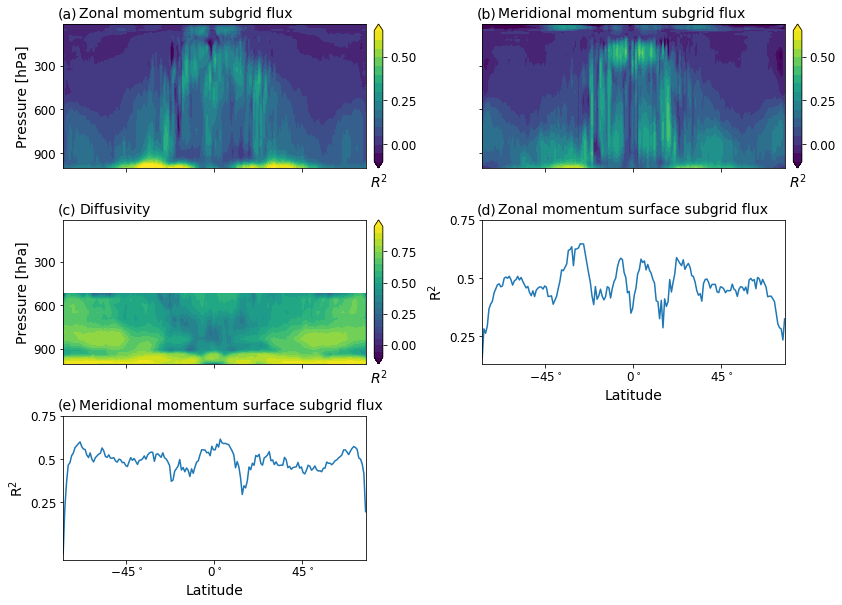

In [19]:
# plot_R2_contourf_production(r2_full,y,indices,p,save = 1, save_name = "r2_true_production")

coarse_factor = 2
y_coarse = np.zeros(int(y.shape[0]/coarse_factor))
for i in range(y_coarse.shape[0]):
    y_coarse[i] = np.mean(y[int(coarse_factor*i):int(coarse_factor*(i+1))])
    
    
# plot_R2_contourf_production(r2_coarse,y_coarse,indices,p,save = 1, save_name = "r2_coarse_production",coarse_flag=True)
# plot_R2_contourf_production(r2_full,y,indices,p,save = 0, save_name = "r2_true_production",coarse_flag=False)
# plot_R2_contourf_production(r2_coarse,y_coarse,indices,p,save = 1, save_name = "r2_coarse_fact_2_production_x4_scale",coarse_flag=False)
# plot_R2_contourf_production(r2_coarse,y_coarse,indices,p,save = 1, save_name = "r2_coarse_fact_2_production_x4_scale_many_colors",coarse_flag=False)
# plot_R2_contourf_production(r2_full,y,indices,p,save = True, 
#                             save_name = "r2_true_production_many_colors_no_c_grid_5_layers",
#                             coarse_flag=False,lev_Rsq = np.arange(-0.1, 0.67, 0.1),
#                             Rsq_ticks1=np.arange(-0.1, 0.7, 0.2))

plot_R2_contourf_production(r2_full,y,indices,p,save = False, 
                            save_name = "r2_true_production_many_colors_with_c_grid_5_layers_same_scale",
                            coarse_flag=False,lev_Rsq = np.arange(-0.1, 0.67, 0.05),
                            Rsq_ticks1=[0,0.25,0.5,0.75])



## Compare to Seager parameterization. 

In [20]:
def calc_precip(q, rho, z):
# surface precipitation rate given tendency of specific humidity
    precip = -vertical_integral(q, rho, z)
    return precip

def vertical_integral(data, rho, z):
# vertical integral with respect to sigma
    rho_dz = vertical_diff(rho, z)
    int_data = np.sum(data * rho_dz[:,None], axis=0)
    return int_data

def vertical_diff(rho, z):
    # follow vertical differencing from setgrid.f90 in SAM
    # changed indexing from starting at 1 to 0
    nzm = z.size
    adz = np.zeros(nzm)    
    dz = 0.5*(z[0]+z[1]) 
    adz[0] = 1.
    for k in range(1,nzm-1): # range doesn't include stopping number
        adz[k] = 0.5*(z[k+1]-z[k-1])/dz

    adz[nzm-1] = (z[nzm-1]-z[nzm-2])/dz

    rho_dz = adz*dz*rho

    return rho_dz

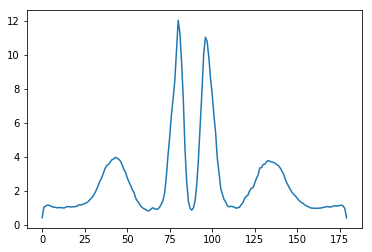

In [21]:
precip = np.zeros((v_48_lev['qout'].shape[1],v_48_lev['qout'].shape[2],v_48_lev['qout'].shape[3]))
for xi in range(v_48_lev['qout'].shape[2]):
    for ti in range(v_48_lev['qout'].shape[3]):
        precip[:,xi,ti] = calc_precip(v_48_lev['qout'][:,:,xi,ti], rho[0:48], z[0:48])*24*3600
plt.plot(np.mean(precip,axis=(1,2)))

#### Calculate tendency from the fluxes:

In [22]:
adzdz = vertical_diff(rho, z)

In [23]:
with_surface_fluxes = 0


u_tend = np.zeros((v_mom['u_flux'].shape[0] + 1,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
u_flux_ext = np.zeros((v_mom['u_flux'].shape[0] + 2,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
u_flux_ext[1:48,:,:,:] = v_mom['u_flux']
if with_surface_fluxes:
    u_flux_ext[0,:,:,:] = v_mom['u_surf']*dz
for yi in range(v_mom['u_flux'].shape[1]):
    for xi in range(v_mom['u_flux'].shape[2]):
        for ti in range(v_mom['u_flux'].shape[3]):
            u_tend[:,yi,xi,ti] = (-u_flux_ext[1:,yi,xi,ti]  + u_flux_ext[0:-1,yi,xi,ti])/adzdz

In [24]:
adzdz = vertical_diff(rho, z)

In [25]:
with_surface_fluxes = 0


u_tend = np.zeros((v_mom['u_flux'].shape[0] + 1,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
u_flux_ext = np.zeros((v_mom['u_flux'].shape[0] + 2,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
u_flux_ext[1:48,:,:,:] = v_mom['u_flux']
if with_surface_fluxes:
    u_flux_ext[0,:,:,:] = v_mom['u_surf']*dz
for yi in range(v_mom['u_flux'].shape[1]):
    for xi in range(v_mom['u_flux'].shape[2]):
        for ti in range(v_mom['u_flux'].shape[3]):
            u_tend[:,yi,xi,ti] = (-u_flux_ext[1:,yi,xi,ti]  + u_flux_ext[0:-1,yi,xi,ti])/adzdz

In [26]:
v_tend = np.zeros((v_mom['u_flux'].shape[0] + 1,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
v_flux_ext = np.zeros((v_mom['u_flux'].shape[0] + 2,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
v_flux_ext[1:48,:,:,:] = v_mom['v_flux']
if with_surface_fluxes:
    v_flux_ext[0,:,:,:] = v_mom['v_surf']*dz
for yi in range(v_mom['v_flux'].shape[1]):
    for xi in range(v_mom['v_flux'].shape[2]):
        for ti in range(v_mom['v_flux'].shape[3]):
            v_tend[:,yi,xi,ti] = (-v_flux_ext[1:,yi,xi,ti]  + v_flux_ext[0:-1,yi,xi,ti])/adzdz

In [27]:
inv_output_pred_test_3D_res = np.moveaxis(inv_output_pred_test_3D[15:15+47,:,:,:],1,3)
u_tend_pred = np.zeros((v_mom['u_flux'].shape[0] + 1,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
u_flux_ext = np.zeros((v_mom['u_flux'].shape[0] + 2,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
u_flux_ext[1:48,:,:,:] = inv_output_pred_test_3D_res
for yi in range(v_mom['u_flux'].shape[1]):
    for xi in range(v_mom['u_flux'].shape[2]):
        for ti in range(v_mom['u_flux'].shape[3]):
            u_tend_pred[:,yi,xi,ti] = (-u_flux_ext[1:,yi,xi,ti]  + u_flux_ext[0:-1,yi,xi,ti])/adzdz

In [28]:
inv_output_pred_test_3D_res = np.moveaxis(inv_output_pred_test_3D[15+47:15+94,:,:,:],1,3)
v_tend_pred = np.zeros((v_mom['u_flux'].shape[0] + 1,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
v_flux_ext = np.zeros((v_mom['u_flux'].shape[0] + 2,v_mom['u_flux'].shape[1],v_mom['u_flux'].shape[2],v_mom['u_flux'].shape[3]))
v_flux_ext[1:48,:,:,:] = inv_output_pred_test_3D_res
for yi in range(v_mom['u_flux'].shape[1]):
    for xi in range(v_mom['u_flux'].shape[2]):
        for ti in range(v_mom['u_flux'].shape[3]):
            v_tend_pred[:,yi,xi,ti] = (-v_flux_ext[1:,yi,xi,ti]  + v_flux_ext[0:-1,yi,xi,ti])/adzdz

In [29]:
latitudes_trop = np.arange(70,110,1)
zlevel= 25 # 213hPa
# zlevel= 24 # 232hPaa
# zlevel= 20 # 232hPa
# zlevel= 15 # 232hPa
# zlevel= 13 # 232hPa
u_diff_200 = v_mom['uin'][4,:,:,:] - v_mom['uin'][zlevel,:,:,:]
u_diff_200_vec = v_mom['uin'][4,:,:,:] - v_mom['uin'][:,:,:,:]

In [30]:

precip_mean_trop = np.mean(precip[latitudes_trop,:,:],axis=(1,2))
seager_param = precip_mean_trop * np.mean(u_diff_200[latitudes_trop,:,:],axis = (1,2))
seager_param_vec = precip_mean_trop[None,:] * np.mean(u_diff_200_vec[:,latitudes_trop,:,:],axis = (2,3))





In [31]:

# precip_mean_trop_2D = np.mean(precip[latitudes_trop,:,:],axis=(2))
# seager_param_2D = precip_mean_trop_2D * np.mean(u_diff_200[latitudes_trop,:,:],axis = (2))
# seager_param_vec_2D = precip_mean_trop_2D[None,:,:] * np.mean(u_diff_200_vec[:,latitudes_trop,:,:],axis = (3))

In [32]:
true_out_xt_avg = np.mean(u_tend[zlevel,latitudes_trop,:,:],axis = (1,2))
true_out_xt_avg_vec = np.mean(u_tend[:,latitudes_trop,:,:],axis = (2,3))
pred_out_xt_avg = np.mean(u_tend_pred[zlevel,latitudes_trop,:,:],axis = (1,2))
pred_out_xt_avg_vec = np.mean(u_tend_pred[:,latitudes_trop,:,:],axis = (2,3))

In [42]:
# true_out_xt_avg_2D = np.mean(u_tend[zlevel,latitudes_trop,:,:],axis = (2))
# true_out_xt_avg_vec_2D = np.mean(u_tend[:,latitudes_trop,:,:],axis = (3))
# pred_out_xt_avg_2D = np.mean(u_tend_pred[zlevel,latitudes_trop,:,:],axis = (2))
# pred_out_xt_avg_vec_2D = np.mean(u_tend_pred[:,latitudes_trop,:,:],axis = (3))

In [43]:
# no_lon_avg = False
# if no_lon_avg:
#     precip_mean_trop = np.reshape(precip_mean_trop_2D,-1)
#     seager_param = np.reshape(seager_param_2D,-1)
#     seager_param_vec = np.reshape(seager_param_vec_2D,[48,-1])
#     true_out_xt_avg = np.reshape(true_out_xt_avg_2D,[48,-1])
#     true_out_xt_avg_vec = np.reshape(true_out_xt_avg_vec_2D,[48,-1])
#     pred_out_xt_avg = np.reshape(pred_out_xt_avg_2D,[48,-1])
#     pred_out_xt_avg_vec = np.reshape(pred_out_xt_avg_vec_2D,[48,-1])
    

In [33]:
# Calculate the correlation at every level
precip_cutoff = 0
corr_NN_vec = np.zeros(true_out_xt_avg_vec.shape[0])
corr_seager_vec = np.zeros(true_out_xt_avg_vec.shape[0])
for zi in range(true_out_xt_avg_vec.shape[0]):
    corr_NN_vec[zi], _ = pearsonr(true_out_xt_avg_vec[zi,precip_mean_trop>precip_cutoff],pred_out_xt_avg_vec[zi,precip_mean_trop>precip_cutoff])
    corr_seager_vec[zi], _ = pearsonr(true_out_xt_avg_vec[zi, precip_mean_trop>precip_cutoff],seager_param_vec[zi,precip_mean_trop>precip_cutoff])
    
    

/glade/work/janniy/python_ncar_env/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


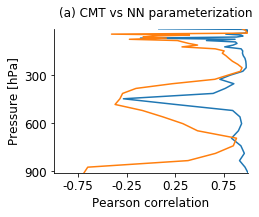

In [45]:
fontsize = 12
fontsize_legend = 8
ticks_lat = [-5,0,5]

# ticks_pmean = [0,0.2,0.4,0.6,0.8]
# ticks_px = ticks_pmean #np.arange(0,900,100)

# ticks_px_offline = ticks_pmean
# ticks_pmean_offline = ticks_pmean


# linewidth=1.5

true_range1 = -0.000005
true_range2 = 0.00001

true_ticks = [-0.000004,0,0.000004,0.000008]

h_width = 0.1
v_width = 0.1
h_width_cbar = 0.02
colorbar_width =0.02

row_dim = 2
col_dim = 2

fig_witdth = 0.45
fig_height = 0.5
fig_h_dist = 0.08
fig_v_dist = 0.15
mm_rain = 0


letters = ["(a) CMT vs NN parameterization","(b)  NN parameterization","(b) NN parameterization" ,"(d)"]
# letters = [r"(a) CMT vs. Prec(u(0.6km) - u)","(b)  NN parameterization","(b) NN parameterization" ,"(d)"]

# CMT’b3P3(u925 2u)
# headers = ["$q_t$ tend" +str(r2[0]),"26 lev (48 inputs) $R^2=$"+str(r2[1]),"38 lev $R^2=$"+str(r2[2]),"48 lev $R^2=$"+str(r2[3])]

colors1 = ['red','black','blue','green']
fig, axes = plt.subplots(row_dim,col_dim)

# cax_q_mean_offline = axes[0,0].plot(y_plot,  precip_mean_true * per_day, label='True', linewidth=linewidth,color=colors1[0])#,linestyle=':')
# cax_q_mean_offline2 = axes[0,0].plot(y_plot,  precip_mean_pred * per_day, label='Pred',linestyle='-.', linewidth=linewidth,color=colors1[1])
cax_mean_online2 =axes[0,0].plot(corr_NN_vec[5:],p[5:])
cax_mean_online2 =axes[0,0].plot(corr_seager_vec[5:],p[5:])
axes[0,0].set_xlim(-1, 1)
axes[0,0].set_ylim(p[5], p[-1])

fig.delaxes(axes[0,1])
fig.delaxes(axes[1,0])
fig.delaxes(axes[1,1])
#Position of first figure        
x0 = axes[0,0].get_position().x0
x1 = axes[0,0].get_position().x1
y0 = axes[0,0].get_position().y0
y1 = axes[0,0].get_position().y1

for i in range(row_dim):
    for j  in range(col_dim):
        axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth,fig_height])
        
    
ind_let = 0
for i in range(row_dim):
    for j  in range(col_dim):
        atext2 = axes[i, j].text(axes[0,0].get_position().x0*1.1+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.8- (i-1)*fig_height - (i-1)*fig_v_dist ,letters[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
        
#         header= axes[i, j].text(axes[0,0].get_position().x0*1.5+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.92- (i-1)*fig_height - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
        ind_let = ind_let + 1
true_ticks = [-0.75, -0.25, 0.25, 0.75]
press_lev = [300,600,900]


axes[0, 0].set_xticks(true_ticks)
axes[0, 0].set_xticklabels(true_ticks,fontsize=fontsize)
axes[0, 0].set_yticks(press_lev)
axes[0, 0].set_yticklabels(press_lev,fontsize=fontsize)



axes[0,0].spines["top"].set_visible(False)
axes[0,0].spines["right"].set_visible(False)

axes[0, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
axes[0, 0].set_xlabel('Pearson correlation',fontsize=fontsize)

# #Saving plot... fxax
save_path = '/glade/work/janniy/data_for_offline_momentum_paper/plots/'


# plt.savefig(save_path+'momentum_parameterization_seager_vs_NN_all_level_pearson.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_seager_vs_NN_all_level_pearson_no_c_grid.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_seager_vs_NN_all_level_pearson_no_c_grid_5_layers.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_seager_vs_NN_all_level_pearson_no_c_grid_5_layers_501_snapshots.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_seager_vs_NN_all_level_pearson_with_c_grid_5_layers_501_snapshots.eps', format='eps', bbox_inches="tight")




/glade/work/janniy/python_ncar_env/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


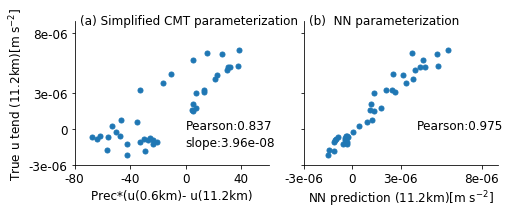

In [86]:
fontsize = 12
fontsize_legend = 8
ticks_lat = [-5,0,5]

# ticks_pmean = [0,0.2,0.4,0.6,0.8]
# ticks_px = ticks_pmean #np.arange(0,900,100)

# ticks_px_offline = ticks_pmean
# ticks_pmean_offline = ticks_pmean


# linewidth=1.5

if zlevel==13:
    true_range1 = -0.000001
    true_range2 = 0.000001
else:
    true_range1 = -0.000003
    true_range2 = 0.000009


if zlevel==13:
    true_ticks = [-0.0000035,0,0.0000035]
else:
    true_ticks = [-0.000003,0,0.000003,0.000008]

h_width = 0.1
v_width = 0.1
h_width_cbar = 0.02
colorbar_width =0.02

row_dim = 2
col_dim = 2

fig_witdth = 0.45
fig_height = 0.5
fig_h_dist = 0.08
fig_v_dist = 0.15
mm_rain = 0
scatter_size = 25
corr_paramet, _ = pearsonr(seager_param[precip_mean_trop>precip_cutoff],true_out_xt_avg[precip_mean_trop>precip_cutoff])
corr_paramet_RF, _ = pearsonr(true_out_xt_avg[precip_mean_trop>precip_cutoff],pred_out_xt_avg[precip_mean_trop>precip_cutoff])
slope, intercept, r_value, p_value, std_err = stats.linregress(seager_param[precip_mean_trop>precip_cutoff],true_out_xt_avg[precip_mean_trop>precip_cutoff])

slope_no_intercept, _, _, _ = np.linalg.lstsq(seager_param[precip_mean_trop>precip_cutoff,None],true_out_xt_avg[precip_mean_trop>precip_cutoff]) 
# = stats.linregress(seager_param[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])


marker1 = 100
markers_style = ['x','^','o']
letters = ["(a) Simplified CMT parameterization","(b)  NN parameterization","(b) NN parameterization" ,"(d)"]
# letters = [r"(a) CMT vs. Prec(u(0.6km) - u)","(b)  NN parameterization","(b) NN parameterization" ,"(d)"]

# CMT’b3P3(u925 2u)
# headers = ["$q_t$ tend" +str(r2[0]),"26 lev (48 inputs) $R^2=$"+str(r2[1]),"38 lev $R^2=$"+str(r2[2]),"48 lev $R^2=$"+str(r2[3])]

colors1 = ['red','black','blue','green']
fig, axes = plt.subplots(row_dim,col_dim)

# cax_q_mean_offline = axes[0,0].plot(y_plot,  precip_mean_true * per_day, label='True', linewidth=linewidth,color=colors1[0])#,linestyle=':')
# cax_q_mean_offline2 = axes[0,0].plot(y_plot,  precip_mean_pred * per_day, label='Pred',linestyle='-.', linewidth=linewidth,color=colors1[1])
cax_mean_online2 =axes[0,0].scatter(seager_param[precip_mean_trop>precip_cutoff],true_out_xt_avg[precip_mean_trop>precip_cutoff],s=scatter_size)


if zlevel==13:
    axes[0,0].set_xlim(-20, 20)
    axes[0,0].set_ylim(true_range1, true_range2)

else:
    axes[0,0].set_xlim(-80, 60)
    axes[0,0].set_ylim(true_range1, true_range2)


cax_mean_online3 = axes[0,1].scatter(pred_out_xt_avg[precip_mean_trop>precip_cutoff],true_out_xt_avg[precip_mean_trop>precip_cutoff],s=scatter_size)


# plot_kerry = False
# if plot_kerry:
#     u_tend_pred_xt_avg_emanuel = np.mean(emanuel_name_tend[0]['Emanuel_tend_u'][zlevel,latitudes_trop,:,:],axis = (1,2))
#     cax_mean_online3 = axes[0,1].scatter(u_tend_pred_xt_avg_emanuel[precip_mean_trop>precip_cutoff],true_out_xt_avg[precip_mean_trop>precip_cutoff])

axes[0,1].set_xlim(true_range1, true_range2)
axes[0,1].set_ylim(true_range1, true_range2)

fig.delaxes(axes[1,0])
fig.delaxes(axes[1,1])
#Position of first figure        
x0 = axes[0,0].get_position().x0
x1 = axes[0,0].get_position().x1
y0 = axes[0,0].get_position().y0
y1 = axes[0,0].get_position().y1

for i in range(row_dim):
    for j  in range(col_dim):
        axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth,fig_height])
        
    
ind_let = 0
for i in range(row_dim):
    for j  in range(col_dim):
        atext2 = axes[i, j].text(axes[0,0].get_position().x0*1.1+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.7- (i-1)*fig_height - (i-1)*fig_v_dist ,letters[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
        
#         header= axes[i, j].text(axes[0,0].get_position().x0*1.5+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.92- (i-1)*fig_height - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
        ind_let = ind_let + 1


# ticks_lat_degrees = ['$-45^\circ$','$0^\circ$','$45^\circ$']
# axes[1, 0].set_xticks(ticks_lat)
# axes[1, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize)
# axes[1, 0].set_yticks(ticks_px_offline)
# axes[1, 0].set_yticklabels(ticks_px_offline,fontsize=fontsize)

axes[0, 1].set_xticks(true_ticks)
axes[0, 1].set_xticklabels(true_ticks,fontsize=fontsize)
axes[0, 1].set_yticks(true_ticks)
axes[0, 1].set_yticklabels([])

axes[0, 0].set_yticks(true_ticks)
axes[0, 0].set_yticklabels(true_ticks,fontsize=fontsize)
if zlevel==13:
    axes[0, 0].set_xticks([-30,0,30])
    axes[0, 0].set_xticklabels([-30,0,30],fontsize=fontsize)

else:
    axes[0, 0].set_xticks([-80,-40,0,40])
    axes[0, 0].set_xticklabels([-80,-40,0,40],fontsize=fontsize)


# axes[0, 0].set_yticks(ticks_pmean_offline)
# axes[0, 0].set_yticklabels(ticks_pmean_offline,fontsize=fontsize)
# axes[0, 0].set_xticks(ticks_lat)
# axes[0, 0].set_xticklabels([])


# axes[1, 1].set_xticks(ticks_lat)
# axes[1, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize)
# axes[1, 1].set_yticks(ticks_px)
# axes[1, 1].set_yticklabels(ticks_px)



axes[0, 1].set_xlabel('NN prediction (' + "{:.1f}".format(z[zlevel]/1000) + 'km)' + '[m s$^{-2}$]',fontsize=fontsize)
# axes[1, 0].set_xlabel('RF prediction @ (9km)',fontsize=fontsize)

# axes[1, 0].set_ylabel('True u tend @ (11.2km) [m s$^{-2}$]',fontsize=fontsize)
# axes[1, 0].set_ylabel('True u tend @ (9km) [m s$^{-2}$]',fontsize=fontsize)

# axes[0, 0].set_xlabel(r'Prec*(u(0.6km) - u(11.2km)) [mm m s$^{-1}$ day$^{-1}]',fontsize=fontsize)
# axes[0, 0].set_xlabel(r'Prec*(u(0.6km) - u(11.2km))' ,fontsize=fontsize)
axes[0, 0].set_xlabel(r'Prec*(u(0.6km)- u(' + "{:.1f}".format(z[zlevel]/1000) + 'km)' ,fontsize=fontsize)
# 'NN prediction @ ('+  "{:.1f}".format(z[zlevel]/1000) + 'km) [m s$^{-2}$]'

# axes[0, 0].set_xlabel('Const * Prec*(u(0.6km) - u(9km))',fontsize=fontsize)
axes[0, 0].set_ylabel(r'True u tend (' + "{:.1f}".format(z[zlevel]/1000) + 'km)' + r'[m s$^{-2}$]',fontsize=fontsize)
# axes[0, 0].set_ylabel('True u tend @ (9km) [m s$^{-2}$]',fontsize=fontsize)


if zlevel==13:
    axes[0, 0].text(0, 0.000002, 'Pearson:' + str(round(corr_paramet,3)),fontsize=fontsize)
    axes[0, 0].text(0, 0.000002-0.000001, 'slope:' + "{:.2e}".format(slope_no_intercept[0]),fontsize=fontsize)

    axes[0, 1].text(1e-6, 0.000002, 'Pearson:' + str(round(corr_paramet_RF,3)),fontsize=fontsize)

else:
    axes[0, 0].text(0, 0, 'Pearson:' + str(round(corr_paramet,3)),fontsize=fontsize)
    # axes[0, 0].text(0, 0-0.0000014, 'slope:' + "{:.2e}".format(slope),fontsize=fontsize)
    axes[0, 0].text(0, 0-0.0000014, 'slope:' + "{:.2e}".format(slope_no_intercept[0]),fontsize=fontsize)

    axes[0, 1].text(4e-6, 0, 'Pearson:' + str(round(corr_paramet_RF,3)),fontsize=fontsize)

# scientific_notation = "{:.2e}".format(slope)
# scientific_notation

#  + 'pearson:' + str(round(corr_paramet,3))
# + 'pearson:' + str(round(corr_paramet_RF,3))


axes[0,0].spines["top"].set_visible(False)
axes[0,0].spines["right"].set_visible(False)


axes[0,1].spines["top"].set_visible(False)
axes[0,1].spines["right"].set_visible(False)

axes[1,1].spines["top"].set_visible(False)
axes[1,1].spines["right"].set_visible(False)

axes[1,0].spines["top"].set_visible(False)
axes[1,0].spines["right"].set_visible(False)




# #Saving plot... fxax
save_path = '/glade/work/janniy/data_for_offline_momentum_paper/plots/'


# plt.savefig(save_path+'momentum_parameterization_scatter.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_112km.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_107km_production.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_8_5km_production.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_5_7km_production.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_112km_no_c_grid.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_112km_no_c_grid_5_layers.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_112km_no_c_grid_5_layers_501_snapshpts.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_112km_with_c_grid_5_layers_501_snapshpts_publication.eps', format='eps', bbox_inches="tight")
plt.savefig(save_path+'momentum_parameterization_scatter_112km_with_c_grid_5_layers_501_snapshpts_publication_small.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_4_6km_production.eps', format='eps', bbox_inches="tight")


In [32]:
Umean1 = np.mean(loaded['uin'],axis=(2,3))
dU1 = Umean1[:-1,:] - Umean1[1:,:]
dz1 = z[:-1] - z[1:]
dU_dz = dU1/dz1[:,None] 

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(seager_param[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])

    slope_no_intercept, _, _, _ = np.linalg.lstsq(seager_param[precip_mean_trop>precip_cutoff,None],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff]) 
    # = stats.linregress(seager_param[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])
    if slope_NN_flag:
        slope_NN, _, _, _ = np.linalg.lstsq(np.reshape(pred_out_xt_avg,-1)[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff]) 


In [51]:
def plot_mean_4_2Dfields_2_1D_production(Field,Field2,Field3,Field4,y,indices,p, precip_mean_trop,
                                         seager_param, true_out_xt_avg, pred_out_xt_avg, pearson_lev = 11200,save=0,
                                         save_name = 'del',with_trop=False,trop_p =np.zeros(180),
                                 plot_shear = False, shear = [],colorbar_costum_scale = False, 
                                  color1 = [], color1_ticks =[], color2 =[],color2_ticks =[],
                                  color3 = [], color3_ticks =[], color4 =[],color4_ticks =[],
                                  color4_ticks_label=[],
                                  label1 = r'[kg m$^{-1}$ s$^{-2}$]', label2 = r'[m s$^{-2}$]', label3 = r'[kg m$^{-1}$ s$^{-2}$]', label4 = r'[m s$^{-2}$]',
                                    precip_cutoff = 0,
                                    headers = [r"Zonal momentum subgrid flux",r"Zonal momentum subgrid tendency",r"Meridional momentum subgrid flux",r"Meridional momentum subgrid tendency",r"Moisture surface subgrid flux",r"diffusivity RF"],
                                    slope_NN_flag = False
                                 ):
    
    letters = ["(a)","(b)","(c)","(d)","(e)",'(f)']
#     headers = [r"Zonal momentum subgrid flux",r"Zonal momentum subgrid tendency",r"Meridional momentum subgrid flux",r"Meridional momentum subgrid tendency",r"Moisture surface subgrid flux",r"diffusivity RF"]

    y_plot = (y - np.mean(y))/10**6
    ticks_lat = [-5,0,5]
    
    ticks_press_tkz = [1000,800,600]
#     ticks_press = [900,600,300]
    ticks_press = [800,400,50]

    if colorbar_costum_scale:
        lev_Rsq = color1
        lev_Rsq_ticks = color1_ticks
        lev_Rsq3 = color3
        lev_Rsq_ticks3 = color3_ticks
    else:
        lev_Rsq = np.arange(-0.04, 0.041, 0.002) 
        lev_Rsq_ticks = np.arange(-0.03, 0.031, 0.02) 
        lev_Rsq3 = lev_Rsq
        lev_Rsq_ticks3 = lev_Rsq
    if colorbar_costum_scale:
        lev_Rsq2 = color2
        lev_Rsq_ticks2 = color2_ticks
        lev_Rsq4 = color4
        lev_Rsq_ticks4 = color4_ticks
    else:
        lev_Rsq2 = np.arange(-0.00004, 0.000041, 0.000002) 
        lev_Rsq_ticks2 = np.arange(-0.00003, 0.000031, 0.00002) 
        lev_Rsq4 = lev_Rsq2
        lev_Rsq_ticks4 = lev_Rsq2

#     ticks_press_R2 = [-0.006,-0.003, 0,0.003,0.006] #np.arange(-0.0075, 0.00751, 0.005)
    
    cont_min_rsq = 0
    cont_max_rsq = 1
    
    fontsize = 14
    fontsize_legend = 8
    h_width = 0.1
    v_width = 0.1
    h_width_cbar = 0.02
    colorbar_width =0.02

    p_lev_diff = 15
    
    row_dim = 3
    col_dim = 2

    fig_witdth = 0.7
    fig_height = 0.5
    fig_h_dist = 0.27
    fig_v_dist = 0.22
    
    size1 = 2
    fig, axes = plt.subplots(row_dim,col_dim)
    # fig.set_figheight(10)
    # fig.set_figwidth(10)
    upper_level_p = 48
    lowest_level = 0
    cmap1 = 'bwr'
    n=30
    yind1 = 65
    x_ind1 = 10
    # wnumber = 1
    ind_ind = 0
    
    
    x0 = axes[0,0].get_position().x0
    x1 = axes[0,0].get_position().x1
    y0 = axes[0,0].get_position().y0
    y1 = axes[0,0].get_position().y1

    for i in range(row_dim):
        for j  in range(col_dim):
            if i == 0 and j == 1:
                axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth/1.0,fig_height])
            else:    
                axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth,fig_height])
    
        
    levels = lev_Rsq
    i = 0
    print(Field.T.shape)
    print(p[0:Field.shape[1]].shape)
    print(y_plot.shape)
    cax_xy1 =axes[i,0].contourf(y_plot,p[0:Field.shape[1]],Field.T,levels = levels,cmap=cmap1, extend="both")
    axes[i, 0].set_ylim(np.amax(p[:]), np.amin(p[0:Field.shape[1]]))
    pos1_rsq = axes[i, 0].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=lev_Rsq_ticks)
#     cbar_rsq.ax.set_xlabel(r'kg m$^{-2}$ s$^{-1}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
#     cbar_rsq.set_label(r'[kg m$^{-1}$ s$^{-2}$]', rotation=90,fontsize=fontsize-2)
    cbar_rsq.set_label(label1, rotation=90,fontsize=fontsize-2)
    
    if plot_shear:
#         lev_shear_cont =np.arange(-0.026,0.026,0.002)# [0,100,200,300,400,500,600,700]
        lev_shear_cont = [-0.01,-0.003,0.003,0.01]
        cax_q_Rsq = axes[i, 0].contour(y_plot, p[0:shear.shape[0]], shear,lev_shear_cont,colors='k')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
        axes[i, 0].set_ylim(np.amax(p), np.amin(p))
        # axes[1,0].clabel(cax_q_Rsq,cax_q_Rsq.levels[::6],fmt = '%1.0f', inline=1, fontsize=fontsize_cont1)
#         axes[i,0].clabel(cax_q_Rsq,lev_shear_cont[13],fmt = '%1.0f', inline=1, fontsize=fontsize-2)
        lev_shear_cont = [0]
        cax_q_Rsq = axes[i, 0].contour(y_plot, p[0:shear.shape[0]], shear,lev_shear_cont,colors='k')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
        axes[i, 0].set_ylim(np.amax(p), np.amin(p))
        cax_q_Rsq.collections[0].set_linewidth(2) 

    
    levels = lev_Rsq3
    i = 1
    cax_xy1 =axes[i,0].contourf(y_plot,p[0:Field2.shape[1]],Field2.T,levels = levels,cmap=cmap1, extend="both")
    axes[i, 0].set_ylim(np.amax(p[:]), np.amin(p[0:Field2.shape[1]]))
    pos1_rsq = axes[i, 0].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=lev_Rsq_ticks3)
#     cbar_rsq.ax.set_xlabel(r'kg m$^{-2}$ s$^{-1}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
    cbar_rsq.set_label(label3, rotation=90,fontsize=fontsize-2)
    cbar_rsq.ax.set_yticklabels(color4_ticks_label)
    
    levels = lev_Rsq2
    i = 1
    cax_xy1 =axes[0,i].contourf(y_plot,p[0:Field3.shape[1]],Field3.T,levels = levels,cmap=cmap1, extend="both")
    axes[0, i].set_ylim(np.amax(p[:]), np.amin(p[0:Field3.shape[1]]))
    pos1_rsq = axes[0, i].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[0,i], shrink=1.0,ticks=lev_Rsq_ticks2)
#     cbar_rsq.ax.set_xlabel(r'm s$^{-2}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
    cbar_rsq.set_label(label2, rotation=90,fontsize=fontsize-2)
    
    levels = lev_Rsq4
    i = 1
    cax_xy1 =axes[1,i].contourf(y_plot,p[0:Field4.shape[1]],Field4.T,levels = levels,cmap=cmap1, extend="both")
    axes[1, i].set_ylim(np.amax(p[:]), np.amin(p[0:Field4.shape[1]]))
    pos1_rsq = axes[1, i].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[1,i], shrink=1.0,ticks=lev_Rsq_ticks4)
    cbar_rsq.ax.set_yticklabels(color4_ticks_label)
#     cbar_rsq.ax.set_xlabel(r'm s$^{-2}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
    cbar_rsq.set_label(label4, rotation=90,fontsize=fontsize-2)

    
    if with_trop:
        axes[0,0].plot(y_plot,trop_p,':k')
        axes[1,0].plot(y_plot,trop_p,':k')
        axes[0,1].plot(y_plot,trop_p,':k')
        axes[1,1].plot(y_plot,trop_p,':k')
    
    ind_let = 0
    for i in range(row_dim):
        for j  in range(col_dim):
            atext2 = axes[i, j].text(axes[0,0].get_position().x0*0.9+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.7- (i-1)*fig_height - (i-1)*fig_v_dist ,letters[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)

            header= axes[i, j].text(axes[0,0].get_position().x0*1.3+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.7- (i-1)*fig_height - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
            ind_let = ind_let + 1

            
            
            
    axes[0, 0].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[1, 0].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[2, 0].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[0, 1].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[1, 1].set_xlim(np.amin(y_plot), np.amax(y_plot))
    


    axes[0, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
    axes[1, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
#     axes[2, 0].set_ylabel(r'kg m$^{-2}$ s$^{-1}$',fontsize=fontsize)
#     axes[1, 1].set_ylabel(r'kg m$^{-2}$ s$^{-1}$',fontsize=fontsize)


# axes[2, 0].set_xlabel('y [$10^3$ km]',fontsize=fontsize)
# axes[1, 1].set_xlabel('y [$10^3$ km]',fontsize=fontsize)


    axes[1, 0].set_xlabel('Latitude',fontsize=fontsize)
    axes[1, 1].set_xlabel('Latitude',fontsize=fontsize)
    
    fontsize_ticks = fontsize -2  
    ticks_lat_degrees = ['$-45^\circ$','$0^\circ$','$45^\circ$']
#     axes[1, 1].set_yticks(ticks_press_R2)
#     axes[1, 1].set_yticklabels(ticks_press_R2,fontsize=fontsize_ticks)
#     axes[2, 0].set_yticks(ticks_press_R2)
#     axes[2, 0].set_yticklabels(ticks_press_R2,fontsize=fontsize_ticks)

#     axes[2, 0].set_xticks(ticks_lat)
#     axes[2, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
#     axes[1, 1].set_xticks(ticks_lat)
#     axes[1, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
     
    axes[0, 0].set_xticks(ticks_lat)
    axes[0, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    axes[1, 0].set_xticks(ticks_lat)
    axes[1, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    axes[0, 1].set_xticks(ticks_lat)
    axes[0, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    
    axes[0, 0].set_yticks(ticks_press)
    axes[0, 0].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
    
    axes[1, 0].set_yticks(ticks_press)
    axes[1, 0].set_yticklabels(ticks_press,fontsize=fontsize_ticks)

    axes[0, 1].set_yticks(ticks_press)
    axes[0, 1].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
    axes[1, 1].set_yticks(ticks_press)
    axes[1, 1].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
  
    axes[1, 1].set_xticks(ticks_lat)
    axes[1, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)

    
    
#     axes[2, 0].set_xticks(ticks_lat)
#     axes[2, 0].set_xticklabels([])

#     fig.delaxes(axes[2,1])
#     fig.delaxes(axes[2,0])
  
    true_range1 = -0.0000028
    true_range2 = 0.0000075

    true_ticks = [0,0.000003,0.000006]

    mm_rain = 0
#     corr_paramet, _ = pearsonr(seager_param[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])
    corr_paramet, _ = pearsonr(seager_param[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
#     corr_paramet_RF, _ = pearsonr(true_out_xt_avg[precip_mean_trop>2],pred_out_xt_avg[precip_mean_trop>2])
    corr_paramet_RF, _ = pearsonr(np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff],np.reshape(pred_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
    slope, intercept, r_value, p_value, std_err = stats.linregress(seager_param[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])

    slope_no_intercept, _, _, _ = np.linalg.lstsq(seager_param[precip_mean_trop>precip_cutoff,None],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff]) 
    # = stats.linregress(seager_param[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])
    if slope_NN_flag:
        slope_NN, _, _, _ = np.linalg.lstsq(np.reshape(pred_out_xt_avg,-1)[precip_mean_trop>precip_cutoff,None],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff]) 

    marker1 = 100
    markers_style = ['x','^','o']

    colors1 = ['red','black','blue','green']
    cax_mean_online2 =axes[2,0].scatter(seager_param[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
    axes[2,0].set_xlim(-75, 50)
    axes[2,0].set_ylim(true_range1, true_range2)
    cax_mean_online3 = axes[2,1].scatter(np.reshape(pred_out_xt_avg,-1)[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
    axes[2,1].set_xlim(true_range1, true_range2)
    axes[2,1].set_ylim(true_range1, true_range2)

    axes[2, 1].set_xticks(true_ticks)
    axes[2, 1].set_xticklabels(true_ticks,fontsize=fontsize)
    axes[2, 1].set_yticks(true_ticks)
    axes[2, 1].set_yticklabels(true_ticks,fontsize=fontsize)

    axes[2, 0].set_yticks(true_ticks)
    axes[2, 0].set_yticklabels(true_ticks,fontsize=fontsize)
    axes[2, 0].set_xticks([-80,-40,0,40])
    axes[2, 0].set_xticklabels([-80,-40,0,40],fontsize=fontsize)

    
    axes[2, 1].set_xlabel('NN prediction (' + "{:.1f}".format(pearson_lev/1000) + 'km)' + '[m s$^{-2}$]',fontsize=fontsize)
    axes[2, 0].set_xlabel(r'Prec*(u(0.6km)- u(' + "{:.1f}".format(pearson_lev/1000) + 'km)' + '[mm day$^{-1}$ m s$^{-1}$]' ,fontsize=fontsize)
    axes[2, 0].set_ylabel(r'True u tend (' + "{:.1f}".format(pearson_lev/1000) + 'km)' + r'[m s$^{-2}$]',fontsize=fontsize)
    axes[2, 0].text(0, 0, 'r:' + str(round(corr_paramet,3)),fontsize=fontsize)
    axes[2, 0].text(0, 0-0.0000014, 'slope:' + "{:.2e}".format(slope_no_intercept[0]),fontsize=fontsize)
    axes[2, 1].text(4e-6, 0, 'r:' + str(round(corr_paramet_RF,3)),fontsize=fontsize)
    if slope_NN_flag:
        axes[2, 1].text(4e-6, 0-0.0000014, 'slope:' + "{:.2e}".format(slope_NN[0]),fontsize=fontsize)

    axes[2,0].spines["top"].set_visible(False)
    axes[2,0].spines["right"].set_visible(False)
    axes[2,1].spines["top"].set_visible(False)
    axes[2,1].spines["right"].set_visible(False)
        
    if save:
        save_path = '/glade/work/janniy/data_for_offline_momentum_paper/plots/'
        plt.savefig(save_path+ save_name +'.eps', format='eps', bbox_inches="tight")
        
#         from matplotlib.ticker import PercentFormatter

# #         data = [1000, 1000, 5000, 3000, 4000, 16000, 2000]

# #         axes[3,0].hist(np.reshape(field1,-1), weights=np.ones(np.reshape(field1,-1).shape) / np.reshape(field1,-1).shape,bins = 1000)
# #         axes[3,1].hist(np.reshape(field2,-1), weights=np.ones(np.reshape(field2,-1).shape) / np.reshape(field2,-1).shape,bins = 1000)

# #         axes[3,0].gca().yaxis.set_major_formatter(PercentFormatter(1))
    

(47, 180)
(47,)
(180,)


/glade/work/janniy/python_ncar_env/lib/python3.6/site-packages/ipykernel_launcher.py:253: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


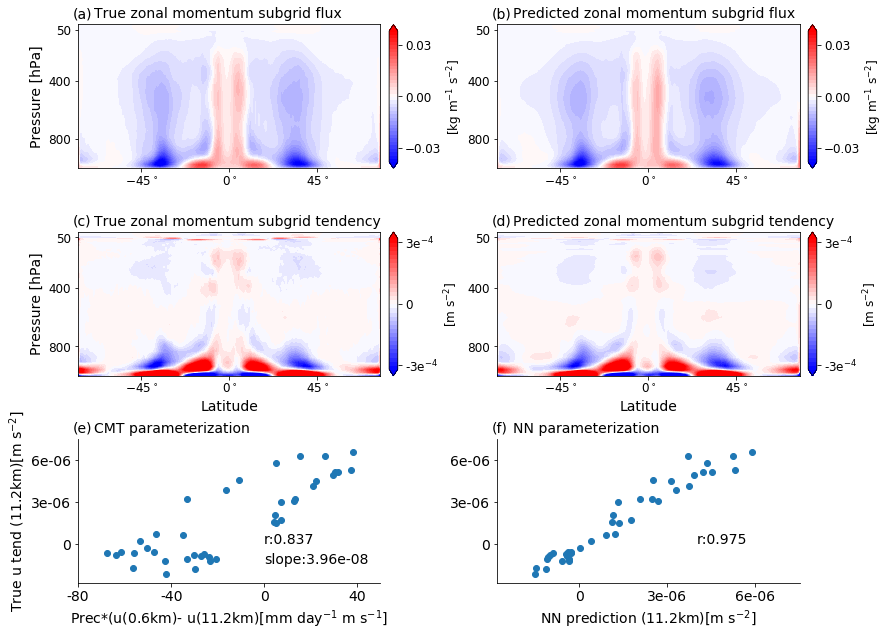

In [90]:
# trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,min_lev_trop_ind=10)
plot_mean_4_2Dfields_2_1D_production(np.mean(np.moveaxis(inv_output_true_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(u_tend,0,2),axis = (1,3)),
                              np.mean(np.moveaxis(inv_output_pred_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(u_tend_pred,0,2),axis = (1,3)),
                              y,indices,p, precip_mean_trop,
                              seager_param, true_out_xt_avg, pred_out_xt_avg, pearson_lev = z[zlevel],
#                               save = True, save_name = "u_flux_TEND_true_and_pred_x8_no_c_grid_with_seager_501snapshots_with_shear",with_trop=False,trop_p = trop_p,
                              save = True, save_name = "u_flux_TEND_true_and_pred_x8_with_c_grid_with_seager_501snapshots_no_shear_sponge_tick_no_cutoff_Sept_22",with_trop=False,trop_p = [],
                              plot_shear=False, shear = dU_dz, colorbar_costum_scale = True, 
                              color1 = np.arange(-0.038,0.039,0.002),
                              color1_ticks = [-0.03,0,0.03],
                              color3 = np.arange(-0.000032,0.000033,0.000002),
                              color3_ticks = [-0.00003,0,0.00003],
#                               color3 = np.arange(-0.000120,0.000131,0.00001),
#                               color3_ticks = [-0.00008,0,0.00008],
                              color2 = np.arange(-0.038,0.039,0.002),
                              color2_ticks = [-0.03,0,0.03],
                              color4 = np.arange(-0.000032,0.000033,0.000002),
                              color4_ticks = [-0.00003,0,0.00003],
                              color4_ticks_label = [r'-3e$^{-4}$','0',r'3e$^{-4}$'],
#                               color4 = np.arange(-0.000120,0.000131,0.00001),
#                               color4_ticks = [-0.00008,0,0.00008],
                                     label1='[kg m$^{-1}$ s$^{-2}$]',label3='[m s$^{-2}$]',
                                     label2='[kg m$^{-1}$ s$^{-2}$]',label4='[m s$^{-2}$]',
                             headers = [r"True zonal momentum subgrid flux",r"Predicted zonal momentum subgrid flux",r"True zonal momentum subgrid tendency",r"Predicted zonal momentum subgrid tendency",r"CMT parameterization",r"NN parameterization"])
    


# Plot mean flux and tendencies

(47, 180)
(47,)
(180,)


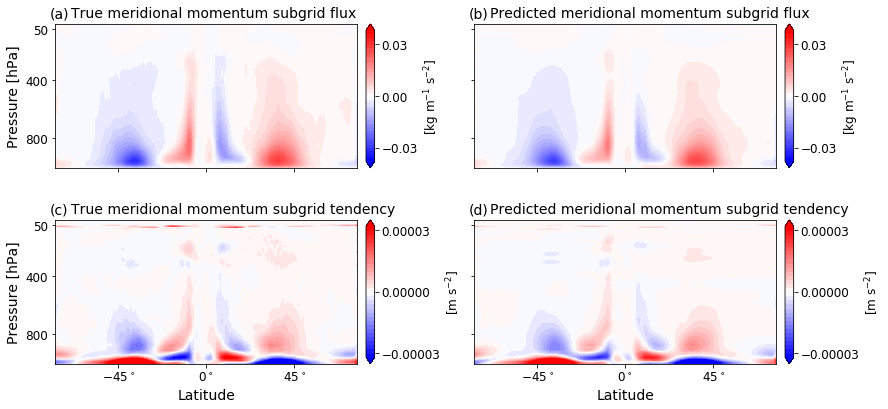

In [39]:
trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,p,min_lev_trop_ind=10)
plot_mean_4_fields_production(np.mean(np.moveaxis(inv_output_true_test_3D[15+47:15+47+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(v_tend,0,2),axis = (1,3)),
                              np.mean(np.moveaxis(inv_output_pred_test_3D[15+47:15+47+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(v_tend_pred,0,2),axis = (1,3)),
                              y,indices,p,save = False, save_name = "v_flux_TEND_true_and_pred_x8_no_c_grid_501_snapshots_tick_at_sponge",with_trop=False,trop_p = trop_p,
                              plot_shear=False, shear = [], colorbar_costum_scale = True, 
                              color1 = np.arange(-0.038,0.039,0.002),
                              color1_ticks = [-0.03,0,0.03],
                              color3 = np.arange(-0.000032,0.000033,0.000002),
                              color3_ticks = [-0.00003,0,0.00003],
                              color2 = np.arange(-0.038,0.039,0.002),
                              color2_ticks = [-0.03,0,0.03],
                              color4 = np.arange(-0.000032,0.000033,0.000002),
                              color4_ticks = [-0.00003,0,0.00003],
                             headers = [r"True meridional momentum subgrid flux",r"Predicted meridional momentum subgrid flux",r"True meridional momentum subgrid tendency",r"Predicted meridional momentum subgrid tendency",r"Moisture surface subgrid flux",r"diffusivity RF"])

In [41]:
# plot_std_4_fields_production(np.std(np.moveaxis(inv_output_true_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
#                               np.std(np.moveaxis(inv_output_true_test_3D[15+47:15+47*2,:,:,:],0,2),axis = (0,3)),
#                               np.std(np.moveaxis(u_tend,0,2),axis = (1,3)),
#                               np.std(np.moveaxis(v_tend,0,2),axis = (1,3)),
#                               y,indices,p,save = False, save_name = "u_v_flux_tend_trop_STD_x8_true_with_c_grid_501_snapshots",with_trop=False,trop_p = [],
#                             lev_Rsq = np.arange(0,0.4,0.01),
#                             lev_Rsq_ticks = np.arange(0,0.4,0.15),
#                             lev_Rsq2 = np.arange(0,0.00065,0.00003),
#                             lev_Rsq_ticks2 = np.arange(0,0.00065,0.00015))


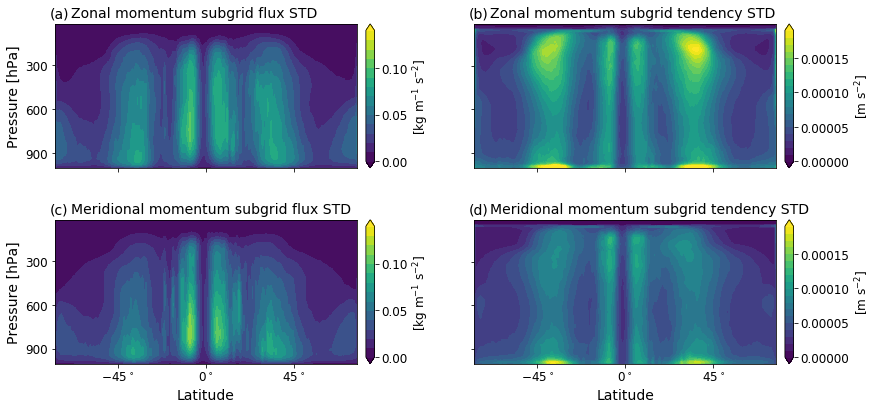

In [42]:
plot_std_4_fields_production(np.std(np.moveaxis(inv_output_true_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
                              np.std(np.moveaxis(inv_output_true_test_3D[15+47:15+47*2,:,:,:],0,2),axis = (0,3)),
                              np.std(np.moveaxis(u_tend,0,2),axis = (1,3)),
                              np.std(np.moveaxis(v_tend,0,2),axis = (1,3)),
                              y,indices,p,save = False, save_name = "u_v_flux_tend_trop_STD_x8_true_no_c_grid_501_snapshots",with_trop=False,trop_p = [],
                            lev_Rsq = np.arange(0,0.14,0.01),
                            lev_Rsq_ticks = np.arange(0,0.16,0.05),
                            lev_Rsq2 = np.arange(0,0.0002,0.00001),
                            lev_Rsq_ticks2 = np.arange(0,0.0002,0.00005))


## Plot time dependent

In [60]:
true_u_flux = inv_output_true_test_3D[15:15+47,:,:,:]
pred_u_flux = inv_output_pred_test_3D[15:15+47,:,:,:]

In [61]:
true_v_flux = inv_output_true_test_3D[15+47:15+47*2,:,:,:]
pred_v_flux = inv_output_pred_test_3D[15+47:15+47*2,:,:,:]

In [62]:
def vertical_integral3D(data, rho, z):
# vertical integral with respect to sigma
    rho_dz = vertical_diff(rho, z)
    int_data = np.sum(data * rho_dz[:,None,None,None], axis=0)
    return int_data

In [63]:
ones = np.zeros(rho.shape)
ones = ones + 1
true_u_flux_int= vertical_integral3D(true_u_flux,ones[0:47],z[0:47])
pred_u_flux_int= vertical_integral3D(pred_u_flux,ones[0:47],z[0:47])

true_v_flux_int= vertical_integral3D(true_v_flux,ones[0:47],z[0:47])
pred_v_flux_int= vertical_integral3D(pred_v_flux,ones[0:47],z[0:47])

In [64]:
true_v_flux_vert_mean = np.mean(true_v_flux,axis=0)
pred_v_flux_vert_mean = np.mean(pred_v_flux,axis=0)

true_u_flux_vert_mean = np.mean(true_u_flux,axis=0)
pred_u_flux_vert_mean = np.mean(pred_u_flux,axis=0)

In [65]:
def plot_sapshots_2x2_mom_energy_switch(true_field,true_sec_field,pred_field,true_field_int_z,pred_field_int_z,
                  precip,p,y_i =80,change_range=0,save_flag = False,save_name1= 'del_snap',
                  plot_trop=False,trop_p = [],
                  x_ind1 =10, time_ind1=-100, time_ind2 = -1,
                                 flux_ticks_colorbarT = np.arange(-0.6,0.65,0.3),
                                 flux_ticks_colorbar = np.arange(-0.6,0.65,0.3),
                                 flag_moisture = False,
                                 flux_ticks_label = [-0.3,-0.15,0,0.15000,0.3000],
                                 y_lim1 =-0.7000, y_lim2 =0.4400,
                                 range_momentum = 0,
                                 range_energy = 0, sat_fact = 1.5, precip_labels = [0,50,100,150],
                                 letters = ["(a) True subgrid momentum flux","(b) Mean fluxes and precipitation",'(c) Predicted subgrid momentum flux','(d) True subgrid energy flux','','','','']
                 ):
    per_day = 3600*24
    fontsize = 15
    fontsize_legend = 8
    h_width = 0.1
    v_width = 0.1
    h_width_cbar = 0.02
    colorbar_width =0.02

    row_dim = 3
    col_dim = 2

    fig_witdth = 0.75
    fig_height = 0.65
    fig_h_dist = 0.4
    fig_v_dist = 0.2
    
#     flux_ticks_colorbar = np.arange(-0.6,0.65,0.2)
#     flux_ticks_colorbar = np.arange(-0.6,0.65,0.2)

#     if flag_moisture:
#         letters = ["(a) True subgrid momentum flux","(b) Mean fluxes and precipitation",'(c) Predicted subgrid momentum flux','(d) True subgrid moisture flux','','','','']
#     else:
#         letters = ["(a) True subgrid momentum flux","(b) Mean fluxes and precipitation",'(c) Predicted subgrid momentum flux','(d) True subgrid energy flux','','','','']
#     letters = ["(a) True subgrid momentum flux","(b) Predicted subgrid momentum flux",'(c) Integrated fluxes and precipitation','(d) True subgrid moisture flux','','','','']

    size1 = 2
    fig, axes = plt.subplots(row_dim,col_dim)
    # fig.set_figheight(10)
    # fig.set_figwidth(10)
    upper_level_p = 47
    lowest_level = 0
    cmap1 = 'bwr'
    time_steps = time_ind2 - time_ind1
    time = np.arange(0,time_steps*3,3)
    n=31
    yind1 = y_i
#     x_ind1 = 10
    # wnumber = 1
    if range_momentum == 0:
        range11 = np.max(np.abs((true_u_flux[:,-time_steps:,yind1,x_ind1])))/sat_fact
    else:
        range11 = range_momentum
    levels = np.linspace(-range11, range11, n+1)
    print(time.shape)
    print(p[lowest_level:upper_level_p].shape)
    print(true_field[lowest_level:upper_level_p,time_ind1:time_ind2,yind1,x_ind1][lowest_level:upper_level_p].shape)
    cax_mean_online2 =axes[0,0].contourf(time,p[lowest_level:upper_level_p],true_field[lowest_level:upper_level_p,time_ind1:time_ind2,yind1,x_ind1],levels = levels,cmap=cmap1, extend="both")
    axes[0, 0].set_ylim(np.amax(p[lowest_level]), np.amin(p))
    if plot_trop:
        axes[0, 0].plot(time,trop_p)

    if change_range == 1:
        range11 = np.max(np.abs((pred_field[:,-time_steps:,yind1,x_ind1])))/sat_fact
        levels = np.linspace(-range11, range11, n+1)
        upper_level_p = pred_field.shape[0]
    cax_mean_online3 =axes[1,0].contourf(time,p[lowest_level:upper_level_p],pred_field[lowest_level:upper_level_p,time_ind1:time_ind2,yind1,x_ind1],levels = levels,cmap=cmap1, extend="both")
    axes[1, 0].set_ylim(np.amax(p[lowest_level]), np.amin(p))
    if plot_trop:
        axes[1, 0].plot(time,trop_p)

    


    color = 'black'
    lns1 =axes[0,1].plot(time,true_field_int_z[time_ind1:time_ind2,yind1,x_ind1], color=color,label='mean flux (true)')
    lns2 =axes[0,1].plot(time,pred_field_int_z[time_ind1:time_ind2,yind1,x_ind1], 'r:',label='mean flux (predicted)')
    axes[0, 1].set_xlim(0, time[-1])
    axes[0, 1].tick_params(axis='y', labelcolor=color)

    
    ax2 = axes[0, 1].twinx()
    color = 'tab:blue'
    lns3 =ax2.plot(time,precip[yind1,x_ind1,time_ind1:time_ind2], color=color,label='precipitation')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel(r'Subgrid flux [kg m$^{-1}$ s$^{-2}$]', color=color,fontsize=fontsize)  # we already handled the x-label with ax1
#     ax2 = axes[0, 1].twinx()
#     color = 'tab:blue'
#     ax2.set_ylabel(r'Subgrid flux [kg m$^{-1}$ s$^{-2}$]', color=color,fontsize=fontsize)  # we already handled the x-label with ax1
# #     ax2.set_ylabel(r'Subgrid flux [kg s$^{-2}$]', color=color,fontsize=fontsize)  # we already handled the x-label with ax1
#     lns2 =ax2.plot(time,true_field_int_z[time_ind1:time_ind2,yind1,x_ind1], color=color,label='mean flux (true)')
#     ax2.tick_params(axis='y', labelcolor=color)
#     lns3 =ax2.plot(time,pred_field_int_z[time_ind1:time_ind2,yind1,x_ind1], 'r:',label='mean flux (predicted)')
    
    # added these three lines
    lns = lns1+lns2+lns3
    labs = [l.get_label() for l in lns]
    axes[0, 1].legend(lns, labs, loc='upper center',frameon=False)
    
    
    upper_level_p_energy = 47
    if range_energy ==0:
        range_energy = np.max(np.abs((true_sec_field[:,-time_steps:,yind1,x_ind1])))/1.5
    else:
        range_energy =range_energy
    levels_energy = np.linspace(-range_energy, range_energy, n+1)
    cax_mean_online_enrgy =axes[1,1].contourf(time,p[lowest_level:upper_level_p_energy],true_sec_field[lowest_level:upper_level_p_energy,time_ind1:time_ind2,yind1,x_ind1],levels = levels_energy,cmap=cmap1, extend="both")
    axes[1, 1].set_ylim(np.amax(p[lowest_level]), np.amin(p))
    if plot_trop:
        axes[1, 1].plot(time,trop_p)
    
    # yind1 = 43
    # # wnumber = 1
    # range11 = np.max(np.abs((fuz[:,yind1,x_ind1,:])))/1.4
    # levels = np.linspace(-range11, range11, n+1)
    # cax_mean_online3 =axes[0,1].contourf(time,p[lowest_level:upper_level_p],(fuz[lowest_level:upper_level_p,yind1,x_ind1,:]),levels = levels,cmap=cmap1)
    # axes[0, 1].set_ylim(np.amax(p[lowest_level]), np.amin(p))


    # color = 'tab:red'
    # cax_mean_online4 =axes[1,1].plot(time,precip11[yind1,x_ind1,:]*24*3600, color=color)
    # axes[1, 1].set_xlim(0, time[-1])
    # axes[1, 1].tick_params(axis='y', labelcolor=color)


    # ax2 = axes[1, 1].twinx()
    # color = 'tab:blue'
    # ax2.set_ylabel('subg flux', color=color)  # we already handled the x-label with ax1
    # cax_mean_online4 =ax2.plot(time,fuz_int[yind1,x_ind1,:], color=color)
    # ax2.tick_params(axis='y', labelcolor=color)



    x0 = axes[0,0].get_position().x0
    x1 = axes[0,0].get_position().x1
    y0 = axes[0,0].get_position().y0
    y1 = axes[0,0].get_position().y1

    for i in range(row_dim):
        for j  in range(col_dim):
            axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth,fig_height])


    ind_let = 0
    for i in range(row_dim):
        for j  in range(col_dim):
            atext2 = axes[i, j].text(axes[0,0].get_position().x0*1.1+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.76- (i-1)*fig_height - (i-1)*fig_v_dist ,letters[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)

    #         header= axes[i, j].text(axes[0,0].get_position().x0*1.5+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.92- (i-1)*fig_height - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
            ind_let = ind_let + 1

    pos1_rsq = axes[0, 0].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    cbar_rsq = fig.colorbar(cax_mean_online2,cax = cbaxes_rsq, ax=axes[0,0], shrink=1.0,ticks=flux_ticks_colorbar)
    cbar_rsq.ax.tick_params(labelsize=fontsize) 
    cbar_rsq.set_label(r'[kg m$^{-1}$ s$^{-2}$]',fontsize=fontsize)
    
    if change_range == 1:
        flux_ticks_colorbar = np.arange(-range11,range11,range11/10)
    pos1_rsq = axes[1, 0].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_mean_online3,cax = cbaxes_rsq, ax=axes[1,0], shrink=1.0,ticks=flux_ticks_colorbar)
    cbar_rsq = fig.colorbar(cax_mean_online3,cax = cbaxes_rsq, ax=axes[1,0], shrink=1.0,ticks=flux_ticks_colorbar)
    cbar_rsq.ax.tick_params(labelsize=fontsize) 
    cbar_rsq.set_label(r'[kg m$^{-1}$ s$^{-2}$]',fontsize=fontsize)

    pos1_rsq = axes[1, 1].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    cbar_rsq = fig.colorbar(cax_mean_online_enrgy,cax = cbaxes_rsq, ax=axes[1,1], shrink=1.0,ticks=flux_ticks_colorbarT)
    cbar_rsq.ax.tick_params(labelsize=fontsize) 
#     cbar_rsq.set_label(r'[kg m$^{-2}$ sec$^{-1}$ K]',fontsize=fontsize)
    if flag_moisture:
        cbar_rsq.set_label(r'[kg m$^{-2}$ s$^{-1}$ kg$^{-1}$ kg]',fontsize=fontsize)
    else:
        cbar_rsq.set_label(r'[kg m$^{-2}$ s$^{-1}$ K]',fontsize=fontsize)

    # pos1_rsq = axes[0, 1].get_position() # get the original position 
    # cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    # cbar_rsq = fig.colorbar(cax_mean_online3,cax = cbaxes_rsq, ax=axes[0,1], shrink=1.0,)

    # pos1_rsq = axes[1, 1].get_position() # get the original position 
    # cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    # cbar_rsq = fig.colorbar(cax_mean_online4,cax = cbaxes_rsq, ax=axes[1,1], shrink=1.0,)





    # pos1_rsq = axes[1, 0].get_position() # get the original position 
    # cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    # cbar_rsq = fig.colorbar(cax_mean_online5,cax = cbaxes_rsq, ax=axes[1,0], shrink=1.0,)





    axes[1, 0].set_xlabel('Time (hours)',fontsize=fontsize)
    axes[1, 1].set_xlabel('Time (hours)',fontsize=fontsize)
    axes[0, 1].set_ylabel(r'Subgrid flux [kg m$^{-1}$ s$^{-2}$]', color='black',fontsize=fontsize)  # we already handled the x-label with ax1
    ax2.set_ylabel(r'Precipitation  [mm day$^{-1}$]',fontsize=fontsize)
    axes[0, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
    axes[1, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
    axes[1, 1].set_ylabel('Pressure [hPa]',fontsize=fontsize)


    # axes[0, 0].set_yticks(ticks_pmean)
    axes[0, 1].set_yticklabels([])
    # axes[1, 1].set_yticklabels([])


    
    axes[0,1].spines["top"].set_visible(False)
    axes[0,1].spines["right"].set_visible(False)

#     precip_ticks = [0,50,100,150,200,250,300,350,400,450]  
    ax2.set_ylim(0,2.6*precip_labels[-1])
    
#     ax2.set_ylim(-7000,8000)
    axes[0, 1].set_ylim(y_lim1,y_lim2)
#     ax2.set_ylim(-0.3000,0.3400)
#     precip_labels = [0,50,100,150]
    precip_ticks = precip_labels
    ax2.set_yticks(precip_ticks)
    ax2.set_yticklabels(precip_labels,fontsize=fontsize)

#     flux_ticks = [-2000,0,2000,4000,6000,8000]
#     flux_ticks = [-6000,-3000,0,3000,6000]
#     flux_ticks_label = [0,0.15000,0.3000]
#     flux_ticks_label = [-0.3,-0.15,0,0.15000,0.3000]
    flux_ticks = flux_ticks_label
    axes[0, 1].set_yticks(flux_ticks_label)
    axes[0, 1].set_yticklabels(flux_ticks_label,fontsize=fontsize)

    pressure_ticks = [300,600,900]
    time_ticks = [0,120,240]
    axes[0, 0].set_xticks(time_ticks)
    axes[0, 0].set_xticklabels(time_ticks,fontsize=fontsize)
    axes[1, 0].set_xticks(time_ticks)
    axes[1, 0].set_xticklabels(time_ticks,fontsize=fontsize)
    axes[1, 1].set_xticks(time_ticks)
    axes[1, 1].set_xticklabels(time_ticks,fontsize=fontsize)
    axes[0, 1].set_xticks(time_ticks)
    axes[0, 1].set_xticklabels(time_ticks,fontsize=fontsize)

    
    axes[0, 0].set_yticks(pressure_ticks)
    axes[0, 0].set_yticklabels(pressure_ticks,fontsize=fontsize)
    axes[1, 1].set_yticks(pressure_ticks)
    axes[1, 1].set_yticklabels(pressure_ticks,fontsize=fontsize)
    axes[1, 0].set_yticks(pressure_ticks)
    axes[1, 0].set_yticklabels(pressure_ticks,fontsize=fontsize)

    fig.delaxes(axes[2,0])
    fig.delaxes(axes[2,1])

    save_path = '/glade/work/janniy/data_for_offline_momentum_paper/plots/'
    if save_flag:
        plt.savefig(save_path+save_name1 + '.eps', format='eps', bbox_inches="tight")
    
#     plt.savefig(save_path+'snapshot_u_flux_precip.eps', format='eps', bbox_inches="tight")
#     plt.savefig(save_path+'snapshot_u_flux_T_flux_show_noise2.eps', format='eps', bbox_inches="tight")
    # plt.savefig(save_path+'correcting_u_precip_subgrid_hovemoller_tropics2_int_flux.eps', format='eps', bbox_inches="tight")

(100,)
(47,)
(47, 100)


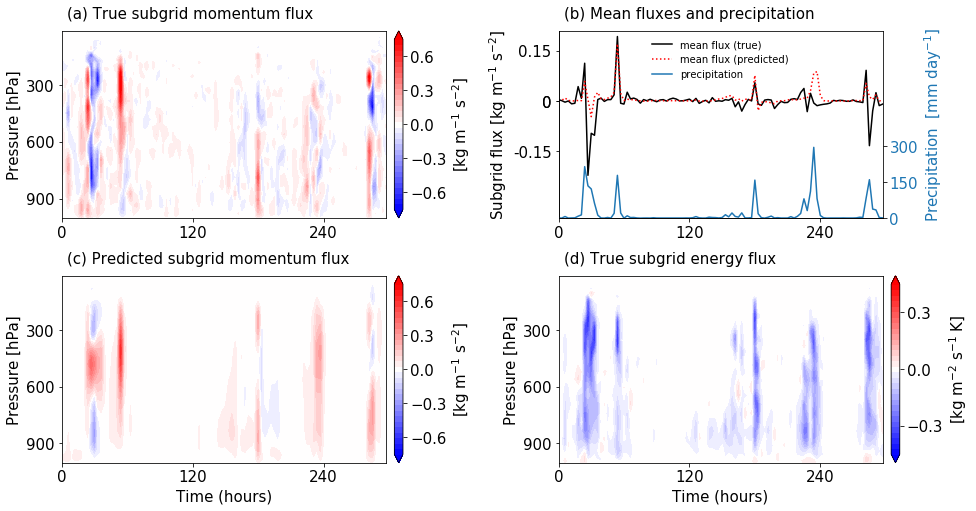

In [49]:
plot_sapshots_2x2_mom_energy_switch(true_u_flux,np.moveaxis(v_48_lev['Tadv'],3,1), pred_u_flux,true_u_flux_vert_mean,pred_u_flux_vert_mean,precip,p,y_i=96,
                                    save_flag=False,
                                    time_ind1=125,
                                    time_ind2=225,
                                    x_ind1=66,
              save_name1='momentum_precip_energy_vs_time_pressure_narrow_mean_vert_no_c_grid_all_new_updated',plot_trop=False,trop_p = [],flux_ticks_colorbarT = np.arange(-0.6,0.65,0.3),
                                   sat_fact = 1.0,range_momentum = 0.75,range_energy=0.45, precip_labels = [0,150, 300],
                                   flux_ticks_label=[0, -0.15, 0, 0.15],
                                   y_lim1 =-0.350, y_lim2 =0.21,
                                   letters = ["(a) True subgrid momentum flux","(b) Mean fluxes and precipitation",'(c) Predicted subgrid momentum flux','(d) True subgrid energy flux','','','','']
                                   )
#26,7,46,56


In [50]:
# plot_sapshots_2x2_mom_energy_switch(true_u_flux,np.moveaxis(v_48_lev['Tadv'],3,1), pred_u_flux,true_u_flux_vert_mean,pred_u_flux_vert_mean,precip,p,y_i=96,
#                                     save_flag=True,
#                                     time_ind1=125,
#                                     time_ind2=225,
#                                     x_ind1=66,
#               save_name1='momentum_precip_energy_vs_time_pressure_narrow_mean_vert_no_c_grid_all_new_ABS',plot_trop=False,trop_p = [],flux_ticks_colorbarT = np.arange(-0.6,0.65,0.3),
#                                    sat_fact = 1.0,range_momentum = 0.75,range_energy=0.45, precip_labels = [0,100, 200],
#                                    flux_ticks_label=[0, -0.15, 0, 0.15,0.3],
#                                    y_lim1 =-0.3000, y_lim2 =0.3500,
#                                    letters = ["(a) True absolute value subgrid momentum flux","(b) Mean fluxes and precipitation",'(c) Predicted absolute value subgrid momentum flux','(d) True subgrid energy flux','','','','']
#                                    )
# #26,7,46,56

(100,)
(47,)
(47, 100)


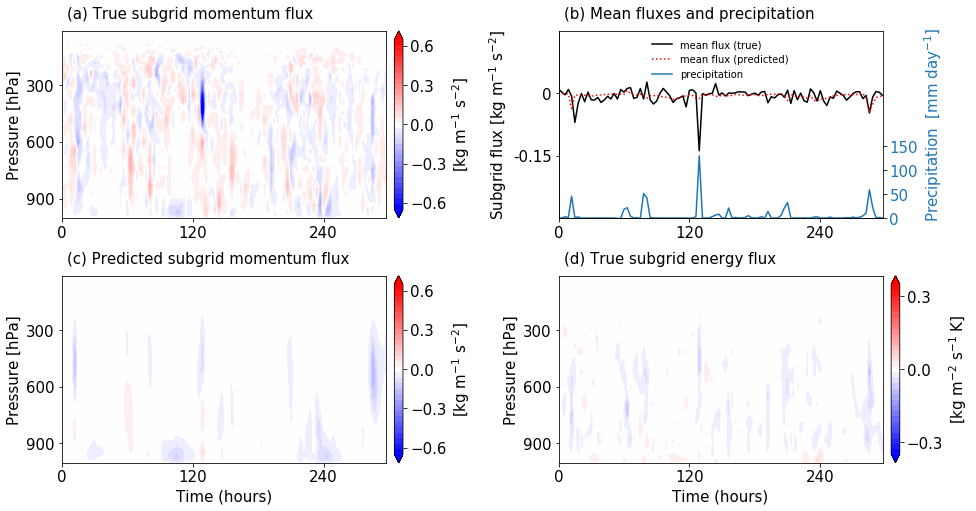

In [51]:
plot_sapshots_2x2_mom_energy_switch(true_u_flux,np.moveaxis(v_48_lev['Tadv'],3,1), 
                             pred_u_flux,true_u_flux_vert_mean,pred_u_flux_vert_mean,precip,p,
                             y_i=130,save_flag=False,
              save_name1='momentum_precip_energy_vs_time_pressure_narrow_mean_vert_no_c_grid_all_extra_5_layer_switch',
                             plot_trop=False,trop_p = [],flux_ticks_colorbarT = np.arange(-0.6,0.65,0.3),
                           flux_ticks_label = [-0.15, 0],
                            y_lim1 = -0.3, y_lim2 = 0.15, 
                            range_momentum = 0.65, range_energy =0.35,
                            time_ind1=125,
                            time_ind2=225,)
    


In [52]:
# plot_sapshots_2x2_mom_energy_switch(true_u_flux,np.moveaxis(v_48_lev['Tadv'],3,1), 
#                              pred_u_flux,true_u_flux_vert_mean,pred_u_flux_vert_mean,precip,p,
#                              y_i=130,save_flag=True,
#               save_name1='momentum_precip_energy_vs_time_pressure_narrow_mean_vert_no_c_grid_all_extra_5_layer_switch_updated',
#                              plot_trop=False,trop_p = [],flux_ticks_colorbarT = np.arange(-0.6,0.65,0.3),
#                            flux_ticks_label = [-0.15, 0],
#                             y_lim1 = -0.23, y_lim2 = 0.115, 
#                             range_momentum = 0.65, range_energy =0.35,precip_labels = [0,100, 200],
#                             time_ind1=125,
#                             time_ind2=225,)
    


# Comparing to Emanuel Scheme

In [39]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

          inv_output_pred_test:  5.4 GiB
          inv_output_true_test:  5.4 GiB
                    u_flux_ext:  2.4 GiB
                    v_flux_ext:  2.4 GiB
                        u_tend:  2.3 GiB
                        v_tend:  2.3 GiB
                   u_tend_pred:  2.3 GiB
                   v_tend_pred:  2.3 GiB
                   pred_coarse:  1.3 GiB
                   true_coarse:  1.3 GiB
                u_diff_200_vec:  1.2 GiB
                        precip: 49.5 MiB
                    u_diff_200: 24.8 MiB
                       r2_full: 156.2 KiB
                     rmse_full: 156.2 KiB
                     r2_coarse: 78.2 KiB
                   rmse_coarse: 78.2 KiB
                           _ii: 24.2 KiB
                          _i37: 24.2 KiB
                          _iii: 24.2 KiB


# Using Emanuel scheme with prescribed mass flux (taken at a constant level)

#### Choosing the mass flux to be at a constant level 7th level. 
#### Choosing the mass flux to be at the level that was diagnosed by the Emanuel scheme does not improve the results (and if tunning the mean momentum the results for the precipitatation are much worse)

#### I did some tunning. It seems that there are several combinations of CU + DAMP that can reach R^2~0.5. I chose DAMP (which controls the rescaling of the mass flux) to be 1.0 (such that the precipitation distribution) looks better, and CU = 0.6. 


In [40]:
# # R2 for NN for tendencies: 
# r2_u_tend = np.zeros((u_tend.shape[1],u_tend.shape[0]))
# r2_v_tend = np.zeros((u_tend.shape[1],u_tend.shape[0]))
# for zi in range(u_tend.shape[0]):
#     for timei in range(u_tend.shape[1]):
#         r2_u_tend[timei,zi] = r2_score(np.reshape(u_tend[zi,timei,:,:],-1),np.reshape(u_tend_pred[zi,timei,:,:],-1))
#         r2_v_tend[timei,zi] = r2_score(np.reshape(v_tend[zi,timei,:,:],-1),np.reshape(v_tend_pred[zi,timei,:,:],-1))

# Prescribed CBMF

In [41]:
## Getting data from the emanuel scheme:
# emanuel_name_pp = '/glade/work/janniy/Convection_1file_Kerry/param_search/Emanuel_perforamance_CU090_DAMP035_pressure_perturbation.pkl' # Only 30 levels
# emanuel_name_pp ='/glade/work/janniy/Convection_1file_Kerry/param_search/Emanuel_perforamance_CU085_DAMP040_pressure_perturbation_48_levels.pkl'#48 levels
# emanuel_name_pp ='/glade/work/janniy/Convection_1file_Kerry/param_search/Emanuel_perforamance_CU06_DAMP1_prescribe_CBMF.pkl'#48 levels
emanuel_name_pp ='/glade/work/janniy/Convection_1file_Kerry/param_search/Emanuel_perforamance_CU06_DAMP1_prescribe_CBMF_Aug_22.pkl'#48 levels

# emanuel_name_pp = '/glade/work/janniy/Convection_1file_Kerry/param_search/Emanuel_tendencies_CU085_DAMP040_pressure_perturbation_48_levels.pkl' #48 levels
with open(emanuel_name_pp, 'rb') as f:
    data_emanuel_pp = pickle.load(f)

In [42]:
data_emanuel_pp[0].keys()

dict_keys(['Emanuel_mean_u', 'Emanuel_mean_v', 'true_mean_u', 'true_mean_v', 'Emanuel_rSq_v', 'Emanuel_rSq_u'])

In [43]:
# R2 for NN for tendencies: 
r2_u_tend = np.zeros((u_tend.shape[1],u_tend.shape[0]))
r2_v_tend = np.zeros((u_tend.shape[1],u_tend.shape[0]))
for zi in range(u_tend.shape[0]):
    for timei in range(u_tend.shape[1]):
        r2_u_tend[timei,zi] = r2_score(np.reshape(u_tend[zi,timei,:,:],-1),np.reshape(u_tend_pred[zi,timei,:,:],-1))
        r2_v_tend[timei,zi] = r2_score(np.reshape(v_tend[zi,timei,:,:],-1),np.reshape(v_tend_pred[zi,timei,:,:],-1))

(48, 180)
(48,)
(180,)


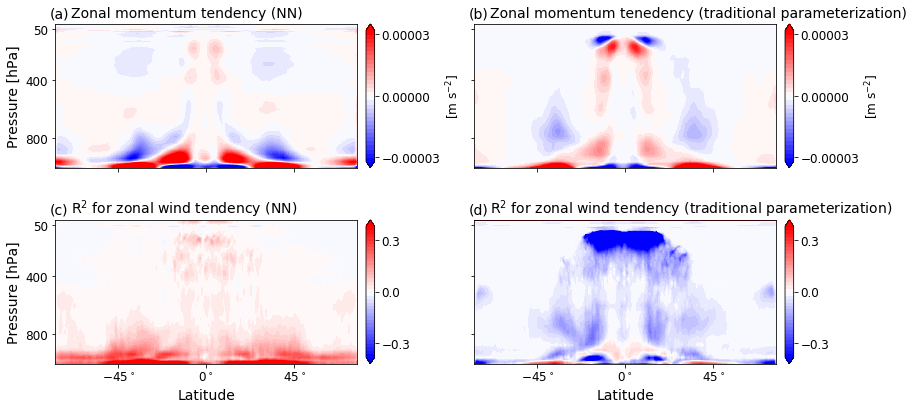

In [65]:
# trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,p,min_lev_trop_ind=10)
plot_mean_4_fields_production(np.mean(np.moveaxis(u_tend_pred,0,2),axis = (1,3))[:,0:],
                              r2_u_tend[:,:],
                              data_emanuel_pp[0]['Emanuel_mean_u'].T,
                              data_emanuel_pp[0]['Emanuel_rSq_u'].T,
                              y,indices,p[0:],save = True, save_name = "Emanuel_vs_NN_U_pressure_perturbation_48_levels_CU06_DAMP1_prescribe_CBMF_Aug_22",with_trop=False,trop_p = 0,
                              plot_shear=False, shear = [], colorbar_costum_scale = True, 
                              color4 = np.arange(-0.38,0.39,0.02),
                              color4_ticks = [-0.3,0,0.3],
                              color2 = np.arange(-0.000032,0.000033,0.000002),
                              color2_ticks = [-0.00003,0,0.00003],
                              color3 = np.arange(-0.38,0.39,0.02),
                              color3_ticks = [-0.3,0,0.3],
                              color1 = np.arange(-0.000032,0.000033,0.000002),
                              color1_ticks = [-0.00003,0,0.00003],
                              label1='[m s$^{-2}$]',
                              label2='[m s$^{-2}$]',
                              label3='',
                              label4='',
                              headers = [r"Zonal momentum tendency (NN)",r"Zonal momentum tenedency (traditional parameterization)",r"R$^2$ for zonal wind tendency (NN)",r"R$^2$ for zonal wind tendency (traditional parameterization)",r"Emanuel R^2",r"Emanuel zonal wind tendency R^2"])




(48, 180)
(48,)
(180,)


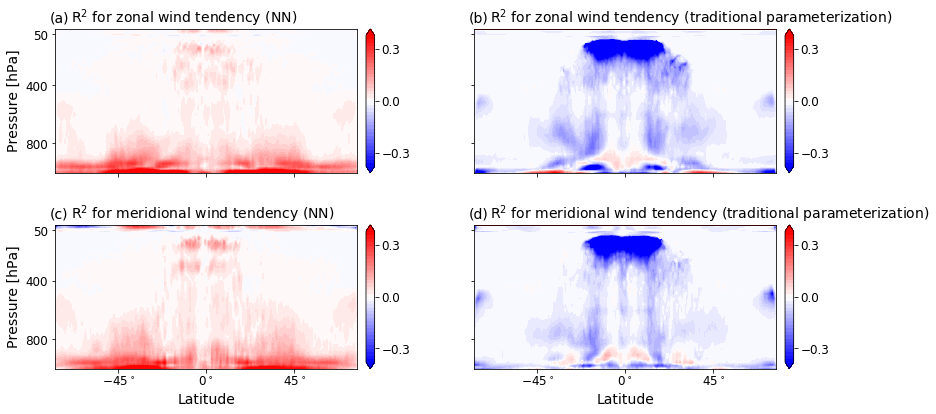

In [66]:
trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,p,min_lev_trop_ind=10)
plot_mean_4_fields_production(r2_u_tend,
                              r2_v_tend[:,:],
                              data_emanuel_pp[0]['Emanuel_rSq_u'].T,
                              data_emanuel_pp[0]['Emanuel_rSq_v'].T,
                              y,indices,p[0:],save = True, save_name = "Emanuel_vs_NN_Rsq_tendency_pressure_perturbation_48_levels_CU06_DAMP1_prescribe_CBMF_Aug_22",with_trop=False,trop_p = trop_p,
                              plot_shear=False, shear = [], colorbar_costum_scale = True, 
                              color4 = np.arange(-0.38,0.39,0.02),
                              color4_ticks = [-0.3,0,0.3],
                              color2 = np.arange(-0.38,0.39,0.02),
                              color2_ticks = [-0.3,0,0.3],
                              color3 = np.arange(-0.38,0.39,0.02),
                              color3_ticks = [-0.3,0,0.3],
                              color1 = np.arange(-0.38,0.39,0.02),
                              color1_ticks = [-0.3,0,0.3],
                              label1='',
                              label2='',
                              label3='',
                              label4='',
                              headers = [r"R$^2$ for zonal wind tendency (NN)",r"R$^2$ for zonal wind tendency (traditional parameterization)",r"R$^2$ for meridional wind tendency (NN)",r"R$^2$ for meridional wind tendency (traditional parameterization)",r"Emanuel R^2",r"Emanuel zonal wind tendency R^2"])




(48, 180)
(48,)
(180,)


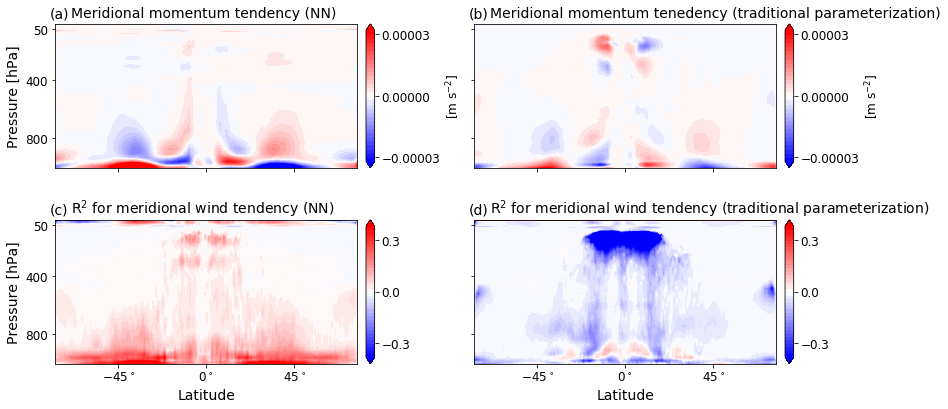

In [67]:
trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,p,min_lev_trop_ind=10)
plot_mean_4_fields_production(np.mean(np.moveaxis(v_tend_pred,0,2),axis = (1,3))[:,0:],
                              r2_v_tend[:,:],
                              data_emanuel_pp[0]['Emanuel_mean_v'].T,
                              data_emanuel_pp[0]['Emanuel_rSq_v'].T,
                              y,indices,p[0:],save = True, save_name = "Emanuel_vs_NN_V_pressure_perturbation_48_levels_CU06_DAMP1_prescribe_CBMF_Aug_22",with_trop=False,trop_p = trop_p,
                              plot_shear=False, shear = [], colorbar_costum_scale = True, 
                              color4 = np.arange(-0.38,0.39,0.02),
                              color4_ticks = [-0.3,0,0.3],
                              color2 = np.arange(-0.000032,0.000033,0.000002),
                              color2_ticks = [-0.00003,0,0.00003],
                              color3 = np.arange(-0.38,0.39,0.02),
                              color3_ticks = [-0.3,0,0.3],
                              color1 = np.arange(-0.000032,0.000033,0.000002),
                              color1_ticks = [-0.00003,0,0.00003],
                              label1='[m s$^{-2}$]',
                              label2='[m s$^{-2}$]',
                              label3='',
                              label4='',
                              headers = [r"Meridional momentum tendency (NN)",r"Meridional momentum tenedency (traditional parameterization)",r"R$^2$ for meridional wind tendency (NN)",r"R$^2$ for meridional wind tendency (traditional parameterization)",r"Emanuel R^2",r"Emanuel zonal wind tendency R^2"])




In [72]:
# rho_dz = vertical_diff(rho, z)
# zu_adv_flux_Em = np.zeros((data_emanuel[0]['Emanuel_mean_v'].shape[0]+1,data_emanuel[0]['Emanuel_mean_v'].shape[1])) #need 49 levels for the flux. The first and last will be zero...
# zv_adv_flux_Em = np.zeros((data_emanuel[0]['Emanuel_mean_v'].shape[0]+1,data_emanuel[0]['Emanuel_mean_v'].shape[1])) #need 49 levels for the flux. The first and last will be zero...

# for k in range(0, zu_adv_flux_Em.shape[0] - 1):
#     zu_adv_flux_Em[k + 1,  :] = zu_adv_flux_Em[k, :] - data_emanuel[0]['Emanuel_mean_u'][k, :] * rho_dz[k]
#     zv_adv_flux_Em[k + 1,  :] = zv_adv_flux_Em[k, :] - data_emanuel[0]['Emanuel_mean_v'][k, :] * rho_dz[k]

# # zu_tend_out = zu_tend_out + zu_adv_flux[0:-1,:,:] # Ignore the upper level which should be zero (TO VERIFY)
# # zv_tend_out = zv_tend_out + zv_adv_flux[0:-1,:,:] # Ignore the upper level which should be zero (TO VERIFY)

In [52]:
#Calc flux from Emanuel mean tendencies
rho_dz = vertical_diff(rho, z)
zu_adv_flux_Em_pp = np.zeros((data_emanuel_pp[0]['Emanuel_mean_v'].shape[0]+1,data_emanuel_pp[0]['Emanuel_mean_v'].shape[1])) #need 49 levels for the flux. The first and last will be zero...
zv_adv_flux_Em_pp = np.zeros((data_emanuel_pp[0]['Emanuel_mean_v'].shape[0]+1,data_emanuel_pp[0]['Emanuel_mean_v'].shape[1])) #need 49 levels for the flux. The first and last will be zero...

for k in range(0, zu_adv_flux_Em_pp.shape[0] - 1):
    zu_adv_flux_Em_pp[k + 1,  :] = zu_adv_flux_Em_pp[k, :] - data_emanuel_pp[0]['Emanuel_mean_u'][k, :] * rho_dz[k]
    zv_adv_flux_Em_pp[k + 1,  :] = zv_adv_flux_Em_pp[k, :] - data_emanuel_pp[0]['Emanuel_mean_v'][k, :] * rho_dz[k]

# zu_tend_out = zu_tend_out + zu_adv_flux[0:-1,:,:] # Ignore the upper level which should be zero (TO VERIFY)
# zv_tend_out = zv_tend_out + zv_adv_flux[0:-1,:,:] # Ignore the upper level which should be zero (TO VERIFY)

In [53]:
#Get tendencies from Emanuel
# emanuel_name_tend = '/glade/work/janniy/Convection_1file_Kerry/param_search/Emanuel_tendencies_CU090_DAMP035_pressure_perturbation.pkl' #30 levels
# emanuel_name_tend = '/glade/work/janniy/Convection_1file_Kerry/param_search/Emanuel_tendencies_CU085_DAMP040_pressure_perturbation_48_levels.pkl' #48 levels
emanuel_name_tend = '/glade/work/janniy/Convection_1file_Kerry/param_search/Emanuel_tendencies_precip_CU06_DAMP1_prescribe_mass_flux_Aug_22.pkl'
with open(emanuel_name_tend, 'rb') as f:
    emanuel_name_tend = pickle.load(f)
    

In [54]:
#Calc flux from Emanuel mean tendencies
rho_dz = vertical_diff(rho, z)
zu_adv_flux_Em_pp_time = np.zeros((emanuel_name_tend[0]['Emanuel_tend_u'].shape[0]+1,emanuel_name_tend[0]['Emanuel_tend_u'].shape[1],emanuel_name_tend[0]['Emanuel_tend_u'].shape[2],emanuel_name_tend[0]['Emanuel_tend_u'].shape[3])) #need 49 levels for the flux. The first and last will be zero...
zv_adv_flux_Em_pp_time = np.zeros((emanuel_name_tend[0]['Emanuel_tend_u'].shape[0]+1,emanuel_name_tend[0]['Emanuel_tend_u'].shape[1],emanuel_name_tend[0]['Emanuel_tend_u'].shape[2],emanuel_name_tend[0]['Emanuel_tend_u'].shape[3])) #need 49 levels for the flux. The first and last will be zero...

zq_adv_flux_Em_pp_time = np.zeros((emanuel_name_tend[0]['Emanuel_tend_u'].shape[0]+1,emanuel_name_tend[0]['Emanuel_tend_u'].shape[1],emanuel_name_tend[0]['Emanuel_tend_u'].shape[2],emanuel_name_tend[0]['Emanuel_tend_u'].shape[3])) #need 49 levels for the flux. The first and last will be zero...
zT_adv_flux_Em_pp_time = np.zeros((emanuel_name_tend[0]['Emanuel_tend_u'].shape[0]+1,emanuel_name_tend[0]['Emanuel_tend_u'].shape[1],emanuel_name_tend[0]['Emanuel_tend_u'].shape[2],emanuel_name_tend[0]['Emanuel_tend_u'].shape[3])) #need 49 levels for the flux. The first and last will be zero...

for k in range(0, zu_adv_flux_Em_pp_time.shape[0] - 1):
    zu_adv_flux_Em_pp_time[k + 1,  :,:,:] = zu_adv_flux_Em_pp_time[k, :,:,:] - emanuel_name_tend[0]['Emanuel_tend_u'][k, :,:,:] * rho_dz[k]
    zv_adv_flux_Em_pp_time[k + 1,  :,:,:] = zv_adv_flux_Em_pp_time[k, :,:,:] - emanuel_name_tend[0]['Emanuel_tend_v'][k, :,:,:] * rho_dz[k]
    zq_adv_flux_Em_pp_time[k + 1,  :,:,:] = zq_adv_flux_Em_pp_time[k, :,:,:] - emanuel_name_tend[0]['Emanuel_tend_q'][k, :,:,:] * rho_dz[k]
    zT_adv_flux_Em_pp_time[k + 1,  :,:,:] = zT_adv_flux_Em_pp_time[k, :,:,:] - emanuel_name_tend[0]['Emanuel_tend_T'][k, :,:,:] * rho_dz[k]


In [72]:
indices = np.zeros(len(output_vert_dim)+1)
for ind, val in zip(range(len(output_vert_dim)),output_vert_dim):
    indices[ind + 1] = indices[ind] + val

In [82]:
# trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,p,min_lev_trop_ind=10)
# plot_mean_4_fields_production(np.mean(np.moveaxis(inv_output_true_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
#                               r2_v_tend[:,:47],
#                               zu_adv_flux_Em_pp.T[:,:47],
#                               data_emanuel_pp[0]['Emanuel_rSq_u'].T,
#                               y,indices,p[0:],save = True, save_name = "NN_predicted_fluxes_vs_emanuel_predicted_and_Rsq_PP_48_levels_CU06_DAMP1_prescribe_CBMF",with_trop=False,trop_p = trop_p,
#                               plot_shear=False, shear = [], colorbar_costum_scale = True, 
#                               color4 = np.arange(-0.38,0.39,0.02),
#                               color4_ticks = [-0.3,0,0.3],
#                               color2 = np.arange(-0.032,0.033,0.002),
#                               color2_ticks = [-0.03,0,0.03],
#                               color3 = np.arange(-0.38,0.39,0.02),
#                               color3_ticks = [-0.3,0,0.3],
#                               color1 = np.arange(-0.032,0.033,0.002),
#                               color1_ticks = [-0.03,0,0.03],
#                               label1='[m s$^{-2}$]',
#                               label2='[m s$^{-2}$]',
#                               label3='',
#                               label4='',
#                               headers = [r"NN Predicted meridional momentum subgrid tendency",r"Emanuel predicted meridional momentum subgrid tenedencies",r"R$^2$ -NN zonal wind tendency",r"$R^2$ - Emanuel zonal wind tendency",r"Emanuel R^2",r"Emanuel zonal wind tendency R^2"])




In [73]:
def plot_mean_6_2Dfields_2_1D_production(Field,Field2,Field3,Field4,Field5,Field6,y,indices,p, precip_mean_trop,
                                         seager_param, true_out_xt_avg, pred_out_xt_avg, pearson_lev = 11200,save=0,
                                         save_name = 'del',with_trop=False,trop_p =np.zeros(180),
                                 plot_shear = False, shear = [],colorbar_costum_scale = False, 
                                  color1 = [], color1_ticks =[], color2 =[],color2_ticks =[],
                                  color3 = [], color3_ticks =[], color4 =[],color4_ticks =[],
                                  color4_ticks_label=[],
                                  label1 = r'[kg m$^{-1}$ s$^{-2}$]', label2 = r'[m s$^{-2}$]', label3 = r'[kg m$^{-1}$ s$^{-2}$]', label4 = r'[m s$^{-2}$]',
                                    precip_cutoff = 0,
                                    headers = [r"Zonal momentum subgrid flux",
                                               r"Zonal momentum subgrid tendency",
                                               r"Meridional momentum subgrid flux",
                                               r"Meridional momentum subgrid tendency",
                                               r"Moisture surface subgrid flux",
                                               r"diffusivity RF","","",""]
                                 ):
    
    letters = ["(a)","(b)","(c)","(d)","(e)",'(f)',"(g)","(h)",'(i)']
#     headers = [r"Zonal momentum subgrid flux",r"Zonal momentum subgrid tendency",r"Meridional momentum subgrid flux",r"Meridional momentum subgrid tendency",r"Moisture surface subgrid flux",r"diffusivity RF"]

    y_plot = (y - np.mean(y))/10**6
    ticks_lat = [-5,0,5]
    
    ticks_press_tkz = [1000,800,600]
#     ticks_press = [900,600,300]
    ticks_press = [800,400,50]

    if colorbar_costum_scale:
        lev_Rsq = color1
        lev_Rsq_ticks = color1_ticks
        lev_Rsq3 = color3
        lev_Rsq_ticks3 = color3_ticks
    else:
        lev_Rsq = np.arange(-0.04, 0.041, 0.002) 
        lev_Rsq_ticks = np.arange(-0.03, 0.031, 0.02) 
        lev_Rsq3 = lev_Rsq
        lev_Rsq_ticks3 = lev_Rsq
    if colorbar_costum_scale:
        lev_Rsq2 = color2
        lev_Rsq_ticks2 = color2_ticks
        lev_Rsq4 = color4
        lev_Rsq_ticks4 = color4_ticks
    else:
        lev_Rsq2 = np.arange(-0.00004, 0.000041, 0.000002) 
        lev_Rsq_ticks2 = np.arange(-0.00003, 0.000031, 0.00002) 
        lev_Rsq4 = lev_Rsq2
        lev_Rsq_ticks4 = lev_Rsq2

#     ticks_press_R2 = [-0.006,-0.003, 0,0.003,0.006] #np.arange(-0.0075, 0.00751, 0.005)
    
    cont_min_rsq = 0
    cont_max_rsq = 1
    
    fontsize = 14
    fontsize_legend = 8
    h_width = 0.1
    v_width = 0.1
    h_width_cbar = 0.02
    colorbar_width =0.02

    p_lev_diff = 15
    
    row_dim = 3
    col_dim = 3

    fig_witdth = 0.7
    fig_height = 0.5
    fig_h_dist = 0.27
    fig_v_dist = 0.22
    
    size1 = 2
    fig, axes = plt.subplots(row_dim,col_dim)
    # fig.set_figheight(10)
    # fig.set_figwidth(10)
    upper_level_p = 48
    lowest_level = 0
    cmap1 = 'bwr'
    n=30
    yind1 = 65
    x_ind1 = 10
    # wnumber = 1
    ind_ind = 0
    
    
    x0 = axes[0,0].get_position().x0
    x1 = axes[0,0].get_position().x1
    y0 = axes[0,0].get_position().y0
    y1 = axes[0,0].get_position().y1

    for i in range(row_dim):
        for j  in range(col_dim):
            if i == 0 and j == 1:
                axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth/1.0,fig_height])
            else:    
                axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth,fig_height])
    
        
    levels = lev_Rsq
    i = 0
    print(Field.T.shape)
    print(p[0:Field.shape[1]].shape)
    print(y_plot.shape)
    cax_xy1 =axes[i,0].contourf(y_plot,p[0:Field.shape[1]],Field.T,levels = levels,cmap=cmap1, extend="both")
    axes[i, 0].set_ylim(np.amax(p[:]), np.amin(p[0:Field.shape[1]]))
    pos1_rsq = axes[i, 0].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=lev_Rsq_ticks)
#     cbar_rsq.ax.set_xlabel(r'kg m$^{-2}$ s$^{-1}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
#     cbar_rsq.set_label(r'[kg m$^{-1}$ s$^{-2}$]', rotation=90,fontsize=fontsize-2)
    cbar_rsq.set_label(label1, rotation=90,fontsize=fontsize-2)
    
    if plot_shear:
#         lev_shear_cont =np.arange(-0.026,0.026,0.002)# [0,100,200,300,400,500,600,700]
        lev_shear_cont = [-0.01,-0.003,0.003,0.01]
        cax_q_Rsq = axes[i, 0].contour(y_plot, p[0:shear.shape[0]], shear,lev_shear_cont,colors='k')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
        axes[i, 0].set_ylim(np.amax(p), np.amin(p))
        # axes[1,0].clabel(cax_q_Rsq,cax_q_Rsq.levels[::6],fmt = '%1.0f', inline=1, fontsize=fontsize_cont1)
#         axes[i,0].clabel(cax_q_Rsq,lev_shear_cont[13],fmt = '%1.0f', inline=1, fontsize=fontsize-2)
        lev_shear_cont = [0]
        cax_q_Rsq = axes[i, 0].contour(y_plot, p[0:shear.shape[0]], shear,lev_shear_cont,colors='k')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
        axes[i, 0].set_ylim(np.amax(p), np.amin(p))
        cax_q_Rsq.collections[0].set_linewidth(2) 

    
    levels = lev_Rsq3
    i = 1
    cax_xy1 =axes[i,0].contourf(y_plot,p[0:Field2.shape[1]],Field2.T,levels = levels,cmap=cmap1, extend="both")
    axes[i, 0].set_ylim(np.amax(p[:]), np.amin(p[0:Field2.shape[1]]))
    pos1_rsq = axes[i, 0].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=lev_Rsq_ticks3)
#     cbar_rsq.ax.set_xlabel(r'kg m$^{-2}$ s$^{-1}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
    cbar_rsq.set_label(label3, rotation=90,fontsize=fontsize-2)
    cbar_rsq.ax.set_yticklabels(color4_ticks_label)
    
    levels = lev_Rsq2
    i = 1
    cax_xy1 =axes[0,i].contourf(y_plot,p[0:Field3.shape[1]],Field3.T,levels = levels,cmap=cmap1, extend="both")
    axes[0, i].set_ylim(np.amax(p[:]), np.amin(p[0:Field3.shape[1]]))
    pos1_rsq = axes[0, i].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[0,i], shrink=1.0,ticks=lev_Rsq_ticks2)
#     cbar_rsq.ax.set_xlabel(r'm s$^{-2}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
    cbar_rsq.set_label(label2, rotation=90,fontsize=fontsize-2)

#     levels = lev_Rsq2
    i = 2
    cax_xy1 =axes[0,i].contourf(y_plot,p[0:Field5.shape[1]],Field5.T,levels = levels,cmap=cmap1, extend="both")
    axes[0, i].set_ylim(np.amax(p[:]), np.amin(p[0:Field3.shape[1]]))
    pos1_rsq = axes[0, i].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[0,i], shrink=1.0,ticks=lev_Rsq_ticks2)
#     cbar_rsq.ax.set_xlabel(r'm s$^{-2}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
    cbar_rsq.set_label(label2, rotation=90,fontsize=fontsize-2)
    
    levels = lev_Rsq4
    i = 1
    cax_xy1 =axes[1,i].contourf(y_plot,p[0:Field4.shape[1]],Field4.T,levels = levels,cmap=cmap1, extend="both")
    axes[1, i].set_ylim(np.amax(p[:]), np.amin(p[0:Field4.shape[1]]))
    pos1_rsq = axes[1, i].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[1,i], shrink=1.0,ticks=lev_Rsq_ticks4)
    cbar_rsq.ax.set_yticklabels(color4_ticks_label)
#     cbar_rsq.ax.set_xlabel(r'm s$^{-2}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
    cbar_rsq.set_label(label4, rotation=90,fontsize=fontsize-2)

    i = 2
#     print(Field6.T.shape)
#     print(p[0:Field6.shape[1]].shape)
#     print(y_plot.shape)
    cax_xy1 =axes[1,i].contourf(y_plot,p[0:Field6.shape[1]],Field6.T,levels = levels,cmap=cmap1, extend="both")
    axes[1, i].set_ylim(np.amax(p[:]), np.amin(p[0:Field4.shape[1]]))
    pos1_rsq = axes[1, i].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[1,i], shrink=1.0,ticks=lev_Rsq_ticks4)
    cbar_rsq.ax.set_yticklabels(color4_ticks_label)
#     cbar_rsq.ax.set_xlabel(r'm s$^{-2}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
    cbar_rsq.set_label(label4, rotation=90,fontsize=fontsize-2)
    
    if with_trop:
        axes[0,0].plot(y_plot,trop_p,':k')
        axes[1,0].plot(y_plot,trop_p,':k')
        axes[0,1].plot(y_plot,trop_p,':k')
        axes[1,1].plot(y_plot,trop_p,':k')
    
    ind_let = 0
    for i in range(row_dim):
        for j  in range(col_dim):
            atext2 = axes[i, j].text(axes[0,0].get_position().x0*0.9+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.7- (i-1)*fig_height - (i-1)*fig_v_dist ,letters[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)

            header= axes[i, j].text(axes[0,0].get_position().x0*1.3+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.7- (i-1)*fig_height - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
            ind_let = ind_let + 1

            
            
            
    axes[0, 0].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[1, 0].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[2, 0].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[0, 1].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[1, 1].set_xlim(np.amin(y_plot), np.amax(y_plot))
    


    axes[0, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
    axes[1, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
#     axes[2, 0].set_ylabel(r'kg m$^{-2}$ s$^{-1}$',fontsize=fontsize)
#     axes[1, 1].set_ylabel(r'kg m$^{-2}$ s$^{-1}$',fontsize=fontsize)


# axes[2, 0].set_xlabel('y [$10^3$ km]',fontsize=fontsize)
# axes[1, 1].set_xlabel('y [$10^3$ km]',fontsize=fontsize)


    axes[1, 0].set_xlabel('Latitude',fontsize=fontsize)
    axes[1, 1].set_xlabel('Latitude',fontsize=fontsize)
    axes[1, 2].set_xlabel('Latitude',fontsize=fontsize)
    
    fontsize_ticks = fontsize -2  
    ticks_lat_degrees = ['$-45^\circ$','$0^\circ$','$45^\circ$']
#     axes[1, 1].set_yticks(ticks_press_R2)
#     axes[1, 1].set_yticklabels(ticks_press_R2,fontsize=fontsize_ticks)
#     axes[2, 0].set_yticks(ticks_press_R2)
#     axes[2, 0].set_yticklabels(ticks_press_R2,fontsize=fontsize_ticks)

#     axes[2, 0].set_xticks(ticks_lat)
#     axes[2, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
#     axes[1, 1].set_xticks(ticks_lat)
#     axes[1, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
     
    axes[0, 0].set_xticks(ticks_lat)
    axes[0, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    axes[1, 0].set_xticks(ticks_lat)
    axes[1, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
   

    axes[0, 1].set_xticks(ticks_lat)
    axes[0, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    
    axes[0, 0].set_yticks(ticks_press)
    axes[0, 0].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
    
    axes[1, 0].set_yticks(ticks_press)
    axes[1, 0].set_yticklabels(ticks_press,fontsize=fontsize_ticks)

    axes[0, 1].set_yticks(ticks_press)
    axes[0, 1].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
    axes[1, 1].set_yticks(ticks_press)
    axes[1, 1].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
  
    axes[1, 2].set_yticks(ticks_press)
    axes[1, 2].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
    axes[0, 2].set_yticks(ticks_press)
    axes[0, 2].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
  

    axes[1, 1].set_xticks(ticks_lat)
    axes[1, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)

    axes[1, 2].set_xticks(ticks_lat)
    axes[1, 2].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    axes[0, 2].set_xticks(ticks_lat)
    axes[0, 2].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    
    
#     axes[2, 0].set_xticks(ticks_lat)
#     axes[2, 0].set_xticklabels([])

#     fig.delaxes(axes[2,1])
#     fig.delaxes(axes[2,0])
  
    true_range1 = -0.0000028
    true_range2 = 0.0000075

    true_ticks = [0,0.000003,0.000006]

    mm_rain = 0
#     corr_paramet, _ = pearsonr(seager_param[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])
    corr_paramet, _ = pearsonr(seager_param[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
#     corr_paramet_RF, _ = pearsonr(true_out_xt_avg[precip_mean_trop>2],pred_out_xt_avg[precip_mean_trop>2])
    corr_paramet_RF, _ = pearsonr(np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff],np.reshape(pred_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
    slope, intercept, r_value, p_value, std_err = stats.linregress(seager_param[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])

    slope_no_intercept, _, _, _ = np.linalg.lstsq(seager_param[precip_mean_trop>precip_cutoff,None],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff]) 
    # = stats.linregress(seager_param[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])


    marker1 = 100
    markers_style = ['x','^','o']

    colors1 = ['red','black','blue','green']
    cax_mean_online2 =axes[2,0].scatter(seager_param[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
    axes[2,0].set_xlim(-75, 50)
    axes[2,0].set_ylim(true_range1, true_range2)
    cax_mean_online3 = axes[2,1].scatter(np.reshape(pred_out_xt_avg,-1)[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
    axes[2,1].set_xlim(true_range1, true_range2)
    axes[2,1].set_ylim(true_range1, true_range2)

    axes[2, 1].set_xticks(true_ticks)
    axes[2, 1].set_xticklabels(true_ticks,fontsize=fontsize)
    axes[2, 1].set_yticks(true_ticks)
    axes[2, 1].set_yticklabels(true_ticks,fontsize=fontsize)

    axes[2, 0].set_yticks(true_ticks)
    axes[2, 0].set_yticklabels(true_ticks,fontsize=fontsize)
    axes[2, 0].set_xticks([-80,-40,0,40])
    axes[2, 0].set_xticklabels([-80,-40,0,40],fontsize=fontsize)

    
    axes[2, 1].set_xlabel('NN prediction @ (' + "{:.1f}".format(pearson_lev/1000) + 'km)' + '[m s$^{-2}$]',fontsize=fontsize)
    axes[2, 0].set_xlabel(r'Prec*(u(0.6km)- u(' + "{:.1f}".format(pearson_lev/1000) + 'km)' + '[mm day$^{-1}$ m s$^{-1}$]' ,fontsize=fontsize)
    axes[2, 0].set_ylabel(r'True u tend @ (' + "{:.1f}".format(pearson_lev/1000) + 'km)' + r'[m s$^{-2}$]',fontsize=fontsize)
    axes[2, 0].text(0, 0, 'r:' + str(round(corr_paramet,3)),fontsize=fontsize)
    axes[2, 0].text(0, 0-0.0000014, 'slope:' + "{:.2e}".format(slope_no_intercept[0]),fontsize=fontsize)
    axes[2, 1].text(4e-6, 0, 'r:' + str(round(corr_paramet_RF,3)),fontsize=fontsize)

    axes[2,0].spines["top"].set_visible(False)
    axes[2,0].spines["right"].set_visible(False)
    axes[2,1].spines["top"].set_visible(False)
    axes[2,1].spines["right"].set_visible(False)
    fig.delaxes(axes[2,2])

    if save:
        save_path = '/glade/work/janniy/data_for_offline_momentum_paper/plots/'
        plt.savefig(save_path+ save_name +'.eps', format='eps', bbox_inches="tight")
        
#         from matplotlib.ticker import PercentFormatter

# #         data = [1000, 1000, 5000, 3000, 4000, 16000, 2000]

# #         axes[3,0].hist(np.reshape(field1,-1), weights=np.ones(np.reshape(field1,-1).shape) / np.reshape(field1,-1).shape,bins = 1000)
# #         axes[3,1].hist(np.reshape(field2,-1), weights=np.ones(np.reshape(field2,-1).shape) / np.reshape(field2,-1).shape,bins = 1000)

# #         axes[3,0].gca().yaxis.set_major_formatter(PercentFormatter(1))
    

(47, 180)
(47,)
(180,)


/glade/work/janniy/python_ncar_env/lib/python3.6/site-packages/ipykernel_launcher.py:296: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


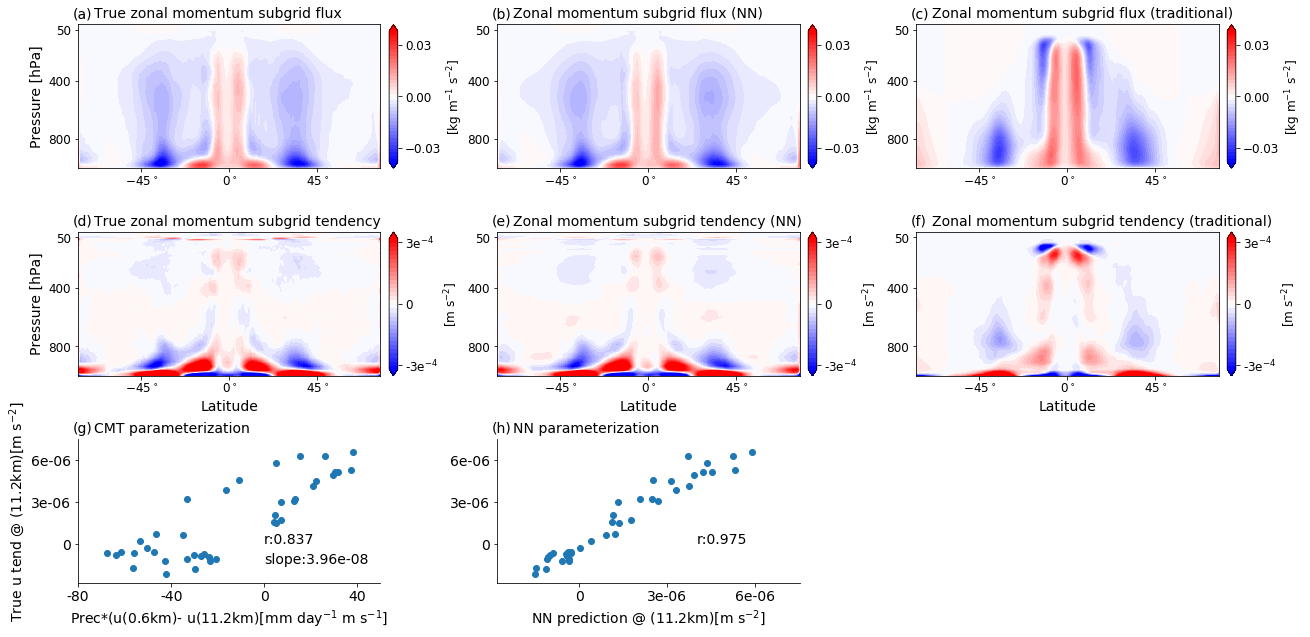

In [74]:
# trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,min_lev_trop_ind=10)
plot_mean_6_2Dfields_2_1D_production(np.mean(np.moveaxis(inv_output_true_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(u_tend,0,2),axis = (1,3)),
                              np.mean(np.moveaxis(inv_output_pred_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(u_tend_pred,0,2),axis = (1,3)),
                              zu_adv_flux_Em_pp.T[:,:47],
                              data_emanuel_pp[0]['Emanuel_mean_u'].T,
                              y,indices,p, precip_mean_trop,
                              seager_param, true_out_xt_avg, pred_out_xt_avg, pearson_lev = z[zlevel],
#                               save = True, save_name = "u_flux_TEND_true_and_pred_x8_no_c_grid_with_seager_501snapshots_with_shear",with_trop=False,trop_p = trop_p,
                              save = True, save_name = "mean_Flux_tend_Emanuel_vs_true_vs_NN_PP_48_levels_CU06_DAMP1_prescribe_CBMF_Aug_22",with_trop=False,trop_p = [],
                              plot_shear=False, shear = dU_dz, colorbar_costum_scale = True, 
                              color1 = np.arange(-0.038,0.039,0.002),
                              color1_ticks = [-0.03,0,0.03],
                              color3 = np.arange(-0.000032,0.000033,0.000002),
                              color3_ticks = [-0.00003,0,0.00003],
#                               color3 = np.arange(-0.000120,0.000131,0.00001),
#                               color3_ticks = [-0.00008,0,0.00008],
                              color2 = np.arange(-0.038,0.039,0.002),
                              color2_ticks = [-0.03,0,0.03],
                              color4 = np.arange(-0.000032,0.000033,0.000002),
                              color4_ticks = [-0.00003,0,0.00003],
                              color4_ticks_label = [r'-3e$^{-4}$','0',r'3e$^{-4}$'],
#                               color4 = np.arange(-0.000120,0.000131,0.00001),
#                               color4_ticks = [-0.00008,0,0.00008],
                                     label1='[kg m$^{-1}$ s$^{-2}$]',label3='[m s$^{-2}$]',
                                     label2='[kg m$^{-1}$ s$^{-2}$]',label4='[m s$^{-2}$]',
                             headers = [r"True zonal momentum subgrid flux",r"Zonal momentum subgrid flux (NN)",r"Zonal momentum subgrid flux (traditional)",r"True zonal momentum subgrid tendency",r"Zonal momentum subgrid tendency (NN)",r"Zonal momentum subgrid tendency (traditional)",r"CMT parameterization",r"NN parameterization","","",""])
    


In [75]:
def plot_mean_6_2Dfields_production(Field,Field2,Field3,Field4,Field5,Field6,y,indices,p, precip_mean_trop,
                                         seager_param, true_out_xt_avg, pred_out_xt_avg, pearson_lev = 11200,save=0,
                                         save_name = 'del',with_trop=False,trop_p =np.zeros(180),
                                 plot_shear = False, shear = [],colorbar_costum_scale = False, 
                                  color1 = [], color1_ticks =[], color2 =[],color2_ticks =[],
                                  color3 = [], color3_ticks =[], color4 =[],color4_ticks =[],
                                  color4_ticks_label=[],
                                  label1 = r'[kg m$^{-1}$ s$^{-2}$]', label2 = r'[m s$^{-2}$]', label3 = r'[kg m$^{-1}$ s$^{-2}$]', label4 = r'[m s$^{-2}$]',
                                    precip_cutoff = 0,
                                    headers = [r"Zonal momentum subgrid flux",
                                               r"Zonal momentum subgrid tendency",
                                               r"Meridional momentum subgrid flux",
                                               r"Meridional momentum subgrid tendency",
                                               r"Moisture surface subgrid flux",
                                               r"diffusivity RF","","",""]
                                 ):
    
    letters = ["(a)","(b)","(c)","(d)","(e)",'(f)',"(g)","(h)",'(i)']
#     headers = [r"Zonal momentum subgrid flux",r"Zonal momentum subgrid tendency",r"Meridional momentum subgrid flux",r"Meridional momentum subgrid tendency",r"Moisture surface subgrid flux",r"diffusivity RF"]

    y_plot = (y - np.mean(y))/10**6
    ticks_lat = [-5,0,5]
    
    ticks_press_tkz = [1000,800,600]
#     ticks_press = [900,600,300]
    ticks_press = [800,400,50]

    if colorbar_costum_scale:
        lev_Rsq = color1
        lev_Rsq_ticks = color1_ticks
        lev_Rsq3 = color3
        lev_Rsq_ticks3 = color3_ticks
    else:
        lev_Rsq = np.arange(-0.04, 0.041, 0.002) 
        lev_Rsq_ticks = np.arange(-0.03, 0.031, 0.02) 
        lev_Rsq3 = lev_Rsq
        lev_Rsq_ticks3 = lev_Rsq
    if colorbar_costum_scale:
        lev_Rsq2 = color2
        lev_Rsq_ticks2 = color2_ticks
        lev_Rsq4 = color4
        lev_Rsq_ticks4 = color4_ticks
    else:
        lev_Rsq2 = np.arange(-0.00004, 0.000041, 0.000002) 
        lev_Rsq_ticks2 = np.arange(-0.00003, 0.000031, 0.00002) 
        lev_Rsq4 = lev_Rsq2
        lev_Rsq_ticks4 = lev_Rsq2

#     ticks_press_R2 = [-0.006,-0.003, 0,0.003,0.006] #np.arange(-0.0075, 0.00751, 0.005)
    
    cont_min_rsq = 0
    cont_max_rsq = 1
    
    fontsize = 14
    fontsize_legend = 8
    h_width = 0.1
    v_width = 0.1
    h_width_cbar = 0.02
    colorbar_width =0.02

    p_lev_diff = 15
    
    row_dim = 3
    col_dim = 3

    fig_witdth = 0.7
    fig_height = 0.5
    fig_h_dist = 0.27
    fig_v_dist = 0.22
    
    size1 = 2
    fig, axes = plt.subplots(row_dim,col_dim)
    # fig.set_figheight(10)
    # fig.set_figwidth(10)
    upper_level_p = 48
    lowest_level = 0
    cmap1 = 'bwr'
    n=30
    yind1 = 65
    x_ind1 = 10
    # wnumber = 1
    ind_ind = 0
    
    
    x0 = axes[0,0].get_position().x0
    x1 = axes[0,0].get_position().x1
    y0 = axes[0,0].get_position().y0
    y1 = axes[0,0].get_position().y1

    for i in range(row_dim):
        for j  in range(col_dim):
            if i == 0 and j == 1:
                axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth/1.0,fig_height])
            else:    
                axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth,fig_height])
    
        
    levels = lev_Rsq
    i = 0
    print(Field.T.shape)
    print(p[0:Field.shape[1]].shape)
    print(y_plot.shape)
    cax_xy1 =axes[i,0].contourf(y_plot,p[0:Field.shape[1]],Field.T,levels = levels,cmap=cmap1, extend="both")
    axes[i, 0].set_ylim(np.amax(p[:]), np.amin(p[0:Field.shape[1]]))
    pos1_rsq = axes[i, 0].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=lev_Rsq_ticks)
#     cbar_rsq.ax.set_xlabel(r'kg m$^{-2}$ s$^{-1}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
#     cbar_rsq.set_label(r'[kg m$^{-1}$ s$^{-2}$]', rotation=90,fontsize=fontsize-2)
    cbar_rsq.set_label(label1, rotation=90,fontsize=fontsize-2)
    
    if plot_shear:
#         lev_shear_cont =np.arange(-0.026,0.026,0.002)# [0,100,200,300,400,500,600,700]
        lev_shear_cont = [-0.01,-0.003,0.003,0.01]
        cax_q_Rsq = axes[i, 0].contour(y_plot, p[0:shear.shape[0]], shear,lev_shear_cont,colors='k')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
        axes[i, 0].set_ylim(np.amax(p), np.amin(p))
        # axes[1,0].clabel(cax_q_Rsq,cax_q_Rsq.levels[::6],fmt = '%1.0f', inline=1, fontsize=fontsize_cont1)
#         axes[i,0].clabel(cax_q_Rsq,lev_shear_cont[13],fmt = '%1.0f', inline=1, fontsize=fontsize-2)
        lev_shear_cont = [0]
        cax_q_Rsq = axes[i, 0].contour(y_plot, p[0:shear.shape[0]], shear,lev_shear_cont,colors='k')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
        axes[i, 0].set_ylim(np.amax(p), np.amin(p))
        cax_q_Rsq.collections[0].set_linewidth(2) 

    
    levels = lev_Rsq3
    i = 1
    cax_xy1 =axes[i,0].contourf(y_plot,p[0:Field2.shape[1]],Field2.T,levels = levels,cmap=cmap1, extend="both")
    axes[i, 0].set_ylim(np.amax(p[:]), np.amin(p[0:Field2.shape[1]]))
    pos1_rsq = axes[i, 0].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=lev_Rsq_ticks3)
#     cbar_rsq.ax.set_xlabel(r'kg m$^{-2}$ s$^{-1}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
    cbar_rsq.set_label(label3, rotation=90,fontsize=fontsize-2)
    cbar_rsq.ax.set_yticklabels(color4_ticks_label)
    
    levels = lev_Rsq2
    i = 1
    cax_xy1 =axes[0,i].contourf(y_plot,p[0:Field3.shape[1]],Field3.T,levels = levels,cmap=cmap1, extend="both")
    axes[0, i].set_ylim(np.amax(p[:]), np.amin(p[0:Field3.shape[1]]))
    pos1_rsq = axes[0, i].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[0,i], shrink=1.0,ticks=lev_Rsq_ticks2)
#     cbar_rsq.ax.set_xlabel(r'm s$^{-2}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
    cbar_rsq.set_label(label2, rotation=90,fontsize=fontsize-2)

#     levels = lev_Rsq2
    i = 2
    cax_xy1 =axes[0,i].contourf(y_plot,p[0:Field5.shape[1]],Field5.T,levels = levels,cmap=cmap1, extend="both")
    axes[0, i].set_ylim(np.amax(p[:]), np.amin(p[0:Field3.shape[1]]))
    pos1_rsq = axes[0, i].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[0,i], shrink=1.0,ticks=lev_Rsq_ticks2)
#     cbar_rsq.ax.set_xlabel(r'm s$^{-2}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
    cbar_rsq.set_label(label2, rotation=90,fontsize=fontsize-2)
    
    levels = lev_Rsq4
    i = 1
    cax_xy1 =axes[1,i].contourf(y_plot,p[0:Field4.shape[1]],Field4.T,levels = levels,cmap=cmap1, extend="both")
    axes[1, i].set_ylim(np.amax(p[:]), np.amin(p[0:Field4.shape[1]]))
    pos1_rsq = axes[1, i].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[1,i], shrink=1.0,ticks=lev_Rsq_ticks4)
    cbar_rsq.ax.set_yticklabels(color4_ticks_label)
#     cbar_rsq.ax.set_xlabel(r'm s$^{-2}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
    cbar_rsq.set_label(label4, rotation=90,fontsize=fontsize-2)

    i = 2
#     print(Field6.T.shape)
#     print(p[0:Field6.shape[1]].shape)
#     print(y_plot.shape)
    cax_xy1 =axes[1,i].contourf(y_plot,p[0:Field6.shape[1]],Field6.T,levels = levels,cmap=cmap1, extend="both")
    axes[1, i].set_ylim(np.amax(p[:]), np.amin(p[0:Field4.shape[1]]))
    pos1_rsq = axes[1, i].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[1,i], shrink=1.0,ticks=lev_Rsq_ticks4)
    cbar_rsq.ax.set_yticklabels(color4_ticks_label)
#     cbar_rsq.ax.set_xlabel(r'm s$^{-2}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
    cbar_rsq.set_label(label4, rotation=90,fontsize=fontsize-2)
    
    if with_trop:
        axes[0,0].plot(y_plot,trop_p,':k')
        axes[1,0].plot(y_plot,trop_p,':k')
        axes[0,1].plot(y_plot,trop_p,':k')
        axes[1,1].plot(y_plot,trop_p,':k')
    
    ind_let = 0
    for i in range(row_dim):
        for j  in range(col_dim):
            atext2 = axes[i, j].text(axes[0,0].get_position().x0*0.9+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.7- (i-1)*fig_height - (i-1)*fig_v_dist ,letters[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)

            header= axes[i, j].text(axes[0,0].get_position().x0*1.3+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.7- (i-1)*fig_height - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
            ind_let = ind_let + 1

            
            
            
    axes[0, 0].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[1, 0].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[2, 0].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[0, 1].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[1, 1].set_xlim(np.amin(y_plot), np.amax(y_plot))
    


    axes[0, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
    axes[1, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
#     axes[2, 0].set_ylabel(r'kg m$^{-2}$ s$^{-1}$',fontsize=fontsize)
#     axes[1, 1].set_ylabel(r'kg m$^{-2}$ s$^{-1}$',fontsize=fontsize)


# axes[2, 0].set_xlabel('y [$10^3$ km]',fontsize=fontsize)
# axes[1, 1].set_xlabel('y [$10^3$ km]',fontsize=fontsize)


    axes[1, 0].set_xlabel('Latitude',fontsize=fontsize)
    axes[1, 1].set_xlabel('Latitude',fontsize=fontsize)
    axes[1, 2].set_xlabel('Latitude',fontsize=fontsize)
    
    fontsize_ticks = fontsize -2  
    ticks_lat_degrees = ['$-45^\circ$','$0^\circ$','$45^\circ$']
#     axes[1, 1].set_yticks(ticks_press_R2)
#     axes[1, 1].set_yticklabels(ticks_press_R2,fontsize=fontsize_ticks)
#     axes[2, 0].set_yticks(ticks_press_R2)
#     axes[2, 0].set_yticklabels(ticks_press_R2,fontsize=fontsize_ticks)

#     axes[2, 0].set_xticks(ticks_lat)
#     axes[2, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
#     axes[1, 1].set_xticks(ticks_lat)
#     axes[1, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
     
    axes[0, 0].set_xticks(ticks_lat)
    axes[0, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    axes[1, 0].set_xticks(ticks_lat)
    axes[1, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
   

    axes[0, 1].set_xticks(ticks_lat)
    axes[0, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    
    axes[0, 0].set_yticks(ticks_press)
    axes[0, 0].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
    
    axes[1, 0].set_yticks(ticks_press)
    axes[1, 0].set_yticklabels(ticks_press,fontsize=fontsize_ticks)

    axes[0, 1].set_yticks(ticks_press)
    axes[0, 1].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
    axes[1, 1].set_yticks(ticks_press)
    axes[1, 1].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
  
    axes[1, 2].set_yticks(ticks_press)
    axes[1, 2].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
    axes[0, 2].set_yticks(ticks_press)
    axes[0, 2].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
  

    axes[1, 1].set_xticks(ticks_lat)
    axes[1, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)

    axes[1, 2].set_xticks(ticks_lat)
    axes[1, 2].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    axes[0, 2].set_xticks(ticks_lat)
    axes[0, 2].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    
    
#     axes[2, 0].set_xticks(ticks_lat)
#     axes[2, 0].set_xticklabels([])

#     fig.delaxes(axes[2,1])
#     fig.delaxes(axes[2,0])
  
    true_range1 = -0.0000028
    true_range2 = 0.0000075

    true_ticks = [0,0.000003,0.000006]

    mm_rain = 0
#     corr_paramet, _ = pearsonr(seager_param[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])
    corr_paramet, _ = pearsonr(seager_param[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
#     corr_paramet_RF, _ = pearsonr(true_out_xt_avg[precip_mean_trop>2],pred_out_xt_avg[precip_mean_trop>2])
    corr_paramet_RF, _ = pearsonr(np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff],np.reshape(pred_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
    slope, intercept, r_value, p_value, std_err = stats.linregress(seager_param[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])

    slope_no_intercept, _, _, _ = np.linalg.lstsq(seager_param[precip_mean_trop>precip_cutoff,None],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff]) 
    # = stats.linregress(seager_param[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])


    marker1 = 100
    markers_style = ['x','^','o']

    colors1 = ['red','black','blue','green']
    cax_mean_online2 =axes[2,0].scatter(seager_param[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
    axes[2,0].set_xlim(-75, 50)
    axes[2,0].set_ylim(true_range1, true_range2)
    cax_mean_online3 = axes[2,1].scatter(np.reshape(pred_out_xt_avg,-1)[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
    axes[2,1].set_xlim(true_range1, true_range2)
    axes[2,1].set_ylim(true_range1, true_range2)

    axes[2, 1].set_xticks(true_ticks)
    axes[2, 1].set_xticklabels(true_ticks,fontsize=fontsize)
    axes[2, 1].set_yticks(true_ticks)
    axes[2, 1].set_yticklabels(true_ticks,fontsize=fontsize)

    axes[2, 0].set_yticks(true_ticks)
    axes[2, 0].set_yticklabels(true_ticks,fontsize=fontsize)
    axes[2, 0].set_xticks([-80,-40,0,40])
    axes[2, 0].set_xticklabels([-80,-40,0,40],fontsize=fontsize)

    
    axes[2, 1].set_xlabel('NN prediction @ (' + "{:.1f}".format(pearson_lev/1000) + 'km)' + '[m s$^{-2}$]',fontsize=fontsize)
    axes[2, 0].set_xlabel(r'Prec*(u(0.6km)- u(' + "{:.1f}".format(pearson_lev/1000) + 'km)' + '[mm day$^{-1}$ m s$^{-1}$]' ,fontsize=fontsize)
    axes[2, 0].set_ylabel(r'True u tend @ (' + "{:.1f}".format(pearson_lev/1000) + 'km)' + r'[m s$^{-2}$]',fontsize=fontsize)
    axes[2, 0].text(0, 0, 'r:' + str(round(corr_paramet,3)),fontsize=fontsize)
    axes[2, 0].text(0, 0-0.0000014, 'slope:' + "{:.2e}".format(slope_no_intercept[0]),fontsize=fontsize)
    axes[2, 1].text(4e-6, 0, 'r:' + str(round(corr_paramet_RF,3)),fontsize=fontsize)

    axes[2,0].spines["top"].set_visible(False)
    axes[2,0].spines["right"].set_visible(False)
    axes[2,1].spines["top"].set_visible(False)
    axes[2,1].spines["right"].set_visible(False)
    fig.delaxes(axes[2,2])
    fig.delaxes(axes[2,1])
    fig.delaxes(axes[2,0])

    if save:
        save_path = '/glade/work/janniy/data_for_offline_momentum_paper/plots/'
        plt.savefig(save_path+ save_name +'.eps', format='eps', bbox_inches="tight")
        
#         from matplotlib.ticker import PercentFormatter

# #         data = [1000, 1000, 5000, 3000, 4000, 16000, 2000]

# #         axes[3,0].hist(np.reshape(field1,-1), weights=np.ones(np.reshape(field1,-1).shape) / np.reshape(field1,-1).shape,bins = 1000)
# #         axes[3,1].hist(np.reshape(field2,-1), weights=np.ones(np.reshape(field2,-1).shape) / np.reshape(field2,-1).shape,bins = 1000)

# #         axes[3,0].gca().yaxis.set_major_formatter(PercentFormatter(1))
    

(47, 180)
(47,)
(180,)


/glade/work/janniy/python_ncar_env/lib/python3.6/site-packages/ipykernel_launcher.py:296: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


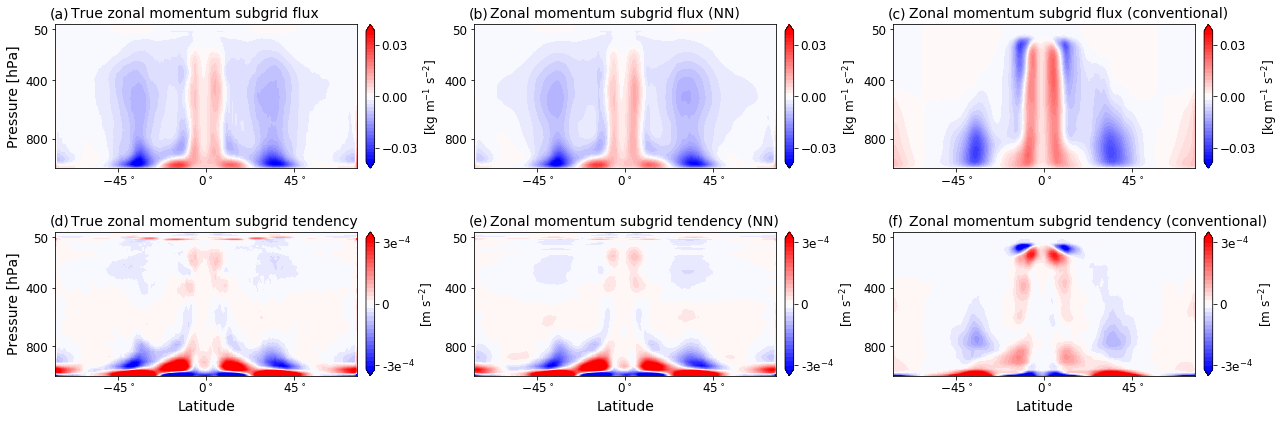

In [76]:
# trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,min_lev_trop_ind=10)
plot_mean_6_2Dfields_production(np.mean(np.moveaxis(inv_output_true_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(u_tend,0,2),axis = (1,3)),
                              np.mean(np.moveaxis(inv_output_pred_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(u_tend_pred,0,2),axis = (1,3)),
                              zu_adv_flux_Em_pp.T[:,:47],
                              data_emanuel_pp[0]['Emanuel_mean_u'].T,
                              y,indices,p, precip_mean_trop,
                              seager_param, true_out_xt_avg, pred_out_xt_avg, pearson_lev = z[zlevel],
#                               save = True, save_name = "u_flux_TEND_true_and_pred_x8_no_c_grid_with_seager_501snapshots_with_shear",with_trop=False,trop_p = trop_p,
                              save = True, save_name = "mean_zonal_Flux_tend_Emanuel_vs_true_vs_NN_PP_48_levels_CU06_DAMP1_prescribe_CBMF_Aug_22",with_trop=False,trop_p = [],
                              plot_shear=False, shear = dU_dz, colorbar_costum_scale = True, 
                              color1 = np.arange(-0.038,0.039,0.002),
                              color1_ticks = [-0.03,0,0.03],
                              color3 = np.arange(-0.000032,0.000033,0.000002),
                              color3_ticks = [-0.00003,0,0.00003],
#                               color3 = np.arange(-0.000120,0.000131,0.00001),
#                               color3_ticks = [-0.00008,0,0.00008],
                              color2 = np.arange(-0.038,0.039,0.002),
                              color2_ticks = [-0.03,0,0.03],
                              color4 = np.arange(-0.000032,0.000033,0.000002),
                              color4_ticks = [-0.00003,0,0.00003],
                              color4_ticks_label = [r'-3e$^{-4}$','0',r'3e$^{-4}$'],
#                               color4 = np.arange(-0.000120,0.000131,0.00001),
#                               color4_ticks = [-0.00008,0,0.00008],
                                     label1='[kg m$^{-1}$ s$^{-2}$]',label3='[m s$^{-2}$]',
                                     label2='[kg m$^{-1}$ s$^{-2}$]',label4='[m s$^{-2}$]',
                             headers = [r"True zonal momentum subgrid flux",r"Zonal momentum subgrid flux (NN)",r"Zonal momentum subgrid flux (conventional)",r"True zonal momentum subgrid tendency",r"Zonal momentum subgrid tendency (NN)",r"Zonal momentum subgrid tendency (conventional)",r"CMT parameterization",r"NN parameterization","","",""])
    


In [83]:
def plot_mean_6_2Dfields_production_no3colorbar(Field,Field2,Field3,Field4,Field5,Field6,y,indices,p, precip_mean_trop,
                                         seager_param, true_out_xt_avg, pred_out_xt_avg, pearson_lev = 11200,save=0,
                                         save_name = 'del',with_trop=False,trop_p =np.zeros(180),
                                 plot_shear = False, shear = [],colorbar_costum_scale = False, 
                                  color1 = [], color1_ticks =[], color2 =[],color2_ticks =[],
                                  color3 = [], color3_ticks =[], color4 =[],color4_ticks =[],
                                  color4_ticks_label=[],
                                  label1 = r'[kg m$^{-1}$ s$^{-2}$]', label2 = r'[m s$^{-2}$]', label3 = r'[kg m$^{-1}$ s$^{-2}$]', label4 = r'[m s$^{-2}$]',
                                    precip_cutoff = 0,
                                    headers = [r"Zonal momentum subgrid flux",
                                               r"Zonal momentum subgrid tendency",
                                               r"Meridional momentum subgrid flux",
                                               r"Meridional momentum subgrid tendency",
                                               r"Moisture surface subgrid flux",
                                               r"diffusivity RF","","",""]
                                 ):
    
    letters = ["(a)","(b)","(c)","(d)","(e)",'(f)',"(g)","(h)",'(i)']
#     headers = [r"Zonal momentum subgrid flux",r"Zonal momentum subgrid tendency",r"Meridional momentum subgrid flux",r"Meridional momentum subgrid tendency",r"Moisture surface subgrid flux",r"diffusivity RF"]

    y_plot = (y - np.mean(y))/10**6
    ticks_lat = [-5,0,5]
    
    ticks_press_tkz = [1000,800,600]
#     ticks_press = [900,600,300]
    ticks_press = [800,400,50]

    if colorbar_costum_scale:
        lev_Rsq = color1
        lev_Rsq_ticks = color1_ticks
        lev_Rsq3 = color3
        lev_Rsq_ticks3 = color3_ticks
    else:
        lev_Rsq = np.arange(-0.04, 0.041, 0.002) 
        lev_Rsq_ticks = np.arange(-0.03, 0.031, 0.02) 
        lev_Rsq3 = lev_Rsq
        lev_Rsq_ticks3 = lev_Rsq
    if colorbar_costum_scale:
        lev_Rsq2 = color2
        lev_Rsq_ticks2 = color2_ticks
        lev_Rsq4 = color4
        lev_Rsq_ticks4 = color4_ticks
    else:
        lev_Rsq2 = np.arange(-0.00004, 0.000041, 0.000002) 
        lev_Rsq_ticks2 = np.arange(-0.00003, 0.000031, 0.00002) 
        lev_Rsq4 = lev_Rsq2
        lev_Rsq_ticks4 = lev_Rsq2

#     ticks_press_R2 = [-0.006,-0.003, 0,0.003,0.006] #np.arange(-0.0075, 0.00751, 0.005)
    
    cont_min_rsq = 0
    cont_max_rsq = 1
    
    fontsize = 14
    fontsize_legend = 8
    h_width = 0.1
    v_width = 0.1
    h_width_cbar = 0.02
    colorbar_width =0.02

    p_lev_diff = 15
    
    row_dim = 3
    col_dim = 3

    fig_witdth = 0.7
    fig_height = 0.5
    fig_h_dist = 0.12
    fig_v_dist = 0.22
    
    size1 = 2
    fig, axes = plt.subplots(row_dim,col_dim)
    # fig.set_figheight(10)
    # fig.set_figwidth(10)
    upper_level_p = 48
    lowest_level = 0
    cmap1 = 'bwr'
    n=30
    yind1 = 65
    x_ind1 = 10
    # wnumber = 1
    ind_ind = 0
    
    
    x0 = axes[0,0].get_position().x0
    x1 = axes[0,0].get_position().x1
    y0 = axes[0,0].get_position().y0
    y1 = axes[0,0].get_position().y1

    for i in range(row_dim):
        for j  in range(col_dim):
            if i == 0 and j == 1:
                axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth/1.0,fig_height])
            else:    
                axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth,fig_height])
    
        
    levels = lev_Rsq
    i = 0
    print(Field.T.shape)
    print(p[0:Field.shape[1]].shape)
    print(y_plot.shape)
    cax_xy1 =axes[i,0].contourf(y_plot,p[0:Field.shape[1]],Field.T,levels = levels,cmap=cmap1, extend="both")
    axes[i, 0].set_ylim(np.amax(p[:]), np.amin(p[0:Field.shape[1]]))
    pos1_rsq = axes[i, 0].get_position() # get the original position 
#     cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
# #     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=lev_Rsq_ticks)
# #     cbar_rsq.ax.set_xlabel(r'kg m$^{-2}$ s$^{-1}$', fontsize=fontsize)
#     cbar_rsq.ax.tick_params(labelsize=fontsize-2)
# #     cbar_rsq.set_label(r'[kg m$^{-1}$ s$^{-2}$]', rotation=90,fontsize=fontsize-2)
#     cbar_rsq.set_label(label1, rotation=90,fontsize=fontsize-2)
    
    if plot_shear:
#         lev_shear_cont =np.arange(-0.026,0.026,0.002)# [0,100,200,300,400,500,600,700]
        lev_shear_cont = [-0.01,-0.003,0.003,0.01]
        cax_q_Rsq = axes[i, 0].contour(y_plot, p[0:shear.shape[0]], shear,lev_shear_cont,colors='k')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
        axes[i, 0].set_ylim(np.amax(p), np.amin(p))
        # axes[1,0].clabel(cax_q_Rsq,cax_q_Rsq.levels[::6],fmt = '%1.0f', inline=1, fontsize=fontsize_cont1)
#         axes[i,0].clabel(cax_q_Rsq,lev_shear_cont[13],fmt = '%1.0f', inline=1, fontsize=fontsize-2)
        lev_shear_cont = [0]
        cax_q_Rsq = axes[i, 0].contour(y_plot, p[0:shear.shape[0]], shear,lev_shear_cont,colors='k')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
        axes[i, 0].set_ylim(np.amax(p), np.amin(p))
        cax_q_Rsq.collections[0].set_linewidth(2) 

    
    levels = lev_Rsq3
    i = 1
    cax_xy1 =axes[i,0].contourf(y_plot,p[0:Field2.shape[1]],Field2.T,levels = levels,cmap=cmap1, extend="both")
    axes[i, 0].set_ylim(np.amax(p[:]), np.amin(p[0:Field2.shape[1]]))
    pos1_rsq = axes[i, 0].get_position() # get the original position 
#     cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
# #     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=lev_Rsq_ticks3)
# #     cbar_rsq.ax.set_xlabel(r'kg m$^{-2}$ s$^{-1}$', fontsize=fontsize)
#     cbar_rsq.ax.tick_params(labelsize=fontsize-2)
#     cbar_rsq.set_label(label3, rotation=90,fontsize=fontsize-2)
#     cbar_rsq.ax.set_yticklabels(color4_ticks_label)
    
    levels = lev_Rsq2
    i = 1
    cax_xy1 =axes[0,i].contourf(y_plot,p[0:Field3.shape[1]],Field3.T,levels = levels,cmap=cmap1, extend="both")
    axes[0, i].set_ylim(np.amax(p[:]), np.amin(p[0:Field3.shape[1]]))
    pos1_rsq = axes[0, i].get_position() # get the original position 
#     cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
# #     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[0,i], shrink=1.0,ticks=lev_Rsq_ticks2)
# #     cbar_rsq.ax.set_xlabel(r'm s$^{-2}$', fontsize=fontsize)
#     cbar_rsq.ax.tick_params(labelsize=fontsize-2)
#     cbar_rsq.set_label(label2, rotation=90,fontsize=fontsize-2)

#     levels = lev_Rsq2
    i = 2
    cax_xy1 =axes[0,i].contourf(y_plot,p[0:Field5.shape[1]],Field5.T,levels = levels,cmap=cmap1, extend="both")
    axes[0, i].set_ylim(np.amax(p[:]), np.amin(p[0:Field3.shape[1]]))
    pos1_rsq = axes[0, i].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[0,i], shrink=1.0,ticks=lev_Rsq_ticks2)
#     cbar_rsq.ax.set_xlabel(r'm s$^{-2}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
    cbar_rsq.set_label(label2, rotation=90,fontsize=fontsize-2)
    
    levels = lev_Rsq4
    i = 1
    cax_xy1 =axes[1,i].contourf(y_plot,p[0:Field4.shape[1]],Field4.T,levels = levels,cmap=cmap1, extend="both")
    axes[1, i].set_ylim(np.amax(p[:]), np.amin(p[0:Field4.shape[1]]))
    pos1_rsq = axes[1, i].get_position() # get the original position 
#     cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
# #     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[1,i], shrink=1.0,ticks=lev_Rsq_ticks4)
#     cbar_rsq.ax.set_yticklabels(color4_ticks_label)
# #     cbar_rsq.ax.set_xlabel(r'm s$^{-2}$', fontsize=fontsize)
#     cbar_rsq.ax.tick_params(labelsize=fontsize-2)
#     cbar_rsq.set_label(label4, rotation=90,fontsize=fontsize-2)

    i = 2
#     print(Field6.T.shape)
#     print(p[0:Field6.shape[1]].shape)
#     print(y_plot.shape)
    cax_xy1 =axes[1,i].contourf(y_plot,p[0:Field6.shape[1]],Field6.T,levels = levels,cmap=cmap1, extend="both")
    axes[1, i].set_ylim(np.amax(p[:]), np.amin(p[0:Field4.shape[1]]))
    pos1_rsq = axes[1, i].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[i,0], shrink=1.0,ticks=np.arange(-0.1, 0.4, 0.1))
    cbar_rsq = fig.colorbar(cax_xy1,cax = cbaxes_rsq, ax=axes[1,i], shrink=1.0,ticks=lev_Rsq_ticks4)
    cbar_rsq.ax.set_yticklabels(color4_ticks_label)
#     cbar_rsq.ax.set_xlabel(r'm s$^{-2}$', fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize-2)
    cbar_rsq.set_label(label4, rotation=90,fontsize=fontsize-2)
    
    if with_trop:
        axes[0,0].plot(y_plot,trop_p,':k')
        axes[1,0].plot(y_plot,trop_p,':k')
        axes[0,1].plot(y_plot,trop_p,':k')
        axes[1,1].plot(y_plot,trop_p,':k')
    
    ind_let = 0
    for i in range(row_dim):
        for j  in range(col_dim):
            atext2 = axes[i, j].text(axes[0,0].get_position().x0*0.9+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.7- (i-1)*fig_height - (i-1)*fig_v_dist ,letters[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)

            header= axes[i, j].text(axes[0,0].get_position().x0*1.3+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.7- (i-1)*fig_height - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
            ind_let = ind_let + 1

            
            
            
    axes[0, 0].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[1, 0].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[2, 0].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[0, 1].set_xlim(np.amin(y_plot), np.amax(y_plot))
    axes[1, 1].set_xlim(np.amin(y_plot), np.amax(y_plot))
    


    axes[0, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
    axes[1, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
#     axes[2, 0].set_ylabel(r'kg m$^{-2}$ s$^{-1}$',fontsize=fontsize)
#     axes[1, 1].set_ylabel(r'kg m$^{-2}$ s$^{-1}$',fontsize=fontsize)


# axes[2, 0].set_xlabel('y [$10^3$ km]',fontsize=fontsize)
# axes[1, 1].set_xlabel('y [$10^3$ km]',fontsize=fontsize)


    axes[1, 0].set_xlabel('Latitude',fontsize=fontsize)
    axes[1, 1].set_xlabel('Latitude',fontsize=fontsize)
    axes[1, 2].set_xlabel('Latitude',fontsize=fontsize)
    
    fontsize_ticks = fontsize -2  
    ticks_lat_degrees = ['$-45^\circ$','$0^\circ$','$45^\circ$']
#     axes[1, 1].set_yticks(ticks_press_R2)
#     axes[1, 1].set_yticklabels(ticks_press_R2,fontsize=fontsize_ticks)
#     axes[2, 0].set_yticks(ticks_press_R2)
#     axes[2, 0].set_yticklabels(ticks_press_R2,fontsize=fontsize_ticks)

#     axes[2, 0].set_xticks(ticks_lat)
#     axes[2, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
#     axes[1, 1].set_xticks(ticks_lat)
#     axes[1, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
     
    axes[0, 0].set_xticks(ticks_lat)
    axes[0, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    axes[1, 0].set_xticks(ticks_lat)
    axes[1, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
   

    axes[0, 1].set_xticks(ticks_lat)
    axes[0, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    
    axes[0, 0].set_yticks(ticks_press)
    axes[0, 0].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
    
    axes[1, 0].set_yticks(ticks_press)
    axes[1, 0].set_yticklabels(ticks_press,fontsize=fontsize_ticks)

    axes[0, 1].set_yticks(ticks_press)
#     axes[0, 1].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
    axes[0, 1].set_yticklabels([],fontsize=fontsize_ticks)
    axes[1, 1].set_yticks(ticks_press)
#     axes[1, 1].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
    axes[1, 1].set_yticklabels([])
  
    axes[1, 2].set_yticks(ticks_press)
#     axes[1, 2].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
    axes[1, 2].set_yticklabels([],fontsize=fontsize_ticks)
    axes[0, 2].set_yticks(ticks_press)
#     axes[0, 2].set_yticklabels(ticks_press,fontsize=fontsize_ticks)
    axes[0, 2].set_yticklabels([],fontsize=fontsize_ticks)
  

    axes[1, 1].set_xticks(ticks_lat)
    axes[1, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)

    axes[1, 2].set_xticks(ticks_lat)
    axes[1, 2].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    axes[0, 2].set_xticks(ticks_lat)
    axes[0, 2].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    
    
#     axes[2, 0].set_xticks(ticks_lat)
#     axes[2, 0].set_xticklabels([])

#     fig.delaxes(axes[2,1])
#     fig.delaxes(axes[2,0])
  
    true_range1 = -0.0000028
    true_range2 = 0.0000075

    true_ticks = [0,0.000003,0.000006]

    mm_rain = 0
#     corr_paramet, _ = pearsonr(seager_param[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])
    corr_paramet, _ = pearsonr(seager_param[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
#     corr_paramet_RF, _ = pearsonr(true_out_xt_avg[precip_mean_trop>2],pred_out_xt_avg[precip_mean_trop>2])
    corr_paramet_RF, _ = pearsonr(np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff],np.reshape(pred_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
    slope, intercept, r_value, p_value, std_err = stats.linregress(seager_param[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])

    slope_no_intercept, _, _, _ = np.linalg.lstsq(seager_param[precip_mean_trop>precip_cutoff,None],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff]) 
    # = stats.linregress(seager_param[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])


    marker1 = 100
    markers_style = ['x','^','o']

    colors1 = ['red','black','blue','green']
    cax_mean_online2 =axes[2,0].scatter(seager_param[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
    axes[2,0].set_xlim(-75, 50)
    axes[2,0].set_ylim(true_range1, true_range2)
    cax_mean_online3 = axes[2,1].scatter(np.reshape(pred_out_xt_avg,-1)[precip_mean_trop>precip_cutoff],np.reshape(true_out_xt_avg,-1)[precip_mean_trop>precip_cutoff])
    axes[2,1].set_xlim(true_range1, true_range2)
    axes[2,1].set_ylim(true_range1, true_range2)

    axes[2, 1].set_xticks(true_ticks)
    axes[2, 1].set_xticklabels(true_ticks,fontsize=fontsize)
    axes[2, 1].set_yticks(true_ticks)
    axes[2, 1].set_yticklabels(true_ticks,fontsize=fontsize)

    axes[2, 0].set_yticks(true_ticks)
    axes[2, 0].set_yticklabels(true_ticks,fontsize=fontsize)
    axes[2, 0].set_xticks([-80,-40,0,40])
    axes[2, 0].set_xticklabels([-80,-40,0,40],fontsize=fontsize)

    
    axes[2, 1].set_xlabel('NN prediction @ (' + "{:.1f}".format(pearson_lev/1000) + 'km)' + '[m s$^{-2}$]',fontsize=fontsize)
    axes[2, 0].set_xlabel(r'Prec*(u(0.6km)- u(' + "{:.1f}".format(pearson_lev/1000) + 'km)' + '[mm day$^{-1}$ m s$^{-1}$]' ,fontsize=fontsize)
    axes[2, 0].set_ylabel(r'True u tend @ (' + "{:.1f}".format(pearson_lev/1000) + 'km)' + r'[m s$^{-2}$]',fontsize=fontsize)
    axes[2, 0].text(0, 0, 'r:' + str(round(corr_paramet,3)),fontsize=fontsize)
    axes[2, 0].text(0, 0-0.0000014, 'slope:' + "{:.2e}".format(slope_no_intercept[0]),fontsize=fontsize)
    axes[2, 1].text(4e-6, 0, 'r:' + str(round(corr_paramet_RF,3)),fontsize=fontsize)

    axes[2,0].spines["top"].set_visible(False)
    axes[2,0].spines["right"].set_visible(False)
    axes[2,1].spines["top"].set_visible(False)
    axes[2,1].spines["right"].set_visible(False)
    fig.delaxes(axes[2,2])
    fig.delaxes(axes[2,1])
    fig.delaxes(axes[2,0])

    if save:
        save_path = '/glade/work/janniy/data_for_offline_momentum_paper/plots/'
        plt.savefig(save_path+ save_name +'.eps', format='eps', bbox_inches="tight")
        
#         from matplotlib.ticker import PercentFormatter

# #         data = [1000, 1000, 5000, 3000, 4000, 16000, 2000]

# #         axes[3,0].hist(np.reshape(field1,-1), weights=np.ones(np.reshape(field1,-1).shape) / np.reshape(field1,-1).shape,bins = 1000)
# #         axes[3,1].hist(np.reshape(field2,-1), weights=np.ones(np.reshape(field2,-1).shape) / np.reshape(field2,-1).shape,bins = 1000)

# #         axes[3,0].gca().yaxis.set_major_formatter(PercentFormatter(1))
    

(47, 180)
(47,)
(180,)


/glade/work/janniy/python_ncar_env/lib/python3.6/site-packages/ipykernel_launcher.py:296: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


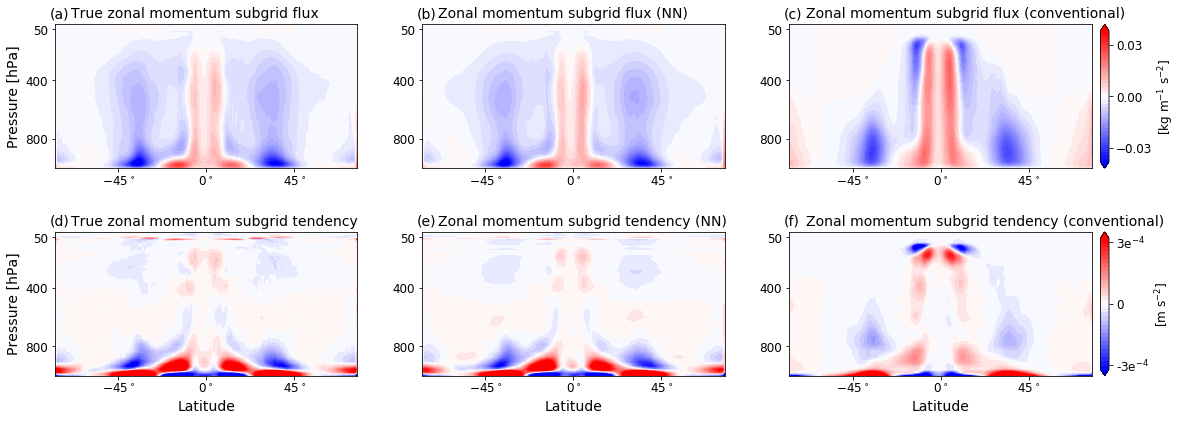

In [62]:
# trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,min_lev_trop_ind=10)
plot_mean_6_2Dfields_production_no3colorbar(np.mean(np.moveaxis(inv_output_true_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(u_tend,0,2),axis = (1,3)),
                              np.mean(np.moveaxis(inv_output_pred_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(u_tend_pred,0,2),axis = (1,3)),
                              zu_adv_flux_Em_pp.T[:,:47],
                              data_emanuel_pp[0]['Emanuel_mean_u'].T,
                              y,indices,p, precip_mean_trop,
                              seager_param, true_out_xt_avg, pred_out_xt_avg, pearson_lev = z[zlevel],
#                               save = True, save_name = "u_flux_TEND_true_and_pred_x8_no_c_grid_with_seager_501snapshots_with_shear",with_trop=False,trop_p = trop_p,
                              save = True, save_name = "mean_zonal_Flux_tend_Emanuel_vs_true_vs_NN_PP_48_levels_CU06_DAMP1_prescribe_CBMF_Aug_22_no3colorbar",with_trop=False,trop_p = [],
                              plot_shear=False, shear = dU_dz, colorbar_costum_scale = True, 
                              color1 = np.arange(-0.038,0.039,0.002),
                              color1_ticks = [-0.03,0,0.03],
                              color3 = np.arange(-0.000032,0.000033,0.000002),
                              color3_ticks = [-0.00003,0,0.00003],
#                               color3 = np.arange(-0.000120,0.000131,0.00001),
#                               color3_ticks = [-0.00008,0,0.00008],
                              color2 = np.arange(-0.038,0.039,0.002),
                              color2_ticks = [-0.03,0,0.03],
                              color4 = np.arange(-0.000032,0.000033,0.000002),
                              color4_ticks = [-0.00003,0,0.00003],
                              color4_ticks_label = [r'-3e$^{-4}$','0',r'3e$^{-4}$'],
#                               color4 = np.arange(-0.000120,0.000131,0.00001),
#                               color4_ticks = [-0.00008,0,0.00008],
                                     label1='[kg m$^{-1}$ s$^{-2}$]',label3='[m s$^{-2}$]',
                                     label2='[kg m$^{-1}$ s$^{-2}$]',label4='[m s$^{-2}$]',
                             headers = [r"True zonal momentum subgrid flux",r"Zonal momentum subgrid flux (NN)",r"Zonal momentum subgrid flux (conventional)",r"True zonal momentum subgrid tendency",r"Zonal momentum subgrid tendency (NN)",r"Zonal momentum subgrid tendency (conventional)",r"CMT parameterization",r"NN parameterization","","",""])
    


(47, 180)
(47,)
(180,)


/glade/work/janniy/python_ncar_env/lib/python3.6/site-packages/ipykernel_launcher.py:300: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


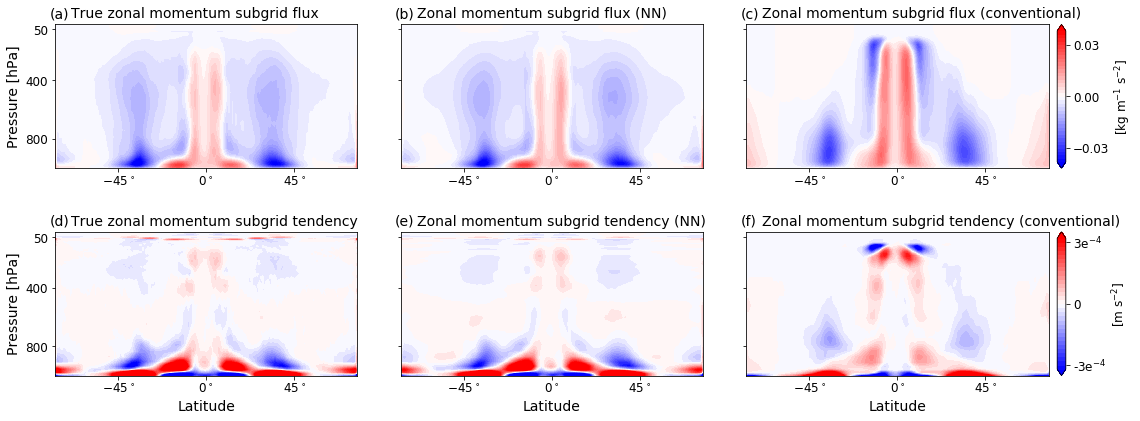

In [81]:
# trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,min_lev_trop_ind=10)
plot_mean_6_2Dfields_production_no3colorbar(np.mean(np.moveaxis(inv_output_true_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(u_tend,0,2),axis = (1,3)),
                              np.mean(np.moveaxis(inv_output_pred_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(u_tend_pred,0,2),axis = (1,3)),
                              zu_adv_flux_Em_pp.T[:,:47],
                              data_emanuel_pp[0]['Emanuel_mean_u'].T,
                              y,indices,p, precip_mean_trop,
                              seager_param, true_out_xt_avg, pred_out_xt_avg, pearson_lev = z[zlevel],
#                               save = True, save_name = "u_flux_TEND_true_and_pred_x8_no_c_grid_with_seager_501snapshots_with_shear",with_trop=False,trop_p = trop_p,
                              save = True, save_name = "mean_zonal_Flux_tend_Emanuel_vs_true_vs_NN_PP_48_levels_CU06_DAMP1_prescribe_CBMF_Aug_22_no3colorbar_nopressurelabel2",with_trop=False,trop_p = [],
                              plot_shear=False, shear = dU_dz, colorbar_costum_scale = True, 
                              color1 = np.arange(-0.038,0.039,0.002),
                              color1_ticks = [-0.03,0,0.03],
                              color3 = np.arange(-0.000032,0.000033,0.000002),
                              color3_ticks = [-0.00003,0,0.00003],
#                               color3 = np.arange(-0.000120,0.000131,0.00001),
#                               color3_ticks = [-0.00008,0,0.00008],
                              color2 = np.arange(-0.038,0.039,0.002),
                              color2_ticks = [-0.03,0,0.03],
                              color4 = np.arange(-0.000032,0.000033,0.000002),
                              color4_ticks = [-0.00003,0,0.00003],
                              color4_ticks_label = [r'-3e$^{-4}$','0',r'3e$^{-4}$'],
#                               color4 = np.arange(-0.000120,0.000131,0.00001),
#                               color4_ticks = [-0.00008,0,0.00008],
                                     label1='[kg m$^{-1}$ s$^{-2}$]',label3='[m s$^{-2}$]',
                                     label2='[kg m$^{-1}$ s$^{-2}$]',label4='[m s$^{-2}$]',
                             headers = [r"True zonal momentum subgrid flux",r"Zonal momentum subgrid flux (NN)",r"Zonal momentum subgrid flux (conventional)",r"True zonal momentum subgrid tendency",r"Zonal momentum subgrid tendency (NN)",r"Zonal momentum subgrid tendency (conventional)",r"CMT parameterization",r"NN parameterization","","",""])
    


(47, 180)
(47,)
(180,)


/glade/work/janniy/python_ncar_env/lib/python3.6/site-packages/ipykernel_launcher.py:296: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


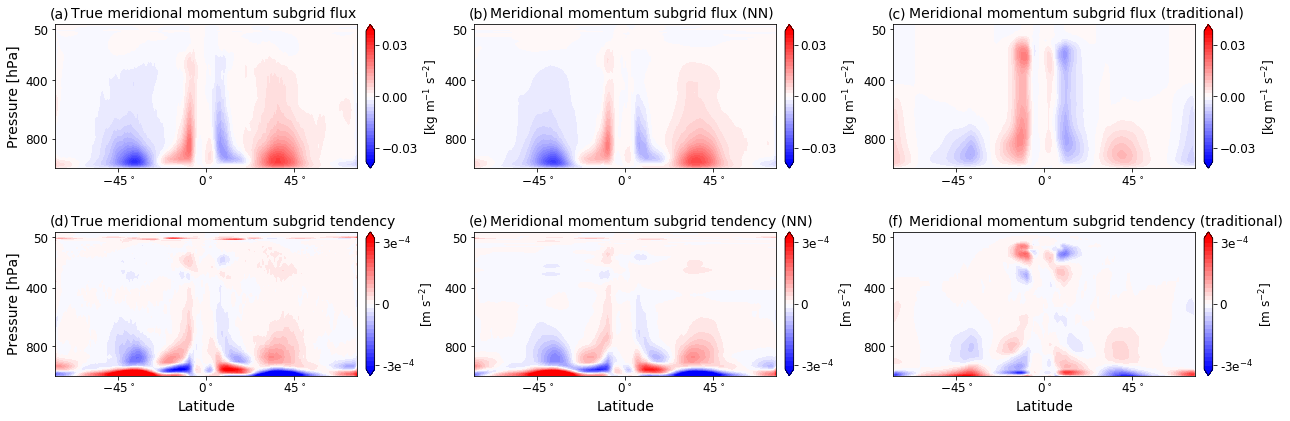

In [53]:
# trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,min_lev_trop_ind=10)
plot_mean_6_2Dfields_production(np.mean(np.moveaxis(inv_output_true_test_3D[15+47:15+47+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(v_tend,0,2),axis = (1,3)),
                              np.mean(np.moveaxis(inv_output_pred_test_3D[15+47:15+47+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(v_tend_pred,0,2),axis = (1,3)),
                              zv_adv_flux_Em_pp.T[:,:47],
                              data_emanuel_pp[0]['Emanuel_mean_v'].T,
                              y,indices,p, precip_mean_trop,
                              seager_param, true_out_xt_avg, pred_out_xt_avg, pearson_lev = z[zlevel],
#                               save = True, save_name = "u_flux_TEND_true_and_pred_x8_no_c_grid_with_seager_501snapshots_with_shear",with_trop=False,trop_p = trop_p,
                              save = True, save_name = "mean_meridional_Flux_tend_Emanuel_vs_true_vs_NN_PP_48_levels_CU06_DAMP1_prescribe_CBMF_Aug_22",with_trop=False,trop_p = [],
                              plot_shear=False, shear = dU_dz, colorbar_costum_scale = True, 
                              color1 = np.arange(-0.038,0.039,0.002),
                              color1_ticks = [-0.03,0,0.03],
                              color3 = np.arange(-0.000032,0.000033,0.000002),
                              color3_ticks = [-0.00003,0,0.00003],
#                               color3 = np.arange(-0.000120,0.000131,0.00001),
#                               color3_ticks = [-0.00008,0,0.00008],
                              color2 = np.arange(-0.038,0.039,0.002),
                              color2_ticks = [-0.03,0,0.03],
                              color4 = np.arange(-0.000032,0.000033,0.000002),
                              color4_ticks = [-0.00003,0,0.00003],
                              color4_ticks_label = [r'-3e$^{-4}$','0',r'3e$^{-4}$'],
#                               color4 = np.arange(-0.000120,0.000131,0.00001),
#                               color4_ticks = [-0.00008,0,0.00008],
                                     label1='[kg m$^{-1}$ s$^{-2}$]',label3='[m s$^{-2}$]',
                                     label2='[kg m$^{-1}$ s$^{-2}$]',label4='[m s$^{-2}$]',
                             headers = [r"True meridional momentum subgrid flux",r"Meridional momentum subgrid flux (NN)",r"Meridional momentum subgrid flux (traditional)",r"True meridional momentum subgrid tendency",r"Meridional momentum subgrid tendency (NN)",r"Meridional momentum subgrid tendency (traditional)",r"CMT parameterization",r"NN parameterization","","",""])
    


(47, 180)
(47,)
(180,)


/glade/work/janniy/python_ncar_env/lib/python3.6/site-packages/ipykernel_launcher.py:300: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


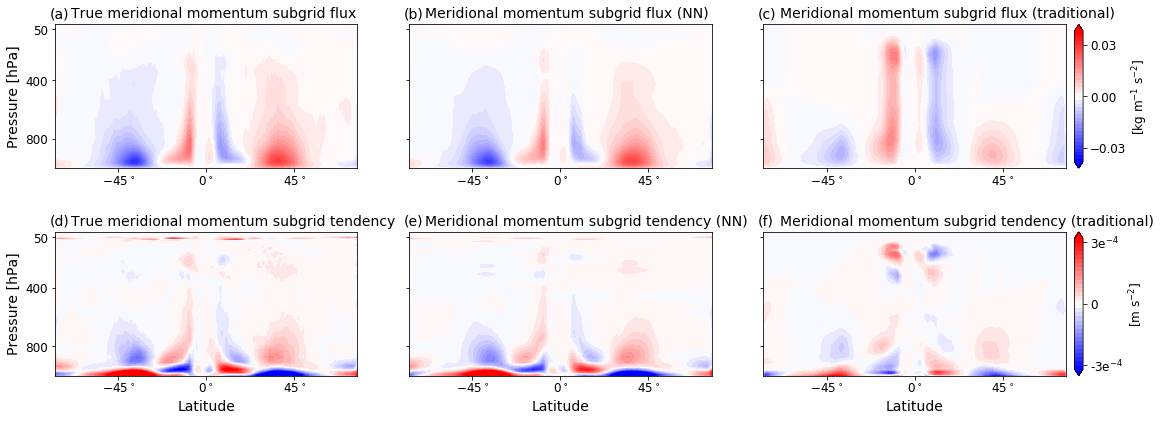

In [84]:
# trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,min_lev_trop_ind=10)
plot_mean_6_2Dfields_production_no3colorbar(np.mean(np.moveaxis(inv_output_true_test_3D[15+47:15+47+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(v_tend,0,2),axis = (1,3)),
                              np.mean(np.moveaxis(inv_output_pred_test_3D[15+47:15+47+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(v_tend_pred,0,2),axis = (1,3)),
                              zv_adv_flux_Em_pp.T[:,:47],
                              data_emanuel_pp[0]['Emanuel_mean_v'].T,
                              y,indices,p, precip_mean_trop,
                              seager_param, true_out_xt_avg, pred_out_xt_avg, pearson_lev = z[zlevel],
#                               save = True, save_name = "u_flux_TEND_true_and_pred_x8_no_c_grid_with_seager_501snapshots_with_shear",with_trop=False,trop_p = trop_p,
                              save = True, save_name = "mean_meridional_Flux_tend_Emanuel_vs_true_vs_NN_PP_48_levels_CU06_DAMP1_prescribe_CBMF_Aug_22_no3colorbar_nopressurelabel2",with_trop=False,trop_p = [],
                              plot_shear=False, shear = dU_dz, colorbar_costum_scale = True, 
                              color1 = np.arange(-0.038,0.039,0.002),
                              color1_ticks = [-0.03,0,0.03],
                              color3 = np.arange(-0.000032,0.000033,0.000002),
                              color3_ticks = [-0.00003,0,0.00003],
#                               color3 = np.arange(-0.000120,0.000131,0.00001),
#                               color3_ticks = [-0.00008,0,0.00008],
                              color2 = np.arange(-0.038,0.039,0.002),
                              color2_ticks = [-0.03,0,0.03],
                              color4 = np.arange(-0.000032,0.000033,0.000002),
                              color4_ticks = [-0.00003,0,0.00003],
                              color4_ticks_label = [r'-3e$^{-4}$','0',r'3e$^{-4}$'],
#                               color4 = np.arange(-0.000120,0.000131,0.00001),
#                               color4_ticks = [-0.00008,0,0.00008],
                                     label1='[kg m$^{-1}$ s$^{-2}$]',label3='[m s$^{-2}$]',
                                     label2='[kg m$^{-1}$ s$^{-2}$]',label4='[m s$^{-2}$]',
                             headers = [r"True meridional momentum subgrid flux",r"Meridional momentum subgrid flux (NN)",r"Meridional momentum subgrid flux (traditional)",r"True meridional momentum subgrid tendency",r"Meridional momentum subgrid tendency (NN)",r"Meridional momentum subgrid tendency (traditional)",r"CMT parameterization",r"NN parameterization","","",""])
    


In [ ]:
# trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,min_lev_trop_ind=10)
plot_mean_6_2Dfields_production_no3colorbar(np.mean(np.moveaxis(inv_output_true_test_3D[15+47:15+47+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(v_tend,0,2),axis = (1,3)),
                              np.mean(np.moveaxis(inv_output_pred_test_3D[15+47:15+47+47,:,:,:],0,2),axis = (0,3)),
                              np.mean(np.moveaxis(v_tend_pred,0,2),axis = (1,3)),
                              zv_adv_flux_Em_pp.T[:,:47],
                              data_emanuel_pp[0]['Emanuel_mean_v'].T,
                              y,indices,p, precip_mean_trop,
                              seager_param, true_out_xt_avg, pred_out_xt_avg, pearson_lev = z[zlevel],
#                               save = True, save_name = "u_flux_TEND_true_and_pred_x8_no_c_grid_with_seager_501snapshots_with_shear",with_trop=False,trop_p = trop_p,
                              save = True, save_name = "mean_meridional_Flux_tend_Emanuel_vs_true_vs_NN_PP_48_levels_CU06_DAMP1_prescribe_CBMF_Aug_22_no3colorbar",with_trop=False,trop_p = [],
                              plot_shear=False, shear = dU_dz, colorbar_costum_scale = True, 
                              color1 = np.arange(-0.038,0.039,0.002),
                              color1_ticks = [-0.03,0,0.03],
                              color3 = np.arange(-0.000032,0.000033,0.000002),
                              color3_ticks = [-0.00003,0,0.00003],
#                               color3 = np.arange(-0.000120,0.000131,0.00001),
#                               color3_ticks = [-0.00008,0,0.00008],
                              color2 = np.arange(-0.038,0.039,0.002),
                              color2_ticks = [-0.03,0,0.03],
                              color4 = np.arange(-0.000032,0.000033,0.000002),
                              color4_ticks = [-0.00003,0,0.00003],
                              color4_ticks_label = [r'-3e$^{-4}$','0',r'3e$^{-4}$'],
#                               color4 = np.arange(-0.000120,0.000131,0.00001),
#                               color4_ticks = [-0.00008,0,0.00008],
                                     label1='[kg m$^{-1}$ s$^{-2}$]',label3='[m s$^{-2}$]',
                                     label2='[kg m$^{-1}$ s$^{-2}$]',label4='[m s$^{-2}$]',
                             headers = [r"True meridional momentum subgrid flux",r"Meridional momentum subgrid flux (NN)",r"Meridional momentum subgrid flux (traditional)",r"True meridional momentum subgrid tendency",r"Meridional momentum subgrid tendency (NN)",r"Meridional momentum subgrid tendency (traditional)",r"CMT parameterization",r"NN parameterization","","",""])
    


In [92]:
# # trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,min_lev_trop_ind=10)
# plot_mean_6_2Dfields_production(np.mean(np.moveaxis(inv_output_true_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
#                               np.mean(np.moveaxis(u_tend,0,2),axis = (1,3)),
#                               np.mean(np.moveaxis(inv_output_pred_test_3D[15:15+47,:,:,:],0,2),axis = (0,3)),
#                               np.mean(np.moveaxis(u_tend_pred,0,2),axis = (1,3)),
#                               zu_adv_flux_Em_pp.T[:,:47],
#                               data_emanuel_pp[0]['Emanuel_mean_u'].T,
#                               y,indices,p, precip_mean_trop,
#                               seager_param, true_out_xt_avg, pred_out_xt_avg, pearson_lev = z[zlevel],
# #                               save = True, save_name = "u_flux_TEND_true_and_pred_x8_no_c_grid_with_seager_501snapshots_with_shear",with_trop=False,trop_p = trop_p,
#                               save = False, save_name = "mean_zonal_Flux_tend_Emanuel_vs_true_vs_NN_PP_48_levels_CU06_DAMP1_prescribe_CBMF",with_trop=False,trop_p = [],
#                               plot_shear=False, shear = dU_dz, colorbar_costum_scale = True, 
#                               color1 = np.arange(-0.038,0.039,0.002),
#                               color1_ticks = [-0.03,0,0.03],
#                               color3 = np.arange(-0.000032,0.000033,0.000002),
#                               color3_ticks = [-0.00003,0,0.00003],
# #                               color3 = np.arange(-0.000120,0.000131,0.00001),
# #                               color3_ticks = [-0.00008,0,0.00008],
#                               color2 = np.arange(-0.038,0.039,0.002),
#                               color2_ticks = [-0.03,0,0.03],
#                               color4 = np.arange(-0.000032,0.000033,0.000002),
#                               color4_ticks = [-0.00003,0,0.00003],
#                               color4_ticks_label = [r'-3e$^{-4}$','0',r'3e$^{-4}$'],
# #                               color4 = np.arange(-0.000120,0.000131,0.00001),
# #                               color4_ticks = [-0.00008,0,0.00008],
#                                      label1='[kg m$^{-1}$ s$^{-2}$]',label3='[m s$^{-2}$]',
#                                      label2='[kg m$^{-1}$ s$^{-2}$]',label4='[m s$^{-2}$]',
#                              headers = [r"True zonal momentum subgrid flux",r"NN predicted zonal momentum subgrid flux",r"Emanuel predicted zonal momentum subgrid flux",r"True zonal momentum subgrid tendency",r"NN predicted zonal momentum subgrid tendency",r"Emanuel predicted zonal momentum subgrid tendency",r"CMT parameterization",r"NN parameterization","","",""])
    


In [ ]:
# plot_sapshots_2x2_mom_energy_switch(true_u_flux,np.moveaxis(v_48_lev['Tadv'],3,1), pred_u_flux,true_u_flux_vert_mean,pred_u_flux_vert_mean,precip,p,y_i=96,
#                                     save_flag=True,
#                                     time_ind1=125,
#                                     time_ind2=225,
#                                     x_ind1=66,
#               save_name1='momentum_precip_energy_vs_time_pressure_narrow_mean_vert_no_c_grid_all_new_updated',plot_trop=False,trop_p = [],flux_ticks_colorbarT = np.arange(-0.6,0.65,0.3),
#                                    sat_fact = 1.0,range_momentum = 0.75,range_energy=0.45, precip_labels = [0,150, 300],
#                                    flux_ticks_label=[0, -0.15, 0, 0.15],
#                                    y_lim1 =-0.350, y_lim2 =0.21,
#                                    letters = ["(a) True subgrid momentum flux","(b) Mean fluxes and precipitation",'(c) Predicted subgrid momentum flux','(d) True subgrid energy flux','','','','']
#                                    )
# #26,7,46,56


In [93]:
# plot_sapshots_2x2_mom_energy_switch(true_u_flux,np.moveaxis(zu_adv_flux_Em_pp_time,3,1),
#                                     pred_u_flux,
#                                     true_u_flux_vert_mean,
#                                     np.mean(np.moveaxis(zu_adv_flux_Em_pp_time,3,1),axis=0),precip,p,y_i=96,
#                                     save_flag=True,
#                                     time_ind1=125,
#                                     time_ind2=225,
#                                     x_ind1=66,
#               save_name1='Time_series_momentum_Emanuel_vs_NN_vs_True_PP_48_levels_CU06_DAMP1_prescribe_CBMF',plot_trop=False,trop_p = [],flux_ticks_colorbarT = np.arange(-0.6,0.65,0.3),
#                                    sat_fact = 1.0,range_momentum = 0.75,range_energy=0.75, precip_labels = [0,150, 300],
#                                    flux_ticks_label=[0, -0.15, 0, 0.15],
#                                    y_lim1 =-0.350, y_lim2 =0.21,
#                                    letters = ["(a) True subgrid momentum flux","(b) Mean fluxes and precipitation",'(c) NN Predicted subgrid momentum flux','(d) Emanuel subgrid momentum flux','','','','']
#                                    )

(100,)
(30,)
(30, 100)


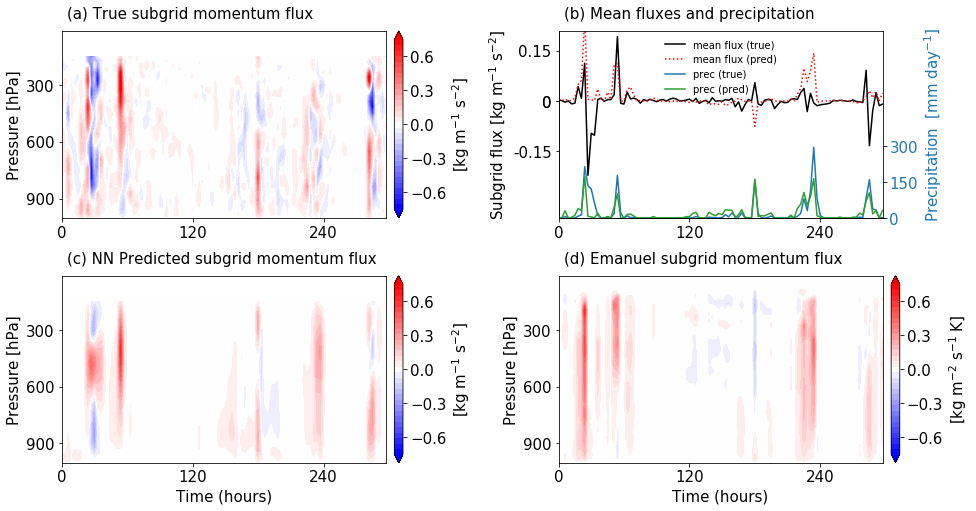

In [96]:
plot_sapshots_2x2_mom_energy_switch_2precip(true_u_flux,np.moveaxis(zu_adv_flux_Em_pp_time,3,1),
                                    pred_u_flux,
                                    true_u_flux_vert_mean,
                                    np.mean(np.moveaxis(zu_adv_flux_Em_pp_time,3,1),axis=0),
                                    precip,emanuel_name_tend[0]['precipitation'],p,y_i=96,
                                    save_flag=True,
                                    time_ind1=125,
                                    time_ind2=225,
                                    x_ind1=66,
              save_name1='Time_series_momentum_Emanuel_vs_NN_vs_True_PP_48_levels_CU06_DAMP1_prescribe_CBMF_precip_Aug_22',plot_trop=False,trop_p = [],flux_ticks_colorbarT = np.arange(-0.6,0.65,0.3),
                                   sat_fact = 1.0,range_momentum = 0.75,range_energy=0.75, precip_labels = [0,150, 300],
                                   flux_ticks_label=[0, -0.15, 0, 0.15],
                                   y_lim1 =-0.350, y_lim2 =0.21,
                                   letters = ["(a) True subgrid momentum flux","(b) Mean fluxes and precipitation",'(c) NN Predicted subgrid momentum flux','(d) Emanuel subgrid momentum flux','','','','']
                                   )

In [97]:
def plot_sapshots_2x2_mom_energy_switch(true_field,true_sec_field,pred_field,true_field_int_z,pred_field_int_z,
                  precip,p,y_i =80,change_range=0,save_flag = False,save_name1= 'del_snap',
                  plot_trop=False,trop_p = [],
                  x_ind1 =10, time_ind1=-100, time_ind2 = -1,
                                 flux_ticks_colorbarT = np.arange(-0.6,0.65,0.3),
                                 flux_ticks_colorbar = np.arange(-0.6,0.65,0.3),
                                 flag_moisture = False,
                                 flux_ticks_label = [-0.3,-0.15,0,0.15000,0.3000],
                                 y_lim1 =-0.7000, y_lim2 =0.4400,
                                 range_momentum = 0,
                                 range_energy = 0, sat_fact = 1.5, precip_labels = [0,50,100,150],
                                 letters = ["(a) True subgrid momentum flux","(b) Mean fluxes and precipitation",'(c) Predicted subgrid momentum flux','(d) True subgrid energy flux','','','','']
                 ):
    per_day = 3600*24
    fontsize = 15
    fontsize_legend = 8
    h_width = 0.1
    v_width = 0.1
    h_width_cbar = 0.02
    colorbar_width =0.02

    row_dim = 3
    col_dim = 2

    fig_witdth = 0.75
    fig_height = 0.65
    fig_h_dist = 0.4
    fig_v_dist = 0.2
    
#     flux_ticks_colorbar = np.arange(-0.6,0.65,0.2)
#     flux_ticks_colorbar = np.arange(-0.6,0.65,0.2)

#     if flag_moisture:
#         letters = ["(a) True subgrid momentum flux","(b) Mean fluxes and precipitation",'(c) Predicted subgrid momentum flux','(d) True subgrid moisture flux','','','','']
#     else:
#         letters = ["(a) True subgrid momentum flux","(b) Mean fluxes and precipitation",'(c) Predicted subgrid momentum flux','(d) True subgrid energy flux','','','','']
#     letters = ["(a) True subgrid momentum flux","(b) Predicted subgrid momentum flux",'(c) Integrated fluxes and precipitation','(d) True subgrid moisture flux','','','','']

    size1 = 2
    fig, axes = plt.subplots(row_dim,col_dim)
    # fig.set_figheight(10)
    # fig.set_figwidth(10)
    upper_level_p = 30
    lowest_level = 0
    cmap1 = 'bwr'
    time_steps = time_ind2 - time_ind1
    time = np.arange(0,time_steps*3,3)
    n=31
    yind1 = y_i
#     x_ind1 = 10
    # wnumber = 1
    if range_momentum == 0:
        range11 = np.max(np.abs((true_u_flux[:,-time_steps:,yind1,x_ind1])))/sat_fact
    else:
        range11 = range_momentum
    levels = np.linspace(-range11, range11, n+1)
    print(time.shape)
    print(p[lowest_level:upper_level_p].shape)
    print(true_field[lowest_level:upper_level_p,time_ind1:time_ind2,yind1,x_ind1][lowest_level:upper_level_p].shape)
    cax_mean_online2 =axes[0,0].contourf(time,p[lowest_level:upper_level_p],true_field[lowest_level:upper_level_p,time_ind1:time_ind2,yind1,x_ind1],levels = levels,cmap=cmap1, extend="both")
    axes[0, 0].set_ylim(np.amax(p[lowest_level]), np.amin(p))
    if plot_trop:
        axes[0, 0].plot(time,trop_p)

    if change_range == 1:
        range11 = np.max(np.abs((pred_field[:,-time_steps:,yind1,x_ind1])))/sat_fact
        levels = np.linspace(-range11, range11, n+1)
        upper_level_p = pred_field.shape[0]
    cax_mean_online3 =axes[1,0].contourf(time,p[lowest_level:upper_level_p],pred_field[lowest_level:upper_level_p,time_ind1:time_ind2,yind1,x_ind1],levels = levels,cmap=cmap1, extend="both")
    axes[1, 0].set_ylim(np.amax(p[lowest_level]), np.amin(p))
    if plot_trop:
        axes[1, 0].plot(time,trop_p)

    


    color = 'black'
    lns1 =axes[0,1].plot(time,true_field_int_z[time_ind1:time_ind2,yind1,x_ind1], color=color,label='mean flux (true)')
    lns2 =axes[0,1].plot(time,pred_field_int_z[time_ind1:time_ind2,yind1,x_ind1], 'r:',label='mean flux (predicted)')
    axes[0, 1].set_xlim(0, time[-1])
    axes[0, 1].tick_params(axis='y', labelcolor=color)

    
    ax2 = axes[0, 1].twinx()
    color = 'tab:blue'
    lns3 =ax2.plot(time,precip[yind1,x_ind1,time_ind1:time_ind2], color=color,label='precipitation')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel(r'Subgrid flux [kg m$^{-1}$ s$^{-2}$]', color=color,fontsize=fontsize)  # we already handled the x-label with ax1
#     ax2 = axes[0, 1].twinx()
#     color = 'tab:blue'
#     ax2.set_ylabel(r'Subgrid flux [kg m$^{-1}$ s$^{-2}$]', color=color,fontsize=fontsize)  # we already handled the x-label with ax1
# #     ax2.set_ylabel(r'Subgrid flux [kg s$^{-2}$]', color=color,fontsize=fontsize)  # we already handled the x-label with ax1
#     lns2 =ax2.plot(time,true_field_int_z[time_ind1:time_ind2,yind1,x_ind1], color=color,label='mean flux (true)')
#     ax2.tick_params(axis='y', labelcolor=color)
#     lns3 =ax2.plot(time,pred_field_int_z[time_ind1:time_ind2,yind1,x_ind1], 'r:',label='mean flux (predicted)')
    
    # added these three lines
    lns = lns1+lns2+lns3
    labs = [l.get_label() for l in lns]
    axes[0, 1].legend(lns, labs, loc='upper center',frameon=False)
    
    
    upper_level_p_energy = 48
    if range_energy ==0:
        range_energy = np.max(np.abs((true_sec_field[:,-time_steps:,yind1,x_ind1])))/1.5
    else:
        range_energy =range_energy
    levels_energy = np.linspace(-range_energy, range_energy, n+1)
    cax_mean_online_enrgy =axes[1,1].contourf(time,p[lowest_level:upper_level_p_energy],true_sec_field[lowest_level:upper_level_p_energy,time_ind1:time_ind2,yind1,x_ind1],levels = levels_energy,cmap=cmap1, extend="both")
    axes[1, 1].set_ylim(np.amax(p[lowest_level]), np.amin(p))
    if plot_trop:
        axes[1, 1].plot(time,trop_p)
    
    # yind1 = 43
    # # wnumber = 1
    # range11 = np.max(np.abs((fuz[:,yind1,x_ind1,:])))/1.4
    # levels = np.linspace(-range11, range11, n+1)
    # cax_mean_online3 =axes[0,1].contourf(time,p[lowest_level:upper_level_p],(fuz[lowest_level:upper_level_p,yind1,x_ind1,:]),levels = levels,cmap=cmap1)
    # axes[0, 1].set_ylim(np.amax(p[lowest_level]), np.amin(p))


    # color = 'tab:red'
    # cax_mean_online4 =axes[1,1].plot(time,precip11[yind1,x_ind1,:]*24*3600, color=color)
    # axes[1, 1].set_xlim(0, time[-1])
    # axes[1, 1].tick_params(axis='y', labelcolor=color)


    # ax2 = axes[1, 1].twinx()
    # color = 'tab:blue'
    # ax2.set_ylabel('subg flux', color=color)  # we already handled the x-label with ax1
    # cax_mean_online4 =ax2.plot(time,fuz_int[yind1,x_ind1,:], color=color)
    # ax2.tick_params(axis='y', labelcolor=color)



    x0 = axes[0,0].get_position().x0
    x1 = axes[0,0].get_position().x1
    y0 = axes[0,0].get_position().y0
    y1 = axes[0,0].get_position().y1

    for i in range(row_dim):
        for j  in range(col_dim):
            axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth,fig_height])


    ind_let = 0
    for i in range(row_dim):
        for j  in range(col_dim):
            atext2 = axes[i, j].text(axes[0,0].get_position().x0*1.1+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.76- (i-1)*fig_height - (i-1)*fig_v_dist ,letters[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)

    #         header= axes[i, j].text(axes[0,0].get_position().x0*1.5+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.92- (i-1)*fig_height - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
            ind_let = ind_let + 1

    pos1_rsq = axes[0, 0].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    cbar_rsq = fig.colorbar(cax_mean_online2,cax = cbaxes_rsq, ax=axes[0,0], shrink=1.0,ticks=flux_ticks_colorbar)
    cbar_rsq.ax.tick_params(labelsize=fontsize) 
    cbar_rsq.set_label(r'[kg m$^{-1}$ s$^{-2}$]',fontsize=fontsize)
    
    if change_range == 1:
        flux_ticks_colorbar = np.arange(-range11,range11,range11/10)
    pos1_rsq = axes[1, 0].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
#     cbar_rsq = fig.colorbar(cax_mean_online3,cax = cbaxes_rsq, ax=axes[1,0], shrink=1.0,ticks=flux_ticks_colorbar)
    cbar_rsq = fig.colorbar(cax_mean_online3,cax = cbaxes_rsq, ax=axes[1,0], shrink=1.0,ticks=flux_ticks_colorbar)
    cbar_rsq.ax.tick_params(labelsize=fontsize) 
    cbar_rsq.set_label(r'[kg m$^{-1}$ s$^{-2}$]',fontsize=fontsize)

    pos1_rsq = axes[1, 1].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    cbar_rsq = fig.colorbar(cax_mean_online_enrgy,cax = cbaxes_rsq, ax=axes[1,1], shrink=1.0,ticks=flux_ticks_colorbarT)
    cbar_rsq.ax.tick_params(labelsize=fontsize) 
#     cbar_rsq.set_label(r'[kg m$^{-2}$ sec$^{-1}$ K]',fontsize=fontsize)
    if flag_moisture:
        cbar_rsq.set_label(r'[kg m$^{-2}$ s$^{-1}$ kg$^{-1}$ kg]',fontsize=fontsize)
    else:
        cbar_rsq.set_label(r'[kg m$^{-2}$ s$^{-1}$ K]',fontsize=fontsize)

    # pos1_rsq = axes[0, 1].get_position() # get the original position 
    # cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    # cbar_rsq = fig.colorbar(cax_mean_online3,cax = cbaxes_rsq, ax=axes[0,1], shrink=1.0,)

    # pos1_rsq = axes[1, 1].get_position() # get the original position 
    # cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    # cbar_rsq = fig.colorbar(cax_mean_online4,cax = cbaxes_rsq, ax=axes[1,1], shrink=1.0,)





    # pos1_rsq = axes[1, 0].get_position() # get the original position 
    # cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    # cbar_rsq = fig.colorbar(cax_mean_online5,cax = cbaxes_rsq, ax=axes[1,0], shrink=1.0,)





    axes[1, 0].set_xlabel('Time (hours)',fontsize=fontsize)
    axes[1, 1].set_xlabel('Time (hours)',fontsize=fontsize)
    axes[0, 1].set_ylabel(r'Subgrid flux [kg m$^{-1}$ s$^{-2}$]', color='black',fontsize=fontsize)  # we already handled the x-label with ax1
    ax2.set_ylabel(r'Precipitation  [mm day$^{-1}$]',fontsize=fontsize)
    axes[0, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
    axes[1, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
    axes[1, 1].set_ylabel('Pressure [hPa]',fontsize=fontsize)


    # axes[0, 0].set_yticks(ticks_pmean)
    axes[0, 1].set_yticklabels([])
    # axes[1, 1].set_yticklabels([])


    
    axes[0,1].spines["top"].set_visible(False)
    axes[0,1].spines["right"].set_visible(False)

#     precip_ticks = [0,50,100,150,200,250,300,350,400,450]  
    ax2.set_ylim(0,2.6*precip_labels[-1])
    
#     ax2.set_ylim(-7000,8000)
    axes[0, 1].set_ylim(y_lim1,y_lim2)
#     ax2.set_ylim(-0.3000,0.3400)
#     precip_labels = [0,50,100,150]
    precip_ticks = precip_labels
    ax2.set_yticks(precip_ticks)
    ax2.set_yticklabels(precip_labels,fontsize=fontsize)

#     flux_ticks = [-2000,0,2000,4000,6000,8000]
#     flux_ticks = [-6000,-3000,0,3000,6000]
#     flux_ticks_label = [0,0.15000,0.3000]
#     flux_ticks_label = [-0.3,-0.15,0,0.15000,0.3000]
    flux_ticks = flux_ticks_label
    axes[0, 1].set_yticks(flux_ticks_label)
    axes[0, 1].set_yticklabels(flux_ticks_label,fontsize=fontsize)

    pressure_ticks = [300,600,900]
    time_ticks = [0,120,240]
    axes[0, 0].set_xticks(time_ticks)
    axes[0, 0].set_xticklabels(time_ticks,fontsize=fontsize)
    axes[1, 0].set_xticks(time_ticks)
    axes[1, 0].set_xticklabels(time_ticks,fontsize=fontsize)
    axes[1, 1].set_xticks(time_ticks)
    axes[1, 1].set_xticklabels(time_ticks,fontsize=fontsize)
    axes[0, 1].set_xticks(time_ticks)
    axes[0, 1].set_xticklabels(time_ticks,fontsize=fontsize)

    
    axes[0, 0].set_yticks(pressure_ticks)
    axes[0, 0].set_yticklabels(pressure_ticks,fontsize=fontsize)
    axes[1, 1].set_yticks(pressure_ticks)
    axes[1, 1].set_yticklabels(pressure_ticks,fontsize=fontsize)
    axes[1, 0].set_yticks(pressure_ticks)
    axes[1, 0].set_yticklabels(pressure_ticks,fontsize=fontsize)

    fig.delaxes(axes[2,0])
    fig.delaxes(axes[2,1])

    save_path = '/glade/work/janniy/data_for_offline_momentum_paper/plots/'
    if save_flag:
        plt.savefig(save_path+save_name1 + '.eps', format='eps', bbox_inches="tight")
    
#     plt.savefig(save_path+'snapshot_u_flux_precip.eps', format='eps', bbox_inches="tight")
#     plt.savefig(save_path+'snapshot_u_flux_T_flux_show_noise2.eps', format='eps', bbox_inches="tight")
    # plt.savefig(save_path+'correcting_u_precip_subgrid_hovemoller_tropics2_int_flux.eps', format='eps', bbox_inches="tight")

# R^2 Emanuel vs NN

In [85]:
#TODO
Rsq_emanuel_u = np.zeros((47,180))
Rsq_emanuel_v = np.zeros((47,180))

Rsq_NN_v = np.zeros((47,180))
Rsq_NN_u = np.zeros((47,180))

for yi in range(pred_u_flux.shape[2]):
    for zi in range(zu_adv_flux_Em_pp_time.shape[0]-2):
        Rsq_emanuel_u[zi,yi] = r2_score(np.reshape(true_u_flux[zi,:,yi,:],-1),np.reshape(np.moveaxis(zu_adv_flux_Em_pp_time,3,1)[zi,:,yi,:],-1))
        Rsq_emanuel_v[zi,yi] =  r2_score(np.reshape(true_v_flux[zi,:,yi,:],-1),np.reshape(np.moveaxis(zv_adv_flux_Em_pp_time,3,1)[zi,:,yi,:],-1))
        Rsq_NN_u[zi,yi] = r2_score(np.reshape(true_u_flux[zi,:,yi,:],-1),np.reshape(pred_u_flux[zi,:,yi,:],-1))
        Rsq_NN_v[zi,yi] = r2_score(np.reshape(true_v_flux[zi,:,yi,:],-1),np.reshape(pred_v_flux[zi,:,yi,:],-1))
,

''

(47, 180)
(47,)
(180,)


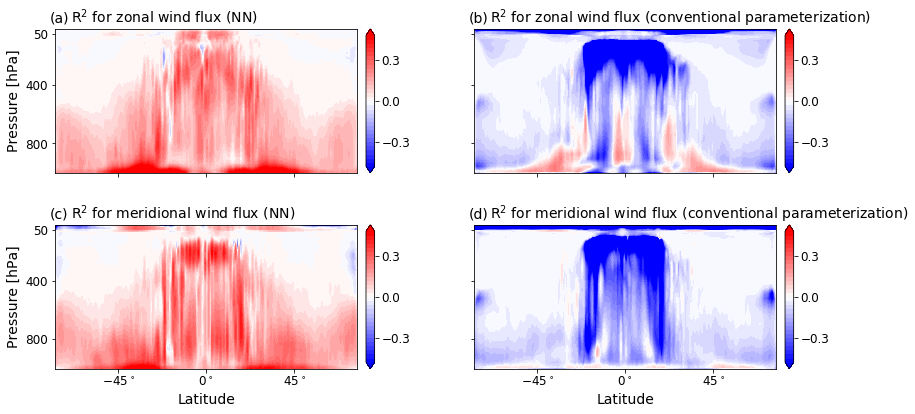

In [87]:
# trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,p,min_lev_trop_ind=10)
plot_mean_4_fields_production(Rsq_NN_u.T, Rsq_NN_v.T,
                              Rsq_emanuel_u.T, Rsq_emanuel_v.T,
                              y,indices,p[0:47],save = True, save_name = "Rsq_Flux_Emanuel_vs_NN_PP_48_levels_CU06_DAMP1_prescribe_CBMF_Aug_22_conventional",with_trop=False,trop_p = 0,
                              plot_shear=False, shear = [], colorbar_costum_scale = True, 
                              color4 = np.arange(-0.48,0.49,0.03),
                              color4_ticks = [-0.3,0,0.3],
                              color2 = np.arange(-0.48,0.49,0.03),
                              color2_ticks = [-0.3,0,0.3],
                              color3 = np.arange(-0.48,0.49,0.03),
                              color3_ticks = [-0.3,0,0.3],
                              color1 = np.arange(-0.48,0.49,0.03),
                              color1_ticks = [-0.3,0,0.3],
                              label1='',
                              label2='',
                              label3='',
                              label4='',
                              headers = [r"R$^2$ for zonal wind flux (NN)",r"R$^2$ for zonal wind flux (conventional parameterization)",r"R$^2$ for meridional wind flux (NN)",r"R$^2$ for meridional wind flux (conventional parameterization)",r"Emanuel R^2",r"Emanuel zonal wind tendency R^2"])




(47, 180)
(47,)
(180,)


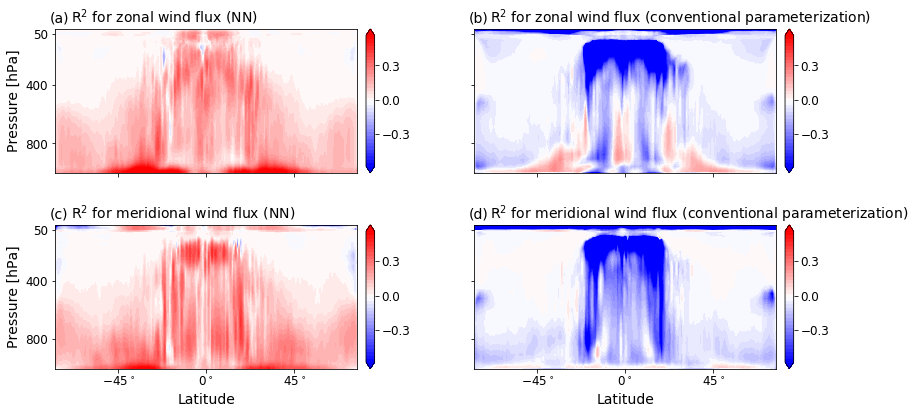

In [88]:
# trop_ind,trop_z,trop_p = calc_lapse_rate(v_48_lev['Tin'],z,p,min_lev_trop_ind=10)
plot_mean_4_fields_production(Rsq_NN_u.T, Rsq_NN_v.T,
                              Rsq_emanuel_u.T, Rsq_emanuel_v.T,
                              y,indices,p[0:47],save = True, save_name = "Rsq_Flux_Emanuel_vs_NN_PP_48_levels_CU06_DAMP1_prescribe_CBMF_larger_scale_Aug_22",with_trop=False,trop_p = 0,
                              plot_shear=False, shear = [], colorbar_costum_scale = True, 
                              color4 = np.arange(-0.58,0.59,0.03),
                              color4_ticks = [-0.3,0,0.3],
                              color2 = np.arange(-0.58,0.59,0.03),
                              color2_ticks = [-0.3,0,0.3],
                              color3 = np.arange(-0.58,0.59,0.03),
                              color3_ticks = [-0.3,0,0.3],
                              color1 = np.arange(-0.58,0.59,0.03),
                              color1_ticks = [-0.3,0,0.3],
                              label1='',
                              label2='',
                              label3='',
                              label4='',
                              headers = [r"R$^2$ for zonal wind flux (NN)",r"R$^2$ for zonal wind flux (conventional parameterization)",r"R$^2$ for meridional wind flux (NN)",r"R$^2$ for meridional wind flux (conventional parameterization)",r"Emanuel R^2",r"Emanuel zonal wind tendency R^2"])




In [89]:
plot_sapshots_2x2_mom_energy_switch_2precip(true_u_flux,np.moveaxis(zu_adv_flux_Em_pp_time,3,1),
                                    pred_u_flux,
                                    true_u_flux_vert_mean,
                                    np.mean(np.moveaxis(zu_adv_flux_Em_pp_time,3,1),axis=0)
                                    ,precip, precip_2,
                                    p,y_i=96,
                                    save_flag=True,
                                    time_ind1=125,
                                    time_ind2=225,
                                    x_ind1=66,
              save_name1='Time_series_momentum_Emanuel_vs_NN_vs_True_PP_48_levels_CU06_DAMP1_prescribe_flux',plot_trop=False,trop_p = [],flux_ticks_colorbarT = np.arange(-0.6,0.65,0.3),
                                   sat_fact = 1.0,range_momentum = 0.75,range_energy=0.45, precip_labels = [0,150, 300],
                                   flux_ticks_label=[0, -0.15, 0, 0.15],
                                   y_lim1 =-0.350, y_lim2 =0.21,
                                   letters = ["(a) True subgrid momentum flux","(b) Mean fluxes and precipitation",'(c) NN Predicted subgrid momentum flux','(d) Emanuel subgrid momentum flux','','','','']
                                   )

NameError: name 'plot_sapshots_2x2_mom_energy_switch_2precip' is not defined

/glade/work/janniy/python_ncar_env/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


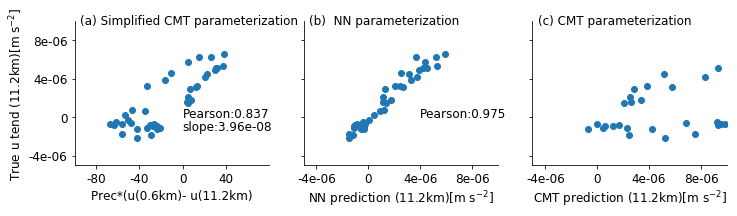

In [70]:
fontsize = 12
fontsize_legend = 8
ticks_lat = [-5,0,5]

# ticks_pmean = [0,0.2,0.4,0.6,0.8]
# ticks_px = ticks_pmean #np.arange(0,900,100)

# ticks_px_offline = ticks_pmean
# ticks_pmean_offline = ticks_pmean


# linewidth=1.5

if zlevel==13:
    true_range1 = -0.000001
    true_range2 = 0.000001
else:
    true_range1 = -0.000005
    true_range2 = 0.00001


if zlevel==13:
    true_ticks = [-0.0000035,0,0.0000035]
else:
    true_ticks = [-0.000004,0,0.000004,0.000008]

h_width = 0.1
v_width = 0.1
h_width_cbar = 0.02
colorbar_width =0.02

row_dim = 2
col_dim = 3

fig_witdth = 0.45
fig_height = 0.5
fig_h_dist = 0.08
fig_v_dist = 0.15
mm_rain = 0
corr_paramet, _ = pearsonr(seager_param[precip_mean_trop>precip_cutoff],true_out_xt_avg[precip_mean_trop>precip_cutoff])
corr_paramet_RF, _ = pearsonr(true_out_xt_avg[precip_mean_trop>precip_cutoff],pred_out_xt_avg[precip_mean_trop>precip_cutoff])
slope, intercept, r_value, p_value, std_err = stats.linregress(seager_param[precip_mean_trop>precip_cutoff],true_out_xt_avg[precip_mean_trop>precip_cutoff])

slope_no_intercept, _, _, _ = np.linalg.lstsq(seager_param[precip_mean_trop>precip_cutoff,None],true_out_xt_avg[precip_mean_trop>precip_cutoff]) 
# = stats.linregress(seager_param[precip_mean_trop>2],true_out_xt_avg[precip_mean_trop>2])


marker1 = 100
markers_style = ['x','^','o']
letters = ["(a) Simplified CMT parameterization","(b)  NN parameterization","(c) CMT parameterization" ,"(d)","a","a"]
# letters = [r"(a) CMT vs. Prec(u(0.6km) - u)","(b)  NN parameterization","(b) NN parameterization" ,"(d)"]

# CMT’b3P3(u925 2u)
# headers = ["$q_t$ tend" +str(r2[0]),"26 lev (48 inputs) $R^2=$"+str(r2[1]),"38 lev $R^2=$"+str(r2[2]),"48 lev $R^2=$"+str(r2[3])]

colors1 = ['red','black','blue','green']
fig, axes = plt.subplots(row_dim,col_dim)

# cax_q_mean_offline = axes[0,0].plot(y_plot,  precip_mean_true * per_day, label='True', linewidth=linewidth,color=colors1[0])#,linestyle=':')
# cax_q_mean_offline2 = axes[0,0].plot(y_plot,  precip_mean_pred * per_day, label='Pred',linestyle='-.', linewidth=linewidth,color=colors1[1])
cax_mean_online2 =axes[0,0].scatter(seager_param[precip_mean_trop>precip_cutoff],true_out_xt_avg[precip_mean_trop>precip_cutoff])


if zlevel==13:
    axes[0,0].set_xlim(-20, 20)
    axes[0,0].set_ylim(true_range1, true_range2)

else:
    axes[0,0].set_xlim(-100, 80)
    axes[0,0].set_ylim(true_range1, true_range2)


cax_mean_online3 = axes[0,1].scatter(pred_out_xt_avg[precip_mean_trop>precip_cutoff],true_out_xt_avg[precip_mean_trop>precip_cutoff])


plot_kerry = True
if plot_kerry:
    u_tend_pred_xt_avg_emanuel = np.mean(emanuel_name_tend[0]['Emanuel_tend_u'][zlevel,latitudes_trop,:,:],axis = (1,2))
    cax_mean_online3 = axes[0,2].scatter(u_tend_pred_xt_avg_emanuel[precip_mean_trop>precip_cutoff],true_out_xt_avg[precip_mean_trop>precip_cutoff])

axes[0,1].set_xlim(true_range1, true_range2)
axes[0,1].set_ylim(true_range1, true_range2)

axes[0,2].set_xlim(true_range1, true_range2)
axes[0,2].set_ylim(true_range1, true_range2)


fig.delaxes(axes[1,0])
fig.delaxes(axes[1,1])
fig.delaxes(axes[1,2])
#Position of first figure        
x0 = axes[0,0].get_position().x0
x1 = axes[0,0].get_position().x1
y0 = axes[0,0].get_position().y0
y1 = axes[0,0].get_position().y1

for i in range(row_dim):
    for j  in range(col_dim):
        axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth,fig_height])
        
    
ind_let = 0
for i in range(row_dim):
    for j  in range(col_dim):
        atext2 = axes[i, j].text(axes[0,0].get_position().x0*1.1+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.7- (i-1)*fig_height - (i-1)*fig_v_dist ,letters[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
        
#         header= axes[i, j].text(axes[0,0].get_position().x0*1.5+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.92- (i-1)*fig_height - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
        ind_let = ind_let + 1


# ticks_lat_degrees = ['$-45^\circ$','$0^\circ$','$45^\circ$']
# axes[1, 0].set_xticks(ticks_lat)
# axes[1, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize)
# axes[1, 0].set_yticks(ticks_px_offline)
# axes[1, 0].set_yticklabels(ticks_px_offline,fontsize=fontsize)

axes[0, 1].set_xticks(true_ticks)
axes[0, 1].set_xticklabels(true_ticks,fontsize=fontsize)
axes[0, 1].set_yticks(true_ticks)
axes[0, 1].set_yticklabels([])

axes[0, 2].set_xticks(true_ticks)
axes[0, 2].set_xticklabels(true_ticks,fontsize=fontsize)
axes[0, 2].set_yticks(true_ticks)
axes[0, 2].set_yticklabels([])



axes[0, 0].set_yticks(true_ticks)
axes[0, 0].set_yticklabels(true_ticks,fontsize=fontsize)
if zlevel==13:
    axes[0, 0].set_xticks([-30,0,30])
    axes[0, 0].set_xticklabels([-30,0,30],fontsize=fontsize)

else:
    axes[0, 0].set_xticks([-80,-40,0,40])
    axes[0, 0].set_xticklabels([-80,-40,0,40],fontsize=fontsize)


# axes[0, 0].set_yticks(ticks_pmean_offline)
# axes[0, 0].set_yticklabels(ticks_pmean_offline,fontsize=fontsize)
# axes[0, 0].set_xticks(ticks_lat)
# axes[0, 0].set_xticklabels([])


# axes[1, 1].set_xticks(ticks_lat)
# axes[1, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize)
# axes[1, 1].set_yticks(ticks_px)
# axes[1, 1].set_yticklabels(ticks_px)



axes[0, 1].set_xlabel('NN prediction (' + "{:.1f}".format(z[zlevel]/1000) + 'km)' + '[m s$^{-2}$]',fontsize=fontsize)
axes[0, 2].set_xlabel('CMT prediction (' + "{:.1f}".format(z[zlevel]/1000) + 'km)' + '[m s$^{-2}$]',fontsize=fontsize)
# axes[1, 0].set_xlabel('RF prediction @ (9km)',fontsize=fontsize)

# axes[1, 0].set_ylabel('True u tend @ (11.2km) [m s$^{-2}$]',fontsize=fontsize)
# axes[1, 0].set_ylabel('True u tend @ (9km) [m s$^{-2}$]',fontsize=fontsize)

# axes[0, 0].set_xlabel(r'Prec*(u(0.6km) - u(11.2km)) [mm m s$^{-1}$ day$^{-1}]',fontsize=fontsize)
# axes[0, 0].set_xlabel(r'Prec*(u(0.6km) - u(11.2km))' ,fontsize=fontsize)
axes[0, 0].set_xlabel(r'Prec*(u(0.6km)- u(' + "{:.1f}".format(z[zlevel]/1000) + 'km)' ,fontsize=fontsize)
# 'NN prediction @ ('+  "{:.1f}".format(z[zlevel]/1000) + 'km) [m s$^{-2}$]'

# axes[0, 0].set_xlabel('Const * Prec*(u(0.6km) - u(9km))',fontsize=fontsize)
axes[0, 0].set_ylabel(r'True u tend (' + "{:.1f}".format(z[zlevel]/1000) + 'km)' + r'[m s$^{-2}$]',fontsize=fontsize)
# axes[0, 0].set_ylabel('True u tend @ (9km) [m s$^{-2}$]',fontsize=fontsize)


if zlevel==13:
    axes[0, 0].text(0, 0.000002, 'Pearson:' + str(round(corr_paramet,3)),fontsize=fontsize)
    axes[0, 0].text(0, 0.000002-0.000001, 'slope:' + "{:.2e}".format(slope_no_intercept[0]),fontsize=fontsize)

    axes[0, 1].text(1e-6, 0.000002, 'Pearson:' + str(round(corr_paramet_RF,3)),fontsize=fontsize)

else:
    axes[0, 0].text(0, 0, 'Pearson:' + str(round(corr_paramet,3)),fontsize=fontsize)
    # axes[0, 0].text(0, 0-0.0000014, 'slope:' + "{:.2e}".format(slope),fontsize=fontsize)
    axes[0, 0].text(0, 0-0.0000014, 'slope:' + "{:.2e}".format(slope_no_intercept[0]),fontsize=fontsize)

    axes[0, 1].text(4e-6, 0, 'Pearson:' + str(round(corr_paramet_RF,3)),fontsize=fontsize)

# scientific_notation = "{:.2e}".format(slope)
# scientific_notation

#  + 'pearson:' + str(round(corr_paramet,3))
# + 'pearson:' + str(round(corr_paramet_RF,3))


axes[0,0].spines["top"].set_visible(False)
axes[0,0].spines["right"].set_visible(False)


axes[0,1].spines["top"].set_visible(False)
axes[0,1].spines["right"].set_visible(False)

axes[0,2].spines["top"].set_visible(False)
axes[0,2].spines["right"].set_visible(False)


axes[1,1].spines["top"].set_visible(False)
axes[1,1].spines["right"].set_visible(False)

axes[1,0].spines["top"].set_visible(False)
axes[1,0].spines["right"].set_visible(False)




# #Saving plot... fxax
save_path = '/glade/work/janniy/data_for_offline_momentum_paper/plots/'


# plt.savefig(save_path+'momentum_parameterization_scatter.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_112km.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_107km_production.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_8_5km_production.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_5_7km_production.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_112km_no_c_grid.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_112km_no_c_grid_5_layers.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_112km_no_c_grid_5_layers_501_snapshpts.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_112km_with_c_grid_5_layers_501_snapshpts_publication2.eps', format='eps', bbox_inches="tight")
# plt.savefig(save_path+'momentum_parameterization_scatter_4_6km_production.eps', format='eps', bbox_inches="tight")

plt.savefig(save_path+'momentum_parameterization_scatter_112km_with_c_grid_5_layers_501_snapshpts_publication_emanuel2.eps', format='eps', bbox_inches="tight")
